# Publication Example Dataset Analysis

This notebook analyzes the Fe grain boundary segregation dataset used in the publication. It demonstrates how to:
1. Load and process the high-throughput segregation energy data
2. Visualize segregation energies across the periodic table
3. Generate publication-quality figures
4. Analyze trends in segregation behavior

The dataset contains segregation energies for various solute elements at multiple grain boundary sites in BCC Fe, calculated using the methodology described in the main workflow notebook.


## Import Required Libraries

This cell imports all necessary packages for data analysis and visualization:
- **pandas & numpy**: For data manipulation and numerical operations
- **matplotlib**: For creating plots and figures
- **pymatgen**: For handling atomic structures and converting between ASE and pymatgen formats
- **FeGB_PtableSeg.plotters**: Custom plotting utilities specifically designed for grain boundary segregation analysis, including:
  - Color schemes and styling for consistent visualization
  - Utility functions for element lookups and conversions
  - Specialized plotting functions for segregation data
  - GB symmetry analysis tools


In [1]:
import pandas as pd
import numpy as np

import os 

import matplotlib.pyplot as plt

from pymatgen.core import Structure
from pymatgen.io.ase import AseAtomsAdaptor

from FeGB_PtableSeg.plotters import (custom_colors,
                                     gb_latex_dict,
                                     bulk_df,
                                     gb_marker_dict,
                                     get_element_number,
                                     get_element_symbol,
                                     plot_pivot_table,
                                     GB_symmetries,
                                     plot_prop_vs_prop_GB,
                                     plot_prop_vs_prop_with_2d_histograms
)


%load_ext autoreload
%autoreload 2

## Load and Preprocess Dataset

This cell performs several critical data preparation steps:

1. **Create output directory**: Sets up a folder for saving publication figures
2. **Load pickled data**: Reads the compressed dataset containing segregation energies for ~90 elements at multiple GB sites
3. **Convert structures**: Transforms ASE Atoms objects to pymatgen Structure JSON format for compatibility
4. **Filter outliers**: Removes unphysical segregation energies (E_seg < -7 eV or > 2 eV) which typically indicate calculation errors
5. **Add atomic numbers**: Maps element symbols to atomic numbers (Z) for periodic table ordering
6. **Identify equivalent sites**: Uses crystallographic symmetry to group equivalent segregation sites, reducing computational redundancy
7. **Calculate site multiplicity**: Determines how many symmetrically equivalent positions exist for each unique site
8. **Create site labels**: Generates unique identifiers combining GB type and site number (e.g., "Σ5(310)-1")

The result is a clean, annotated DataFrame ready for analysis and visualization.


In [10]:
!tar -xf Data/S11-RA110-S3-32-He-19.tar.gz -C Data/

In [2]:
fig_savepath = "./Figures"
os.makedirs(fig_savepath, exist_ok=True)
df = pd.read_pickle("Data/ptable_Fe_GB_df_with_ase_structures.pkl.gz")
def get_structure(atoms):
    try:
        return AseAtomsAdaptor.get_structure(atoms).to_json()
    except:
        return None
df["structure"] = df["structure"].apply(get_structure)
# Get rid of unphysical points
df.loc[(df["E_seg"] < -7) | (df["E_seg"] > 2), "E_seg"] = np.nan
df["Z"] = df.element.apply(get_element_number)
symmetries_dict = GB_symmetries().symmetry_dict_all.copy()
df["equivalent_sites"] = [symmetries_dict[row.GB][row.site] for _, row in df.iterrows()]
df["site_multiplicity"] = [len(row.equivalent_sites) for _, row in df.iterrows()]
df["GB_site"] = [row.GB +"-"+str(row.site) for _, row in df.iterrows()]
df.columns

Index(['job_name', 'structure', 'GB', 'element', 'site', 'Z', 'E_seg',
       'magmoms', 'convergence', 'GB_site', 'structure_unrel', 'E_seg_unrel',
       'magmoms_unrel', 'DDEC6_ANSBO_atomic_layers',
       'DDEC6_ANSBO_cleavage_coords', 'DDEC6_ANSBO_profile',
       'DDEC6_ANSBO_within_range', 'DDEC6_min_ANSBO', 'pure_ca_results',
       'pure_DDEC6_ANSBO_atomic_layers', 'pure_DDEC6_ANSBO_cleavage_coords',
       'pure_DDEC6_ANSBO_profile', 'pure_DDEC6_ANSBO_within_range',
       'pure_DDEC6_min_ANSBO', 'convergence_pureGB', 'magmoms_pureGB',
       'GB_element_site', 'Wsep_RGS_list', 'cleavage_planes', 'cp_names',
       'Wsep_RGS_min', 'pure_cleavage_planes', 'pure_cleavage_energies',
       'pure_min_wsep_rigid', 'site_z', 'solute_idx', 'equivalent_sites',
       'site_multiplicity', 'dist_GB', 'magmom_solute',
       'Wsep_RGS_cleavage_planes', 'Wsep_RGS_min_pure', 'DDEC6_ANSBO_min',
       'R_Wsep_RGS', 'R_Wsep_RGS_lst', 'R_DDEC6_ANSBO', 'R_DDEC6_ANSBO_lst',
       'ANSBO_Wsep_

# Data Visualization Overview

## Segregation Energy Heatmaps

The following visualizations display segregation energies (E_seg) for all solute elements across all studied grain boundary sites. These heatmaps provide a comprehensive view of the segregation behavior:

- **Rows**: Individual GB sites (e.g., Σ5(310)-1, Σ5(310)-2, etc.)
- **Columns**: Solute elements ordered by atomic number (Z)
- **Color scale**: Segregation energy in eV
  - **Negative values (blue)**: Favorable segregation (solute prefers GB over bulk)
  - **Positive values (red)**: Unfavorable segregation (solute prefers bulk)
  - **White/neutral**: No significant preference

We plot both:
1. **Relaxed E_seg**: Final segregation energies after atomic relaxation
2. **Unrelaxed E_seg**: Initial energies without relaxation (shows importance of structural relaxation)

### Generate Heatmaps with Custom Formatting

This cell creates two comprehensive heatmap visualizations using the `plot_pivot_table` function:

**Key Features**:
- **Pivot table structure**: Organizes data with GB sites as rows and elements (Z) as columns
- **Custom x-axis labels**: Converts atomic numbers to element symbols for readability
- **Staggered tick labels**: Applies vertical offsets in a repeating 3-row pattern to prevent label overlap
  - This is especially important when displaying ~90 elements horizontally
  - Uses matplotlib transforms to shift labels by 0.3 units in a cyclical pattern

**Two Plots Generated**:
1. **E_seg (relaxed)**: Shows segregation energies after full atomic relaxation
2. **E_seg_unrel (unrelaxed)**: Shows segregation energies without relaxation

**Comparison Insight**: By comparing these plots, you can identify:
- How much atomic relaxation affects segregation energies
- Which element-site combinations show significant structural relaxation effects
- Whether segregation trends persist regardless of relaxation


/root/github_dev/HTSegregation_PyironWorkflow_Demonstrator/FeGB_PtableSeg/plotters.py:647: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cm.set_ticklabels(cm.get_ticks(), fontsize=colormap_tick_fontsize)  # Set the modified tick labels
/root/github_dev/HTSegregation_PyironWorkflow_Demonstrator/FeGB_PtableSeg/plotters.py:34: UserWarning: Warning: Element with Z:0.0 was not found.
  warnings.warn(f"Warning: Element with Z:{element_number} was not found.")
/tmp/ipykernel_7861/827615237.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)
/root/github_dev/HTSegregation_PyironWorkflow_Demonstrator/FeGB_PtableSeg/plotters.py:647: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cm.set_ticklabels(cm.get_ticks(), fonts

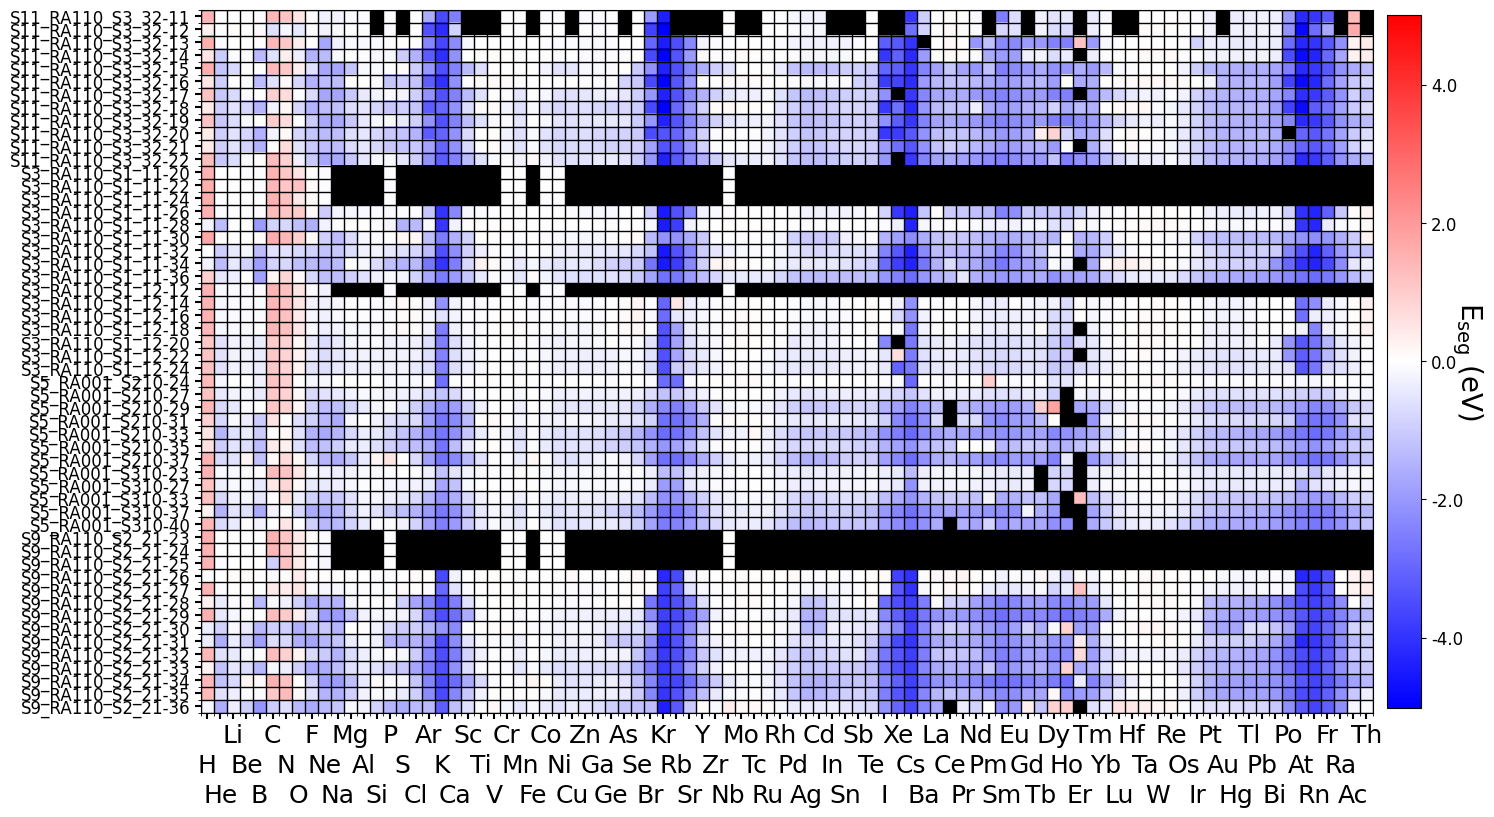

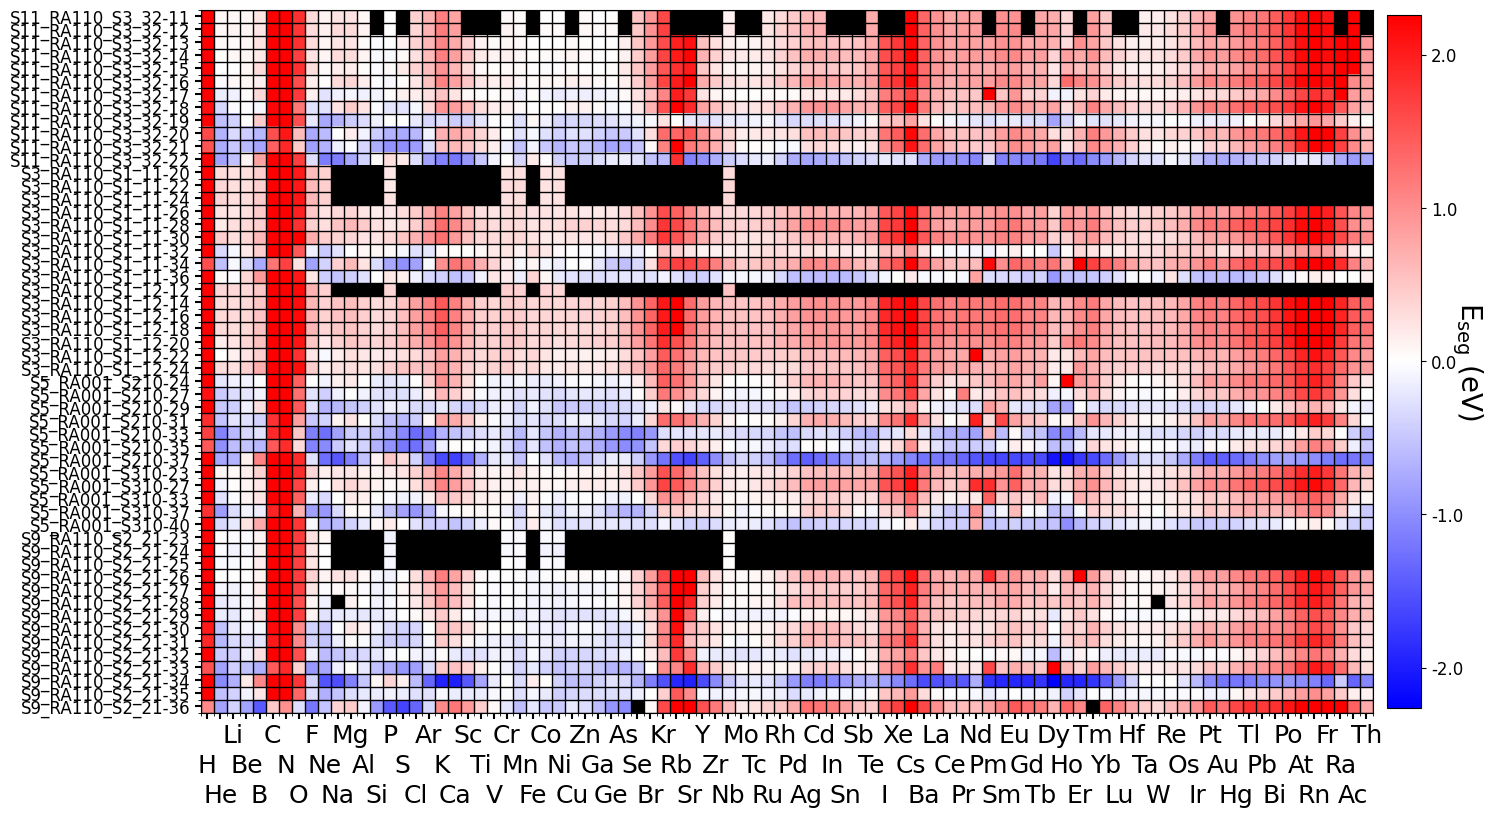

In [3]:
import matplotlib.transforms as mtransforms
# Plot the pivot table for E_seg
fig, axs = plot_pivot_table(df.pivot_table(values='E_seg', index='GB_site', columns='Z'))

# Ensure axs is iterable (in case a single axis is returned)
for ax in np.atleast_1d(axs):
    # Get current xtick values and build new labels
    xticks = ax.get_xticks()
    new_labels = [get_element_symbol(tick+1) for tick in xticks]
    ax.set_xticklabels(new_labels)
    
    # Now offset the tick labels vertically in a repeating pattern (3 rows)
    # Here, we apply a vertical translation (in axis coordinate units) that depends on the index modulo 3.
    for i, label in enumerate(ax.get_xticklabels()):
        # Determine the vertical offset: adjust the multiplier (e.g., 0.05) as needed
        offset_amount = 0.3 * (i % 3)
        # Create a translation transform in display units using the figure's dpi scaling
        offset = mtransforms.ScaledTranslation(0, -offset_amount, ax.figure.dpi_scale_trans)
        # Add the offset to the current transform of the label
        label.set_transform(label.get_transform() + offset)

# Do the same for E_seg_unrel plot
fig, axs = plot_pivot_table(df.pivot_table(values='E_seg_unrel', index='GB_site', columns='Z'))

for ax in np.atleast_1d(axs):
    xticks = ax.get_xticks()
    new_labels = [get_element_symbol(tick+1) for tick in xticks]
    ax.set_xticklabels(new_labels)
    
    for i, label in enumerate(ax.get_xticklabels()):
        offset_amount = 0.3 * (i % 3)
        offset = mtransforms.ScaledTranslation(0, -offset_amount, ax.figure.dpi_scale_trans)
        label.set_transform(label.get_transform() + offset)

# Publication-Quality Figures

This section generates the figures used in the manuscript. Each figure is carefully formatted with publication-standard sizing, fonts, and styling to ensure clarity and professional presentation.

The figures are automatically saved to the `./Figures` directory with high resolution (300 DPI) for publication submission.

## Figure 2: Voronoi Volume vs Atomic Number

This figure shows how the Voronoi volume (atomic volume) varies across the periodic table for solutes in Fe BCC bulk. 

**Scientific Significance**:
- **Voronoi volume**: Measures the space occupied by each atom based on its local environment
- **Size mismatch effect**: Larger deviations from Fe's Voronoi volume (11.35 Ų) indicate stronger size mismatch
- **Segregation correlation**: Elements with significant size mismatch often show stronger segregation tendencies

This property serves as a key descriptor for predicting segregation behavior.

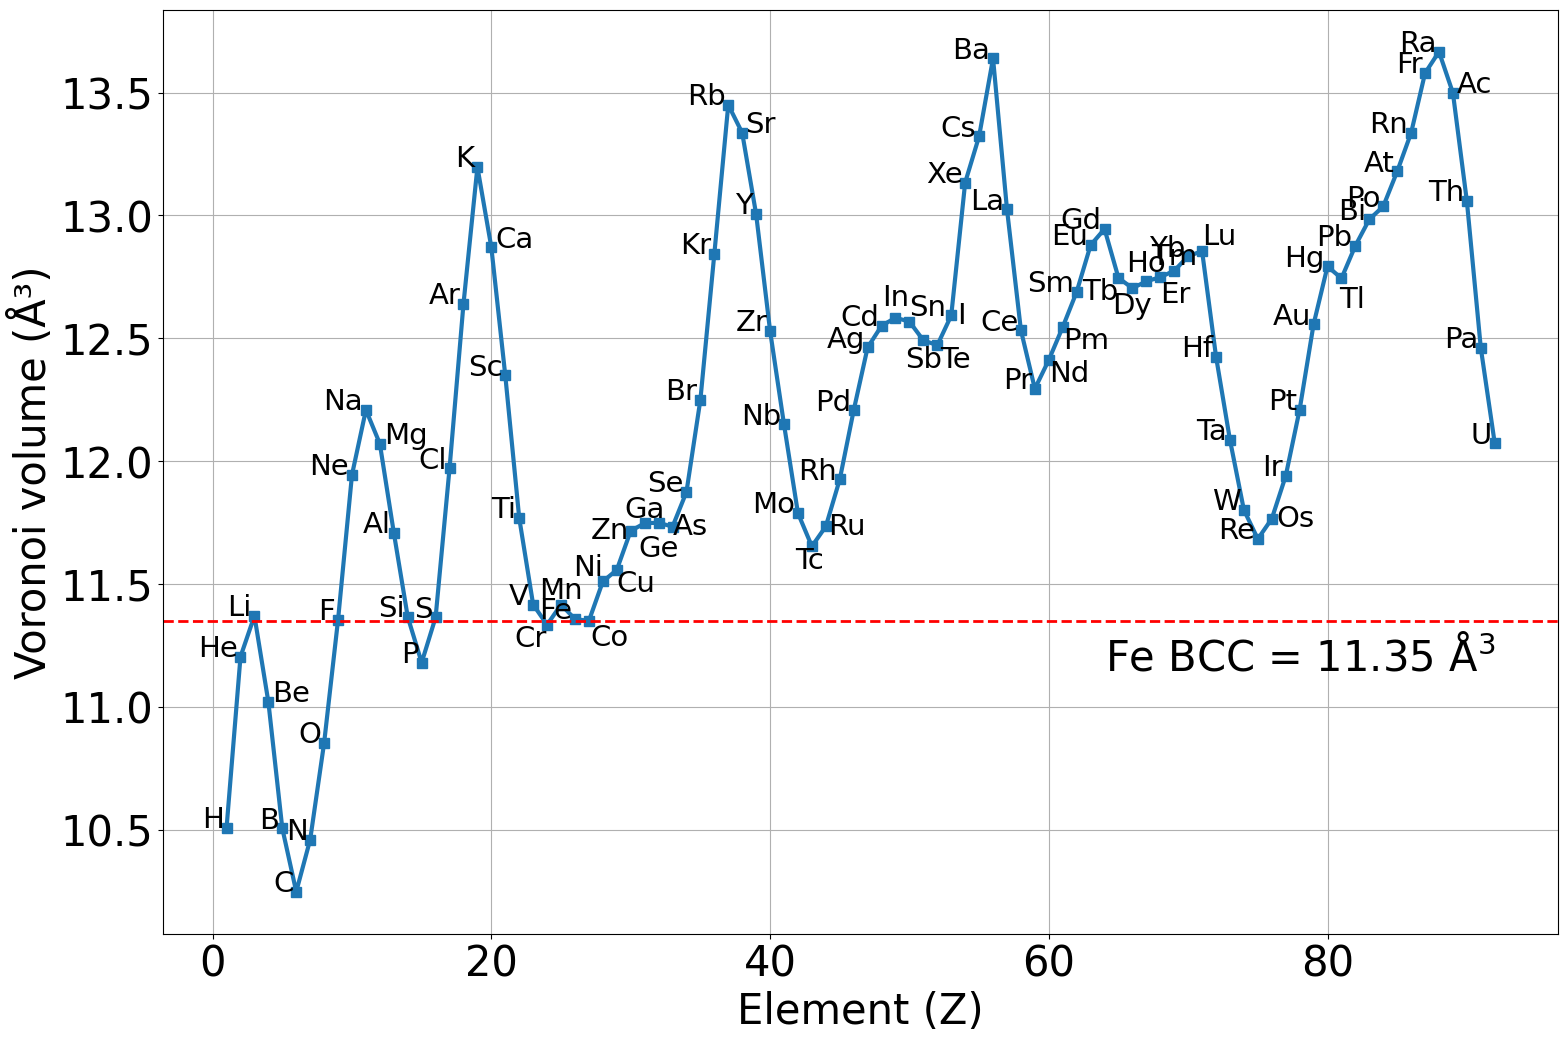

In [ ]:
column = "vvol"
# Plotting column against 'Z'
plt.figure(figsize=(18, 12))
plt.plot(bulk_df['Z'], bulk_df[column], marker='s', linewidth = 3, markersize=7)

# Adding a horizontal line
# plt.axhline(y=11.356932331342922, color='r', linestyle='--', label='Fe BCC bulk')
# plt.text(92, 11.356932331342922-0.2, "Fe BCC = 11.35 Å³", fontsize=30, ha='right')

#Labeling points on the plot below each point
element_fontsize = 21
for idx, row in bulk_df.iterrows():
    if row.element == "Mg":
        plt.text(row['Z']+0.3, row[column], row['element'], fontsize=element_fontsize, ha='left')
    elif row.element == "Be":
        plt.text(row['Z']+0.3, row[column], row['element'], fontsize=element_fontsize, ha='left')
    elif row.element == "Ca":
        plt.text(row['Z']+0.3, row[column], row['element'], fontsize=element_fontsize, ha='left')
    elif row.element == "V":
        plt.text(row['Z']-0.3, row[column], row['element'], fontsize=element_fontsize, ha='right')
    elif row.element == "Cr":
        plt.text(row['Z'], row[column], row['element'], fontsize=element_fontsize, va='top', ha="right")
    elif row.element == "Mn":
        plt.text(row['Z'], row[column], row['element'], fontsize=element_fontsize, va='bottom', ha="center")
    elif row.element == "Co":
        plt.text(row['Z']+0.1, row[column]-0.01, row['element'], fontsize=element_fontsize, va='top')
    elif row.element == "Cu":
        plt.text(row['Z'], row[column], row['element'], fontsize=element_fontsize, va='top')
    elif row.element == "Ni":
        plt.text(row['Z'], row[column], row['element'], fontsize=element_fontsize, va='bottom', ha="right")
    elif row.element == "Zn":
        plt.text(row['Z']-0.1, row[column], row['element'], fontsize=element_fontsize, va='center', ha="right")
    elif row.element == "Ga":
        plt.text(row['Z'], row[column], row['element'], fontsize=element_fontsize, va='bottom', ha='center')
    elif row.element == "Ge":
        plt.text(row['Z'], row[column]-0.05, row['element'], fontsize=element_fontsize, va='top', ha='center')
    elif row.element == "As":
        plt.text(row['Z'], row[column], row['element'], fontsize=element_fontsize, ha='left', va="center")
    elif row.element == "Sr":
        plt.text(row['Z']+0.2, row[column], row['element'], fontsize=element_fontsize, ha='left')
    elif row.element == "Tc":
        plt.text(row['Z']-0.2, row[column], row['element'], fontsize=element_fontsize, ha='center', va="top")
    elif row.element == "Ru":
        plt.text(row['Z']+0.2, row[column], row['element'], fontsize=element_fontsize, ha='left', va='center')
    elif row.element == "In":
        plt.text(row['Z'], row[column]+0.05, row['element'], fontsize=element_fontsize, ha='center')
    elif row.element == "Sn":
        plt.text(row['Z'], row[column], row['element'], fontsize=element_fontsize, ha='left', va='bottom')
    elif row.element == "Sb":
        plt.text(row['Z'], row[column]-0.02, row['element'], fontsize=element_fontsize, ha='center', va="top")
    elif row.element == "Te":
        plt.text(row['Z']+0.2, row[column], row['element'], fontsize=element_fontsize, ha='left', va="top")
    elif row.element == "I":
        plt.text(row['Z']+0.4, row[column], row['element'], fontsize=element_fontsize, ha='left', va="center")
    elif row.element == "Nd":
        plt.text(row['Z'], row[column], row['element'], fontsize=element_fontsize, ha='left', va='top')
    elif row.element == "Pm":
        plt.text(row['Z'], row[column], row['element'], fontsize=element_fontsize, ha='left', va='top')
    elif row.element == "Tb":
        plt.text(row['Z'], row[column], row['element'], fontsize=element_fontsize, ha='right', va="top")
    elif row.element == "Dy":
        plt.text(row['Z'], row[column]-0.015, row['element'], fontsize=element_fontsize, ha='center', va="top")
    elif row.element == "Ho":
        plt.text(row['Z'], row[column]+0.015, row['element'], fontsize=element_fontsize, ha='center', va="bottom")
    elif row.element == "Er":
        plt.text(row['Z'], row[column]-0.015, row['element'], fontsize=element_fontsize, ha='left', va="top")
    elif row.element == "Tm":
        plt.text(row['Z'], row[column], row['element'], fontsize=element_fontsize, ha='center', va="bottom")
    elif row.element == "Lu":
        plt.text(row['Z'], row[column], row['element'], fontsize=element_fontsize, ha='left', va="bottom")
    elif row.element == "Os":
        plt.text(row['Z']+0.3, row[column], row['element'], fontsize=element_fontsize, ha='left', va="center")
    elif row.element == "Tl":
        plt.text(row['Z']-0.2, row[column]-0.03, row['element'], fontsize=element_fontsize, va='top')
    elif row.element == "Ac":
        plt.text(row['Z']+0.3, row[column], row['element'], fontsize=element_fontsize, ha='left')
    else:
        plt.text(row['Z']-0.2, row[column], row['element'], fontsize=element_fontsize, ha='right')

# Adding labels, title, and grid
plt.xlabel("Element (Z)", fontsize=30)
plt.ylabel("Voronoi volume (Å³)", fontsize=30)
# plt.title(columnvs Atomic Number (Z)", fontsize=24)
plt.grid(True)
# Adjusting tick size
plt.tick_params(axis='x', labelsize=30)  # Adjust x-tick label size
plt.tick_params(axis='y', labelsize=30)  # Adjust x-tick label size
plt.axhline(11.35, color='red', linestyle='--', linewidth=2)
plt.text(64, 11.35 - 0.2, r"Fe BCC = 11.35 $\rm{\AA}^3$", color='k', fontsize=30)

plt.savefig(f"{fig_savepath}/Figure2.jpg", dpi=300, bbox_inches='tight', pad_inches=0.1)

### Plot Voronoi Volume Across Periodic Table

This cell creates a detailed line plot showing Voronoi volume trends:

**Plot Construction**:
1. **Main line plot**: Shows Voronoi volume vs atomic number (Z) with markers
2. **Reference line**: Horizontal dashed red line at 11.35 ų (Fe BCC bulk value)
3. **Element labels**: Manual placement of each element symbol near its data point
   - Carefully positioned to avoid overlaps
   - Conditional positioning based on local crowding

**Label Positioning Strategy**:
- Most labels are right-aligned and offset left
- Special cases (overlapping elements) get custom positioning with specific `ha` (horizontal alignment) and `va` (vertical alignment) parameters
- Examples: Cr/Mn/Co/Ni are tightly spaced, so each gets unique positioning

**Key Observations from the Plot**:
- **Alkali/alkaline earth metals** (left side): Very large Voronoi volumes (>20 Ų)
- **Transition metals** (middle): Moderate volumes, close to Fe
- **Lanthanides**: Show decreasing trend (lanthanide contraction)
- **Period effects**: Clear periodic patterns visible

The plot is saved as `Figure2.jpg` at 300 DPI with tight bounding box.


## Figure 3: Minimum Segregation Energy vs Element

This figure identifies the most favorable (most negative) segregation energy for each element across all studied GB sites.

**Key Concept**:
- For each element, we find `min(E_seg)` - the lowest segregation energy among all GB sites
- This represents the "best case" segregation behavior for that element
- Negative values indicate at least one GB site where segregation is thermodynamically favorable

**Practical Implications**:
- **Strong segregators** (large negative min E_seg): Will readily segregate to GBs, potentially improving or degrading properties
- **Weak segregators** (near zero or positive): Remain mostly in bulk, minimal GB decoration
- **Excluded elements** (highlighted in yellow): Not calculated due to computational/physical constraints

This analysis helps identify which alloying elements are most likely to affect GB properties in Fe-based alloys.

### Generate Minimum Segregation Energy Plot

This cell creates a sophisticated visualization using the custom `plot_minEseg_prop_vs_Z` function:

**Data Filtering**:
- Only includes elements with `E_seg < 0` (favorable segregation somewhere)
- Excludes certain elements (Z = [1,2,4,5,6,7,8,14,15,16]) due to:
  - Computational challenges (very light elements)
  - Physical instability in Fe matrix
  - These are highlighted in yellow on the plot

**Plot Features**:
1. **Y-axis**: Minimum segregation energy (`min(E_seg)`) in eV
2. **X-axis**: Atomic number (Z), with shifted element labels for clarity
3. **Marker differentiation**: Different markers for each GB type
4. **Highlighted regions**: Yellow bands show excluded elements

**Interpretation Guide**:
- **Mo, W, Nb**: Strongest segregators (most negative E_seg)
- **Group trend**: Generally, larger atoms and certain transition metals segregate more strongly
- **Multiple data points per element**: Shows segregation varies across different GB types

The figure is saved as `minEseg_perGB_vs_Z.png` at 300 DPI for publication quality.


/root/github_dev/HTSegregation_PyironWorkflow_Demonstrator/FeGB_PtableSeg/plotters.py:299: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nsmallest(1, Eseg_col).iloc[0])
/root/github_dev/HTSegregation_PyironWorkflow_Demonstrator/FeGB_PtableSeg/plotters.py:299: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nsmallest(1, Eseg_col).iloc[0])
/root/github_dev/HTSegregation_PyironWorkflo

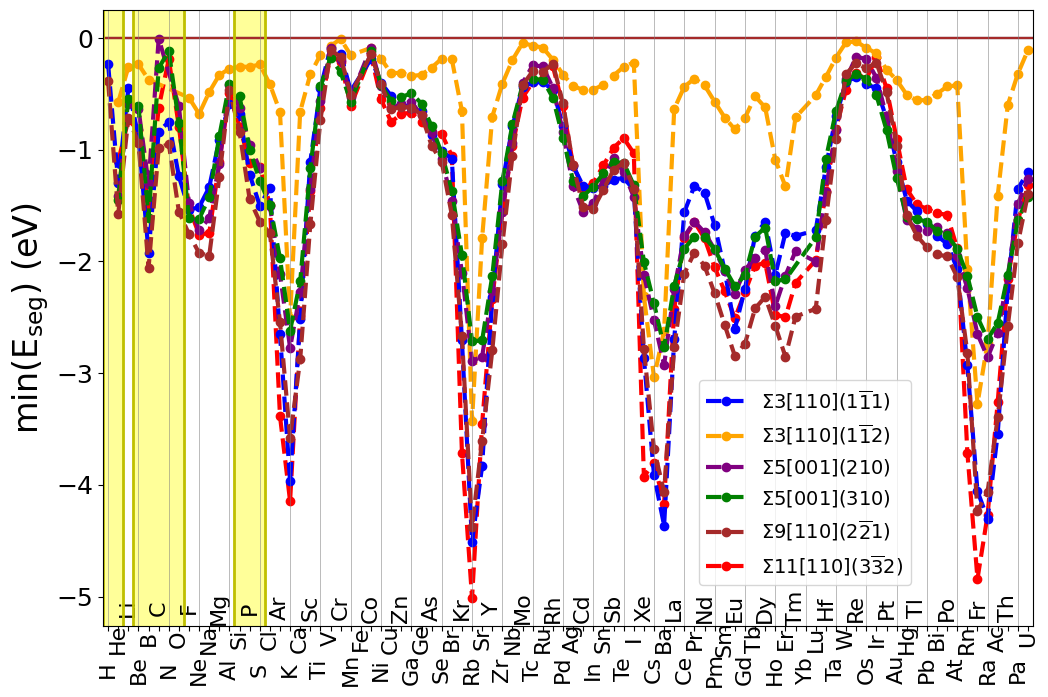

In [ ]:
from FeGB_PtableSeg.plotters import plot_minEseg_prop_vs_Z
exclude_Z = [1,2,4,5,6,7,8,14,15,16]
fig = plot_minEseg_prop_vs_Z(df[df["E_seg"]<0],
                        y_prop="E_seg",
                      x_prop="Z",
                      ylabel=r"$\rm{min}(E_{\rm{seg}})$ (eV)",
                      figsize=(12, 8),
                      shift_xticks=True,
                      xlabel_fontsize=24,
                      xtick_yshift = -0.045,
                      ylabel_fontsize=24,
                      xtick_fontsize=16,
                      ytick_fontsize=18,
                      legend_fontsize=14,
                      highlight_Z_list=exclude_Z,
                      highlight_region_kwargs=dict(color="yellow", alpha=0.4),
                      highlight_region_line_kwargs=dict(color="y", linewidth=2),
                      )

plt.savefig(f"{fig_savepath}/minEseg_perGB_vs_Z.png", dpi=300, bbox_inches='tight', pad_inches=0.1)

## Figure 4 
### Maximum segregation binding vs Voronoi volume in bulk

In [ ]:
mineseg_df = []
# Looping over each unique "GB" group
for idx, (gb, group) in enumerate(df.dropna(subset=["E_seg"]).groupby("GB")):
    # For each "GB" group, group by "element" and find the minimum "Eseg"
    min_eseg_per_element = group.groupby("element").apply(lambda x: x.nsmallest(1, 'E_seg').iloc[0])
    min_eseg_per_element = min_eseg_per_element[min_eseg_per_element['E_seg'] <= 0]
    min_eseg_per_element = min_eseg_per_element.reset_index(drop=True).merge(bulk_df[["vvol", "element"]], on = "element")
    mineseg_df.append(min_eseg_per_element)
mineseg_df = pd.concat(mineseg_df)
# vertical Fe line at Fe VorVol
# Get the Voronoi volume for Fe from bulk_df
fe_vvol = bulk_df[bulk_df["element"] == "Fe"].vvol.values[0]

# Filter mineseg_df for rows where 'vvol' is within 0.2 of Fe's Voronoi volume
filtered_mineseg_df = mineseg_df[(mineseg_df["vvol"] >= fe_vvol - 0.2) & (mineseg_df["vvol"] <= fe_vvol + 0.2)]

# Display the filtered rows
filtered_mineseg_df[["element", "GB", "E_seg", "vvol"]]


/tmp/ipykernel_21566/798522665.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_eseg_per_element = group.groupby("element").apply(lambda x: x.nsmallest(1, 'E_seg').iloc[0])
/tmp/ipykernel_21566/798522665.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_eseg_per_element = group.groupby("element").apply(lambda x: x.nsmallest(1, 'E_seg').iloc[0])
/tmp/ipykernel_21566/798522665.py:5: FutureWarning: DataFram

element               GB     E_seg    vvol
17      Co  S11_RA110_S3_32 -0.154494  11.351
18      Cr  S11_RA110_S3_32 -0.214218  11.335
20      Cu  S11_RA110_S3_32 -0.753652  11.558
24       F  S11_RA110_S3_32 -1.518137  11.355
29      He  S11_RA110_S3_32 -1.102779  11.205
..     ...              ...       ...     ...
50      Ni   S9_RA110_S2_21 -0.416380  11.511
53       P   S9_RA110_S2_21 -1.445304  11.181
67       S   S9_RA110_S2_21 -1.643592  11.365
71      Si   S9_RA110_S2_21 -0.840507  11.367
84       V   S9_RA110_S2_21 -0.110203  11.417

[72 rows x 4 columns]

/tmp/ipykernel_7861/3665014128.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nsmallest(1, "E_seg").iloc[0])
/tmp/ipykernel_7861/3665014128.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nsmallest(1, "E_seg").iloc[0])
/tmp/ipykernel_7861/3665014128.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a futu

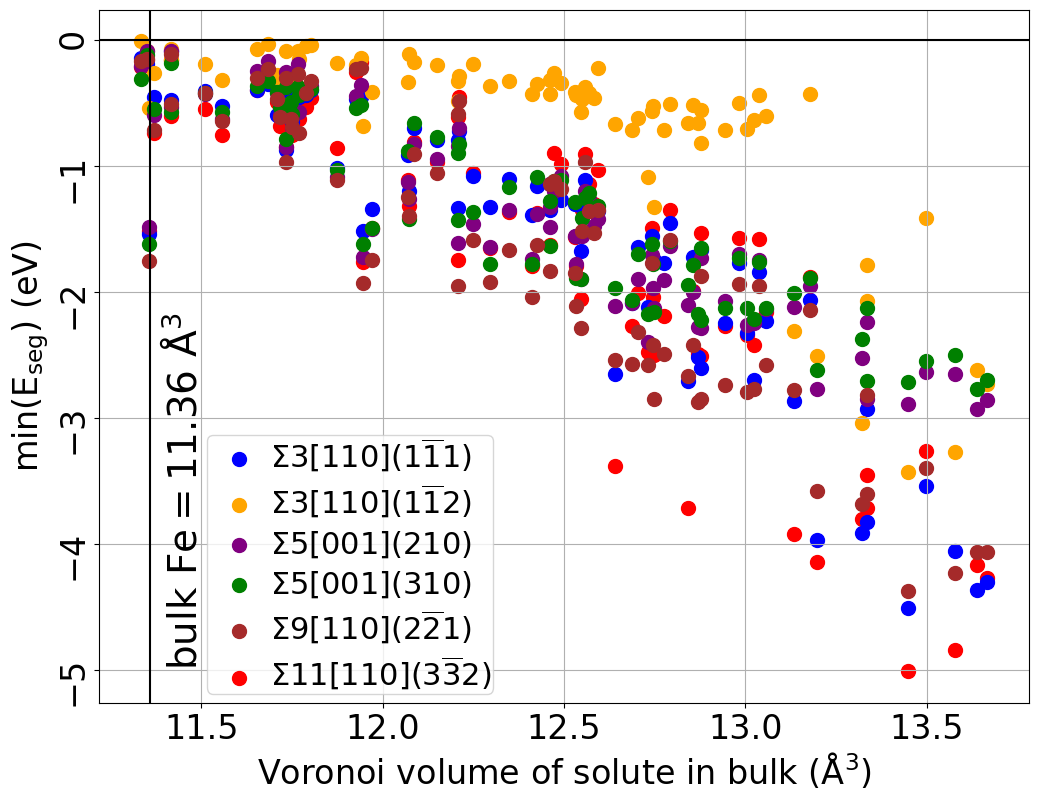

In [4]:
exclude_Z = [1, 2, 4, 5, 6, 7, 8, 14, 15, 16]

# 3) Begin plotting
fig, ax1 = plt.subplots(figsize=(12, 9))
gb_legends = []

for idx, (gb, group) in enumerate(df.dropna(subset=["E_seg"]).groupby("GB")):
    # a) find the minimum E_seg ≤ 0 for each element
    min_eseg_per_element = (
        group
        .groupby("element")
        .apply(lambda x: x.nsmallest(1, "E_seg").iloc[0])
        .reset_index(drop=True)
    )
    min_eseg_per_element = min_eseg_per_element[min_eseg_per_element["E_seg"] <= 0]
    min_eseg_per_element = min_eseg_per_element.merge(
        bulk_df[["vvol", "element"]], on="element"
    )

    # b) map symbol → Z, then drop any row whose Z is in exclude_Z
    min_eseg_per_element = min_eseg_per_element[
        ~min_eseg_per_element["Z"].isin(exclude_Z)
    ]

    # c) now plot the remaining points
    x_values = min_eseg_per_element["vvol"]
    y_values = min_eseg_per_element["E_seg"]

    scatter = ax1.scatter(
        x_values,
        y_values,
        color=custom_colors[gb],
        marker="o",
        s=100,
    )
    gb_legends.append((scatter, f"{gb_latex_dict[gb]}"))

# rotate the legend entries if needed
gb_legends.append(gb_legends.pop(0))

# axis labels, lines, legend, etc.
ax1.set_ylabel(r"min$(\rm{E}_{\rm{seg}})$ (eV)", fontsize=24)
ax1.set_xlabel(r"Voronoi volume of solute in bulk ($\rm{\AA}^3$)", fontsize=24)
ax1.tick_params(axis="y", labelsize=24, rotation=90)
ax1.tick_params(axis="x", labelsize=24)
ax1.axhline(0, color="k")
fe_vvol = bulk_df.loc[bulk_df["element"] == "Fe", "vvol"].values[0]
ax1.axvline(fe_vvol, color="k")
ax1.text(
    fe_vvol + 0.15,
    -5,
    rf"$\mathrm{{bulk\ Fe}} = {fe_vvol:.2f}\ \mathrm{{\AA}}^3$",
    va="bottom",
    ha="right",
    rotation="vertical",
    fontsize=28,
)
ax1.grid(which="major")

ax1.legend(
    *zip(*gb_legends),
    loc="center left",
    bbox_to_anchor=(0.1, 0.2),
    fontsize=22,
    handletextpad=0.01,
    borderpad=0.05,
    labelspacing=0.3,)
# save
plt.savefig(f"{fig_savepath}/Figure4.jpg", dpi=300,
            bbox_inches="tight", pad_inches=0.1)

## Figure 5

In [5]:
from scipy.stats import pearsonr, spearmanr

VorVol_Eseg_corrlist = []
magmom_Eseg_corrlist = []
VorVol_magmom_corrlist = []
element_str_list = []

for element_str, element_df in df.groupby("element"):
    element_df = element_df[element_df["VorNN_tot_vol"] < 40]
    element_df = element_df.dropna(subset="E_seg")
    try:
        pearson_corr, _ = pearsonr(element_df.VorNN_tot_vol.values, element_df.E_seg.values)
        spearman_corr, _ = spearmanr(element_df.VorNN_tot_vol.values, element_df.E_seg.values)
    except ValueError:
        pearson_corr, spearman_corr = np.nan, np.nan
    VorVol_Eseg_corrlist.append((pearson_corr, spearman_corr))
    
    try:
        pearson_corr, _ = pearsonr(element_df.magmom_solute.values, element_df.E_seg.values)
        spearman_corr, _ = spearmanr(element_df.magmom_solute.values, element_df.E_seg.values)
    except ValueError:
        pearson_corr, spearman_corr = np.nan, np.nan
    magmom_Eseg_corrlist.append((pearson_corr, spearman_corr))
    
    try:
        pearson_corr, _ = pearsonr(element_df.VorNN_tot_vol.values, element_df.magmom_solute.values)
        spearman_corr, _ = spearmanr(element_df.VorNN_tot_vol.values, element_df.magmom_solute.values)
    except ValueError:
        pearson_corr, spearman_corr = np.nan, np.nan
    VorVol_magmom_corrlist.append((pearson_corr, spearman_corr))
    
    element_str_list.append(element_str)

corr_r_vvol_eseg = dict(zip(element_str_list, VorVol_Eseg_corrlist))
corr_r_magmom_Eseg = dict(zip(element_str_list, magmom_Eseg_corrlist))
corr_vvol_magmom = dict(zip(element_str_list, VorVol_magmom_corrlist))

bulk_df["pearson_r_vvol_eseg"] = [corr_r_vvol_eseg[row.element][0] if row.element not in ["Fe", "Yb"] else np.nan for i, row in bulk_df.iterrows()]
bulk_df["spearman_r_vvol_eseg"] = [corr_r_vvol_eseg[row.element][1] if row.element not in ["Fe", "Yb"] else np.nan for i, row in bulk_df.iterrows()]
bulk_df["pearson_r_magmom_Eseg"] = [corr_r_magmom_Eseg[row.element][0] if row.element not in ["Fe", "Yb"] else np.nan for i, row in bulk_df.iterrows()]
bulk_df["spearman_r_magmom_Eseg"] = [corr_r_magmom_Eseg[row.element][1] if row.element not in ["Fe", "Yb"] else np.nan for i, row in bulk_df.iterrows()]
bulk_df["pearson_r_vvol_magmom"] = [corr_vvol_magmom[row.element][0] if row.element not in ["Fe", "Yb"] else np.nan for i, row in bulk_df.iterrows()]
bulk_df["spearman_r_vvol_magmom"] = [corr_vvol_magmom[row.element][1] if row.element not in ["Fe", "Yb"] else np.nan for i, row in bulk_df.iterrows()]

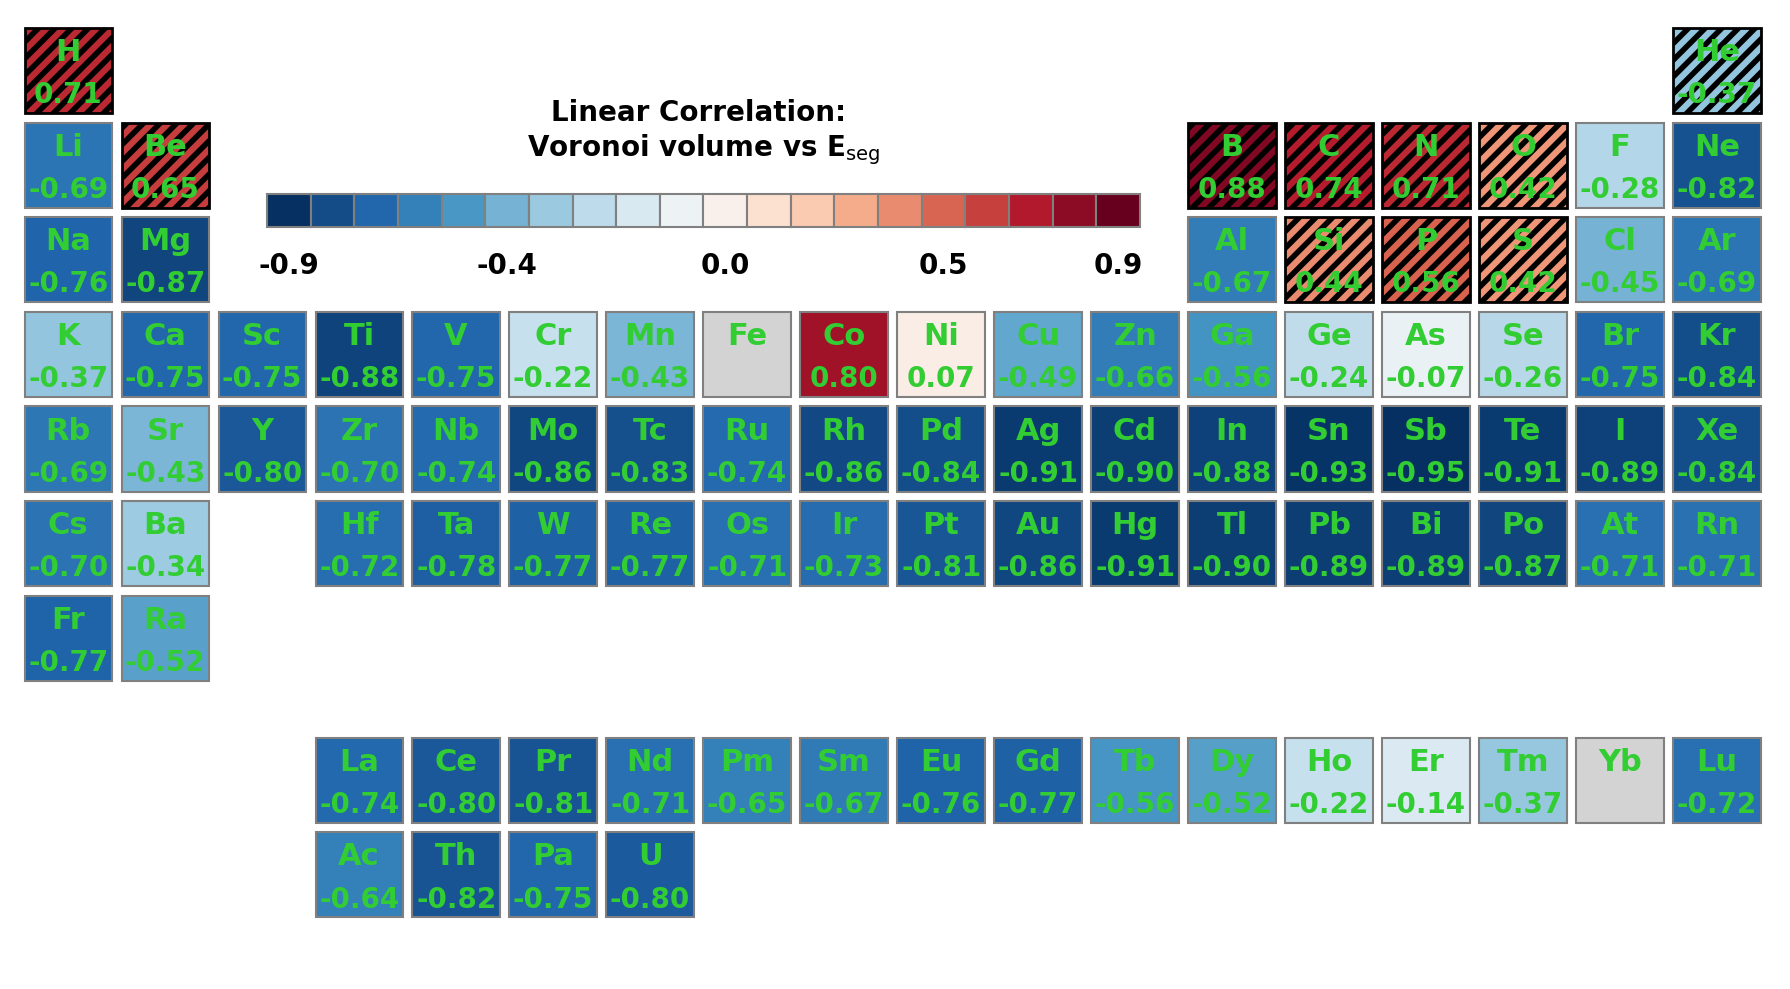

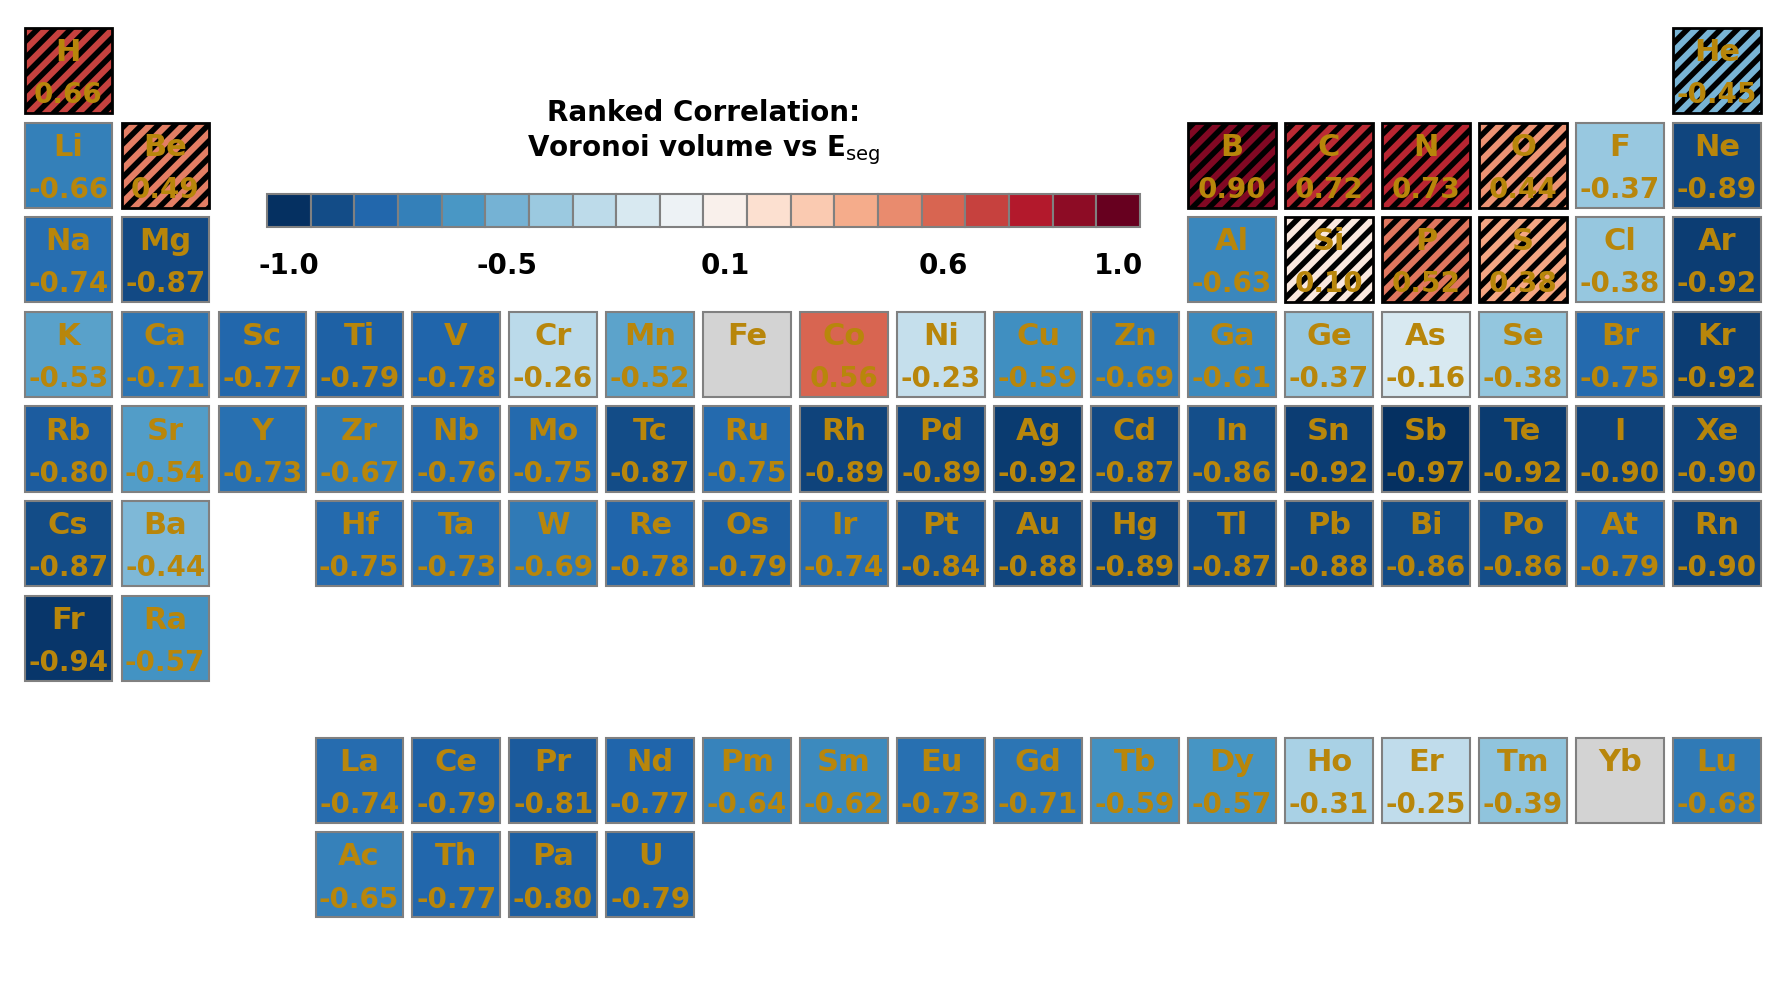

In [ ]:
import matplotlib.cm as cm
from FeGB_PtableSeg.plotters import periodic_table_plot

# Also try pearson_r_magmom_Eseg, pearson_r_vvol_magmom to see their correlations too!

fig, ax = periodic_table_plot(bulk_df,
                    "pearson_r_vvol_eseg",
                    center_cm_zero=True,
                    cmap = cm.RdBu_r,
                    property_name=r"Linear Correlation: " + "\n"+r"Voronoi volume vs E$_{\rm seg}$",
                    element_font_color="limegreen",
                    highlight_Z_list=[1, 2, 4, 5, 6, 7, 8, 14, 15, 16],
                    hatch_linewidth=4,
                    )
#fig.savefig(f"{fig_savepath}/Figures/Ptable_Correlation_Plots/Ptable_LinearCorrelation_VorVol_Eseg.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
fig.savefig(f"{fig_savepath}/Figure5.jpg", dpi=300, bbox_inches='tight', pad_inches=0.1)

fig, ax = periodic_table_plot(bulk_df,
                    "spearman_r_vvol_eseg",
                    center_cm_zero=True,
                    cmap = cm.RdBu_r,
                    property_name=r"Ranked Correlation:" + "\n"+r"Voronoi volume vs E$_{\rm seg}$",
                    highlight_Z_list=[1, 2, 4, 5, 6, 7, 8, 14, 15, 16],
                    hatch_linewidth=4)
#fig.savefig(f"{fig_savepath}/Figures/Ptable_Correlation_Plots/Ptable_RankCorrelation_VorVol_Eseg.png", dpi=300, bbox_inches='tight', pad_inches=0.1)

## Preparation for spectral plots

This reshapes the df to contain the site-spectra for both segregation energy and cohesive effects in rows

1 row -> 1 GB+element combination

In [ ]:
df_spectra_lst = []

for gb, gb_df in df[df["dist_GB"] < 3.5].groupby("GB"):
    for element, element_df in gb_df.groupby("element"):
        element_df = element_df.dropna(subset=["structure"])
        element_df = element_df.reset_index(drop=True)
        unique_site_spectra = element_df.E_seg.values
        element_seg_spectra = []
        element_coh_min_ANSBO_spectra =[]
        element_coh_min_wsep_spectra = []
        element_df["eta_min_R_ANSBO"] = element_df.R_DDEC6_ANSBO.values - 1
        element_df["eta_min_R_Wsep_RGS"] = element_df.R_Wsep_RGS.values - 1
        for _, site_row in element_df.iterrows():
            element_seg_spectra += [site_row.E_seg] * int(site_row.site_multiplicity)
            element_coh_min_ANSBO_spectra += [site_row.eta_min_R_ANSBO] * int(site_row.site_multiplicity)
            element_coh_min_wsep_spectra += [site_row.eta_min_R_Wsep_RGS] * int(site_row.site_multiplicity)
        df_spectra_lst.append([gb,
                           element,
                           element_df.Z.values[0],
                           element_df.site.values,
                           element_df.site_multiplicity.values,
                           element_seg_spectra,
                           unique_site_spectra,
                           element_coh_min_ANSBO_spectra,
                           element_df.eta_min_R_ANSBO.values,
                           element_coh_min_wsep_spectra,
                            element_df.eta_min_R_Wsep_RGS.values])
df_spectra = pd.DataFrame(df_spectra_lst, columns = ["GB",
                                    "element",
                                    "Z",
                                    "unique_sites",
                                    "site_multiplicity",
                                    "full_seg_spectra",
                                    "unique_seg_spectra",
                                    "eta_coh_ANSBO_spectra",
                                    "unique_eta_ANSBO_spectra",
                                    "eta_coh_wsep_spectra",
                                    "unique_eta_wsep_spectra"])

## Figure 6

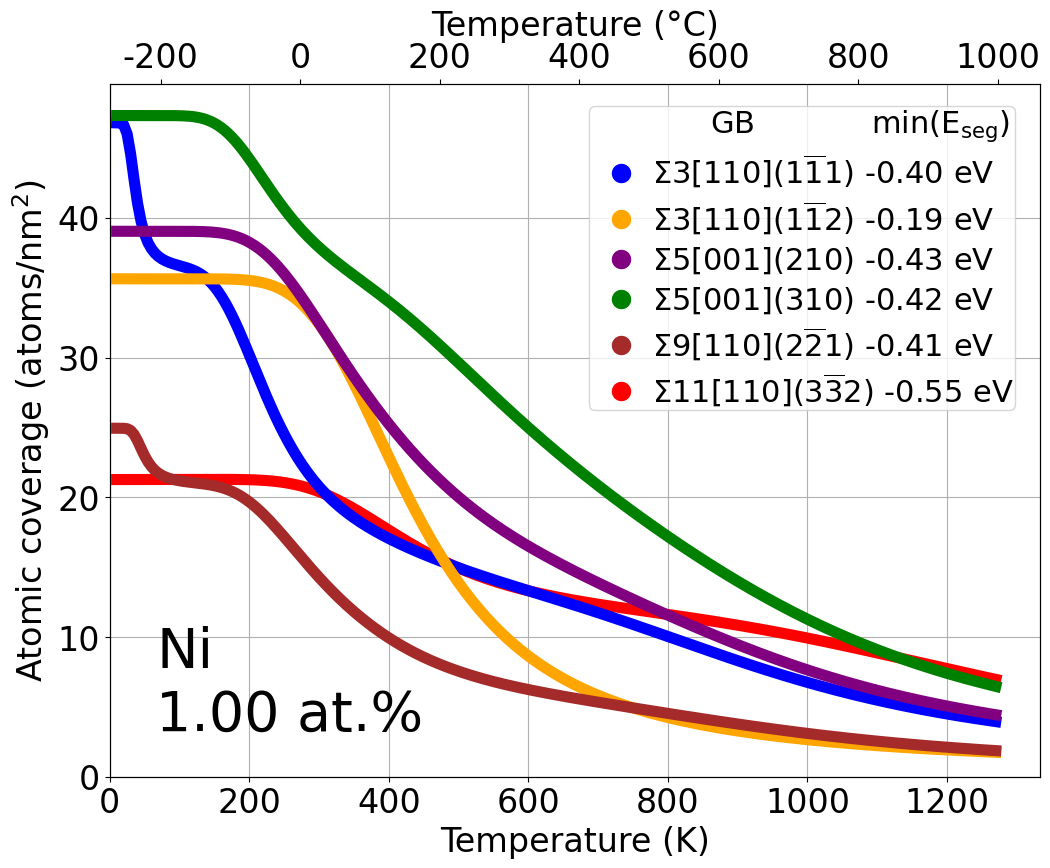

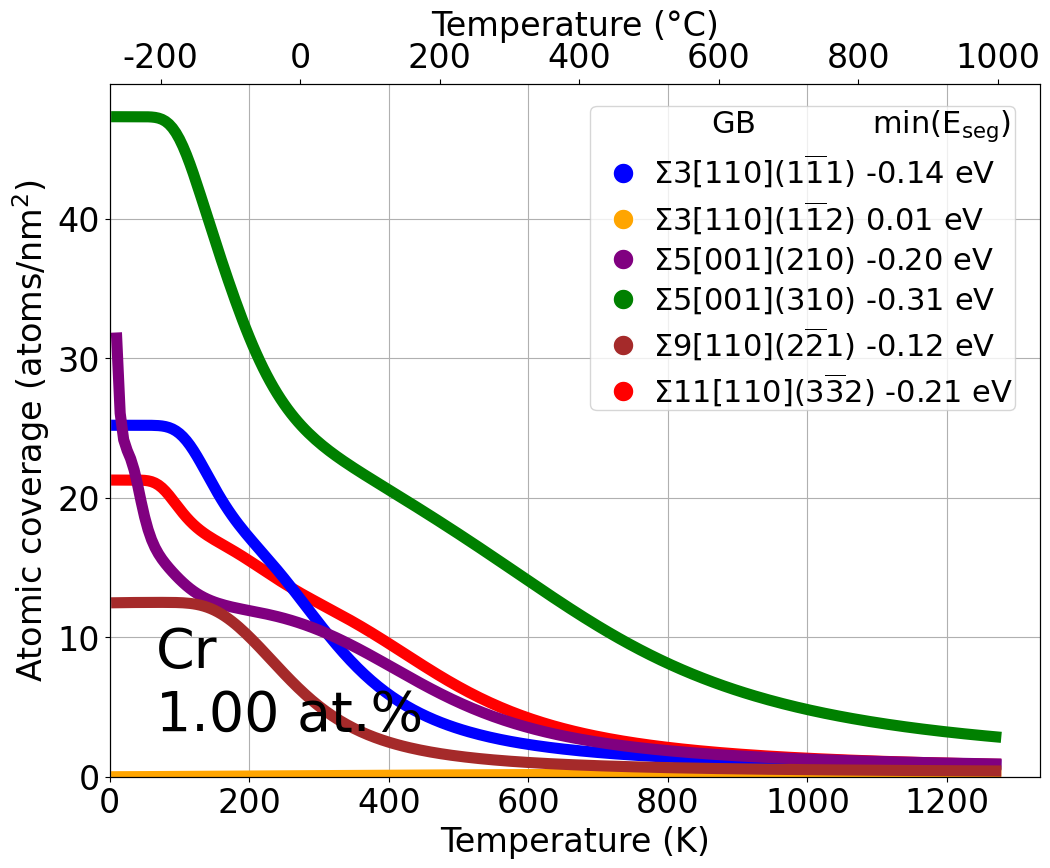

In [ ]:
from FeGB_PtableSeg.plotters import plot_coverage_vs_temperature
#alloy_conc = [0.1, 0.5, 1, 2, 3, 4, 5, 10]
alloy_conc = [1]

temperature_range = np.arange(10, 1273, 5)
elements = ["Ni", "Cr"]
for conc in alloy_conc:
    if conc == 1:
        close_fig=False
    else:
        close_fig=True
    for element in elements:
        fig, ax = plot_coverage_vs_temperature(df, df_spectra, conc, temperature_range, element, close_fig=close_fig)
        if element in ["Ni", "Cr"]:
            if element == "Ni":
                fig.savefig(f"{fig_savepath}/Figure6a.jpg", dpi=300, bbox_inches='tight', pad_inches=0.1)
            else:
                fig.savefig(f"{fig_savepath}/Figure6b.jpg", dpi=300, bbox_inches='tight', pad_inches=0.1)

## Figure 7
### Figure 7a: Wsep in Rice-Wang theory

In [ ]:
from utils.plotters.grid_plots import plot_pivot_table

#fig, axs = plot_pivot_table(df.pivot_table(values='E_seg', index='GB_site', columns='Z'))

# This bit deals with the structure-sites that we don't want to include due to us excluding sites that are too far away in some elements deliberately
ids_to_drop = ['S11_RA110_S3_32_11', 'S11_RA110_S3_32_12', 'S3_RA110_S1_11_20', 'S3_RA110_S1_11_22', 'S3_RA110_S1_11_24', 'S3_RA110_S1_12_12', 'S9_RA110_S2_21_23', 'S9_RA110_S2_21_24', 'S9_RA110_S2_21_25']
df_plot = df.copy()
df_plot = df_plot[~df_plot['GB_site'].isin(ids_to_drop)]
gb_site_Z_Eseg_pivot = df_plot.pivot_table(values='E_seg', index='GB_site', columns='Z')

nan_points = [(index, col) for index in gb_site_Z_Eseg_pivot.index for col in gb_site_Z_Eseg_pivot.columns if np.isnan(gb_site_Z_Eseg_pivot.at[index, col])]
nan_segregation = []
for GB_site, Z in nan_points:
    # print(GB_site, Z)
    nan_segregation.append(("_".join(GB_site.split("_")[:-1])+f"_{int(Z)}"))
nan_segregation = np.unique(nan_segregation)

In [6]:
# y_prop="R_Wsep_RGS" # Adjust this to be Wsep_RGS_min for absolute values
# x_prop="Z"
# plot_df = df[(df["E_seg"] < -0.05) & (df["convergence"] == True) & (df["R_Wsep_RGS"] > -1)].dropna(subset=["E_seg"])
# for gb, group in plot_df.dropna(subset=[y_prop]).groupby("GB"):
#     color = custom_colors.get(gb, 'black')  # Get color for each group, default to 'black' if not found

#     Eseg_col = "E_seg"
#     # For each "GB" group, find the minimum "E_seg"
#     min_eseg_per_element = group.groupby("element").apply(lambda x: x.nsmallest(1, Eseg_col).iloc[0])
#     min_eseg_per_element = min_eseg_per_element[min_eseg_per_element[Eseg_col] <= 0]
#     # Sorting values by 'Z' for consistent plotting
#     min_eseg_per_element = min_eseg_per_element.sort_values(by='Z')
#     #print(min_eseg_per_element[min_eseg_per_element["R_Wsep_RGS"] < 0.2][["job_name", "R_Wsep_RGS", "E_seg"]])
#     # Plotting
#     x_values = min_eseg_per_element[x_prop]
#     y_values = min_eseg_per_element[y_prop]

# #    line1, = ax1.plot(x_values, y_values, color=color, linestyle='--', marker="o", linewidth=3, markersize=6)
# #    ax1.axhline(0, color=color)

/root/github_dev/HTSegregation_PyironWorkflow_Demonstrator/FeGB_PtableSeg/plotters.py:299: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nsmallest(1, Eseg_col).iloc[0])
/root/github_dev/HTSegregation_PyironWorkflow_Demonstrator/FeGB_PtableSeg/plotters.py:299: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nsmallest(1, Eseg_col).iloc[0])
/root/github_dev/HTSegregation_PyironWorkflo

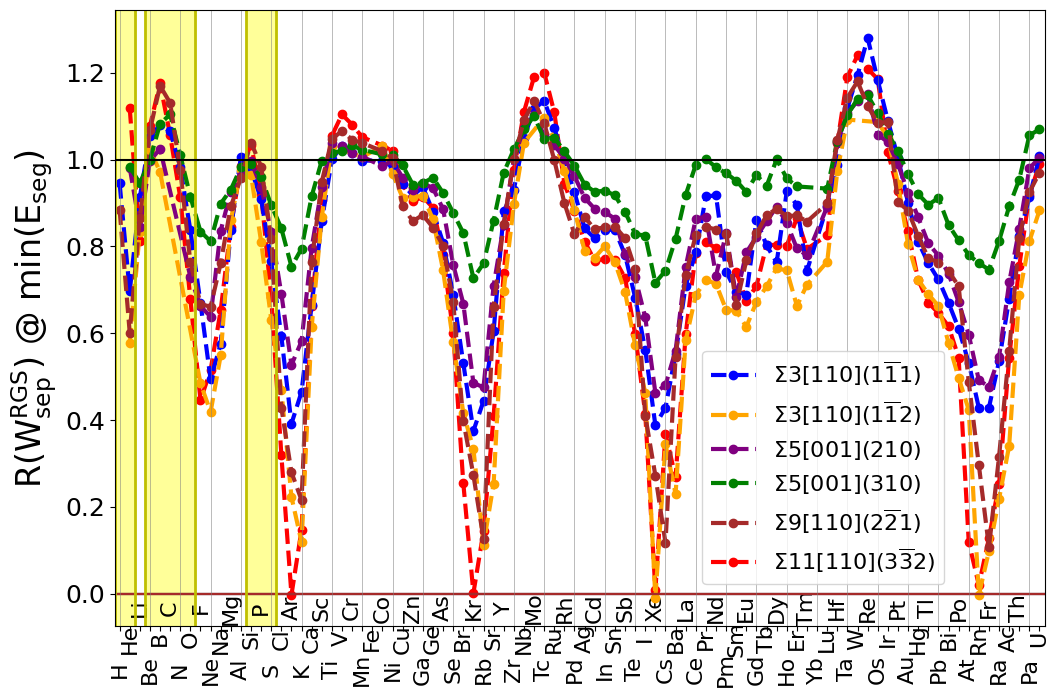

In [ ]:
# 7a Wsep

# There's some weirdness going on with the Tm and Lu surfaces, which we filter out because they are (probably) non-physical
filtered_df = df[
    (df["E_seg"] < -0.05) &
    (df["convergence"] == True) &
    (df["R_Wsep_RGS"] > -1) &
    (
        (~df["element"].isin(["Tm", "Lu"])) | 
        ((df["element"].isin(["Tm", "Lu"])) & (df["R_Wsep_RGS"] > 0.4) & (df["R_Wsep_RGS"] < 1.5))
    )
].dropna(subset=["E_seg"])

exclude_Z = [1,2,4,5,6,7,8,14,15,16]

fig, ax1 = plot_minEseg_prop_vs_Z(filtered_df,
                        y_prop="R_Wsep_RGS", # Adjust this to be Wsep_RGS_min for absolute values
                      x_prop="Z",
                      ylabel=r"R(W$_{\rm{sep}}^{\rm{RGS}})$ @ $\rm{min}(E_{\rm{seg}})$",
                      figsize=(12, 8),
                      shift_xticks=True,
                      xlabel_fontsize=24,
                      xtick_yshift = -0.045,
                      ylabel_fontsize=24,
                      xtick_fontsize=16,
                      ytick_fontsize=18,
                      legend_fontsize=16,
                      highlight_Z_list=exclude_Z,
                      highlight_region_kwargs=dict(color="yellow", alpha=0.4),
                      highlight_region_line_kwargs=dict(color="y", linewidth=2),
                      legend_bbox_to_anchor = (0.62, 0.05))


_ = ax1.axhline(1, color="k", linestyle="-")
fig.savefig(f"{fig_savepath}/Figure7a_feed.png", dpi=300, bbox_inches='tight', pad_inches=0.1)

### Figure 7b: ANSBO in DDEC6 theory

In [7]:
from FeGB_PtableSeg.plotters import plot_minEseg_prop_vs_Z
# 8b ANSBO
fig, ax1 = plot_minEseg_prop_vs_Z(filtered_df,
                        y_prop="R_DDEC6_ANSBO", # Adjust this to be DDEC6_ANSBO_min for absolute values
                      x_prop="Z",
                      ylabel=r"R(ANSBO) @ $\rm{min}(E_{\rm{seg}})$",
                      figsize=(12, 8),
                      shift_xticks=True,
                      xlabel_fontsize=24,
                      xtick_yshift = -0.045,
                      ylabel_fontsize=24,
                      xtick_fontsize=16,
                      ytick_fontsize=18,
                      legend_fontsize=16,
                      highlight_Z_list=exclude_Z,
                      highlight_region_kwargs=dict(color="yellow", alpha=0.4),
                      highlight_region_line_kwargs=dict(color="y", linewidth=2),)
_ = ax1.axhline(1, color="k", linestyle="-")
fig.savefig(f"{fig_savepath}/Figure7b_feed.png", dpi=300, bbox_inches='tight', pad_inches=0.1)

NameError: name 'filtered_df' is not defined

## Figure 8
### Figure 8a

/root/github_dev/HTSegregation_PyironWorkflow_Demonstrator/FeGB_PtableSeg/plotters.py:1423: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nsmallest(1, x_prop).iloc[0])


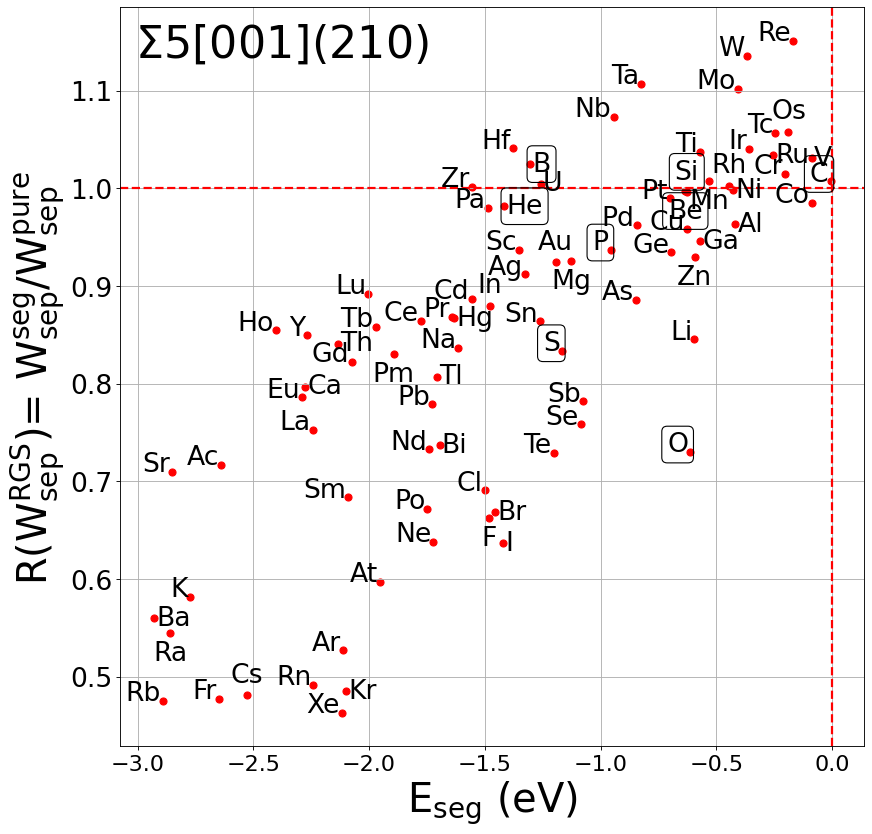

In [ ]:
gb_to_plot = 'S5_RA001_S210'
x_prop = "E_seg"
y_prop = "R_Wsep_RGS"
boxed_Z_list = [1,2,4,5,6,7,8,14,15,16]
# Try any particular GB! Find the appropriate strings from gb_latex_dict.keys()
# ['S5_RA001_S310', 'S5_RA001_S210', 'S11_RA110_S3_32', 'S3_RA110_S1_12', 'S3_RA110_S1_11', 'S9_RA110_S2_21']
# Exclude Tm because of weirdness of result... surface calc likely is wrong
fig, ax = plot_prop_vs_prop_GB(df[(df["convergence"]==True) & (df["element"] != "Tm")],
                            gb_to_plot=gb_to_plot,
                            y_prop=y_prop,
                            x_prop=x_prop,
                            ylabel=r"R(W$_{\rm{sep}}^{\rm{RGS}}$)= W$_{\rm{sep}}^{\rm{seg}}$/W$_{\rm{sep}}^{\rm{pure}}$", 
                            xlabel=r"E$_{\rm{seg}}$ (eV)",
                            custom_colors=custom_colors,
                            gb_latex_dict=gb_latex_dict,
                            label_left=[],
                            label_right=["Ga", "Al", "U", "B", "He", "Ni", "V", "Ru", "Bi", "Ca", "Kr", "I", "Hg", "Tl", "Th", "Ba", "Br"],
                            label_bottom=["Mn", "Be", "Mg", "Ra", "F", "Pm", "Zn"],
                            label_top=["Os", "Rh", "Si", "Au", "Cs", "In"],
                            horizontal_padding=0.002,
                            boxed_Z_list=boxed_Z_list,
                            vertical_padding=0.0005)

#write_path = f"{fig_savepath}/Figures/SegregationEngineering_min_{x_prop}_vs_R_wsep_{gb_to_plot}.png"
fig.savefig(f"{fig_savepath}/Figure8a_feed.png", dpi=300, bbox_inches='tight', pad_inches=0.1)

### Figure 8b

/mnt/c/Users/liger/Koofr/Fe-PtableTrends-Manuscript/Figures/SegregationEngineering_min_E_seg_vs_R_ANSBO_S5_RA001_S210.png


/root/github_dev/HTSegregation_PyironWorkflow_Demonstrator/FeGB_PtableSeg/plotters.py:1423: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nsmallest(1, x_prop).iloc[0])


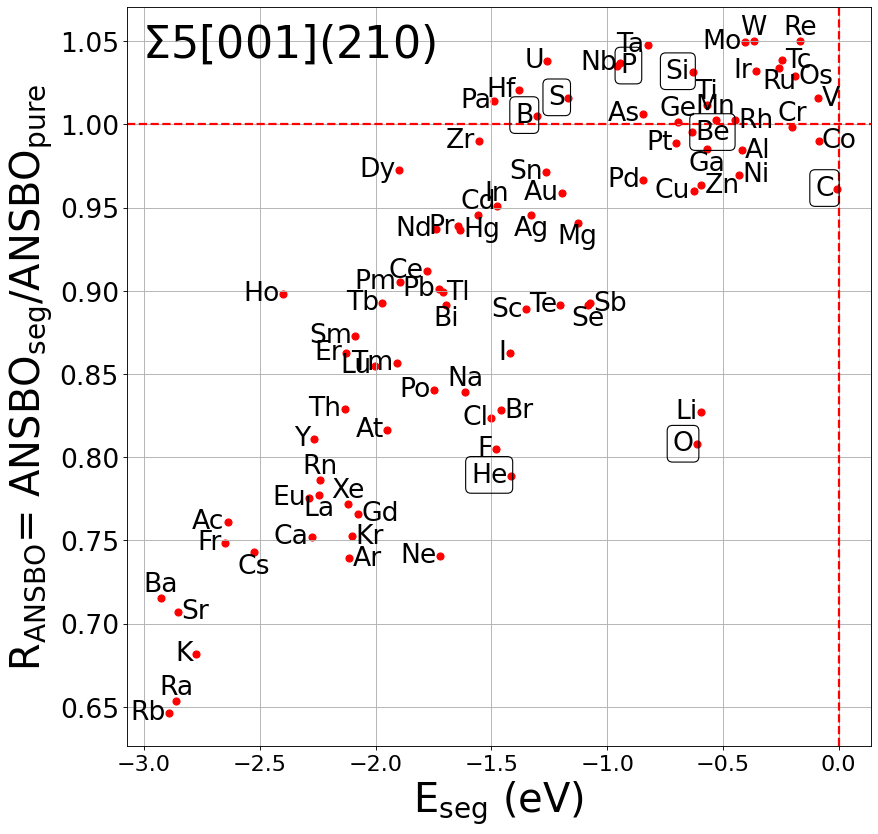

In [ ]:
x_prop = "E_seg"
y_prop = "R_DDEC6_ANSBO"
gb_to_plot = 'S5_RA001_S210'
write_path = f"/mnt/c/Users/liger/Koofr/Fe-PtableTrends-Manuscript/Figures/SegregationEngineering_min_{x_prop}_vs_R_ANSBO_{gb_to_plot}.png"
print(write_path)

fig, ax = plot_prop_vs_prop_GB(df[df["convergence"]==True],
                            gb_to_plot=gb_to_plot,
                            y_prop=y_prop,
                            x_prop=x_prop,
                            ylabel=r"R$_{\rm{ANSBO}}$= ANSBO$_{\rm{seg}}$/ANSBO$_{\rm{pure}}$", 
                            xlabel=r"E$_{\rm{seg}}$ (eV)",
                            custom_colors=custom_colors,
                            gb_latex_dict=gb_latex_dict,
                            label_left=[],
                            label_right=["Tl", "P", "Sb", "Br", "Sr", "Gd", "Hg", "Zn", "Ni", "Be", "Rh", "Tc", "V", "Os", "Al","Co", "Kr", "Ar"],
                            label_bottom=["La", "Ru", "Se", "Mg", "Ag", "Ga", "Cs", "Bi"],
                            label_top=["Na", "Ra", "Xe", "Ti", "Mn", "Ge", "W", "Re", "In", "Cd", "Cr", "Ba", "Rn"],
                            boxed_Z_list=boxed_Z_list,
                            horizontal_padding=0.003,
                            vertical_padding=0.001)#, fig_dir='path/to/save/figures')
fig.savefig(write_path, dpi=300, bbox_inches='tight', pad_inches=0.1)
fig.savefig(f"{fig_savepath}/Figure8b_feed.png", dpi=300, bbox_inches='tight', pad_inches=0.1)

In [ ]:
areas = {}
for GB, GB_df in df.groupby("GB"):
    structure = Structure.from_str(GB_df.iloc[0].structure, fmt="json")
    areas[GB] = structure.volume/structure.lattice.c
df["area"] = df["GB"].map(areas)

## Figure 9

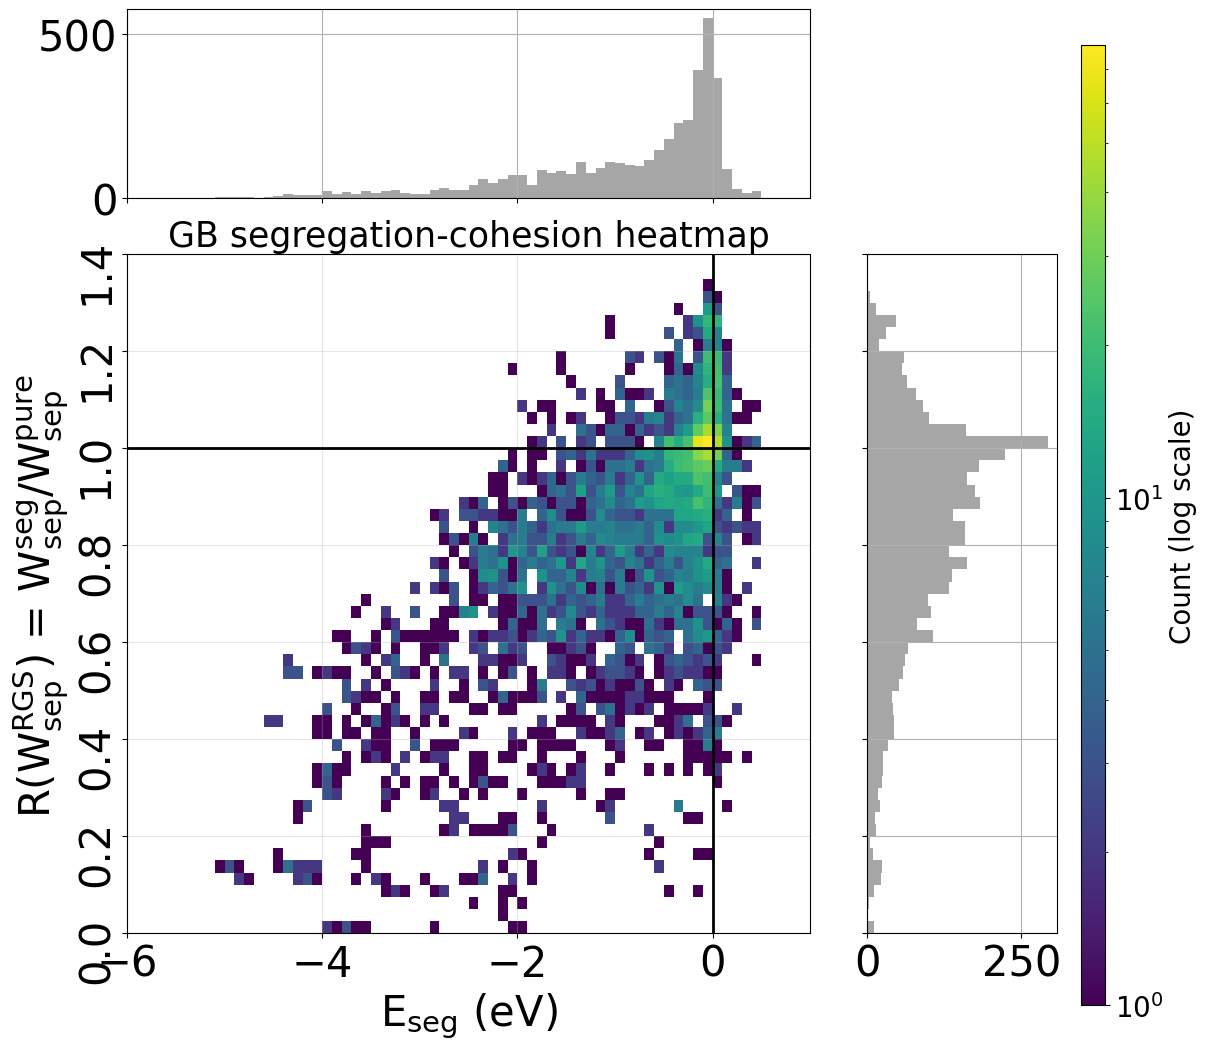

In [ ]:
plot_df = df[df["E_seg"] < 0.5]

fig, ax1 = plot_prop_vs_prop_with_2d_histograms(
    x_values=plot_df.E_seg.values,
    y_values=plot_df.R_Wsep_RGS.values,
    figsize=(12, 12),
    x_label=r"E$_{\rm{seg}}$ (eV)",
    x_label_fontsize=30,
    xtick_fontsize=30,
    y_label=r"R(W$_{\rm{sep}}^{\rm{RGS}}$) = W$_{\rm{sep}}^{\rm{seg}}$/W$_{\rm{sep}}^{\rm{pure}}$ ",
    y_label_fontsize=30,
    ytick_fontsize=30,
    hist_tick_fontsize=30,
    legend_posn=(-0.01, 0.62),
    colorbar_tick_fontsize=20,  # Added colorbar tick font size
    colorbar_size=[0.92, 0.05, 0.02, 0.8],  # Colorbar size [left, bottom, width, height]
    ylims=(0.00, 1.4),
    x_bin_width=0.1,  # Bin width for the histograms
    y_bin_width=0.025)
# Add vertical and horizontal lines
ax1.axhline(1.00, linewidth=2, linestyle="-", c="k")
ax1.axvline(0, linewidth=2, linestyle="-", c="k")

# Set the title to indicate the current GB group
ax1.set_title(f"GB segregation-cohesion heatmap", fontsize=25)
write_path = f"{fig_savepath}/Figures/R_Wsep_vs_Eseg_AllSites_Heatmap.png"
#fig.savefig(write_path, dpi=300, bbox_inches='tight', pad_inches=0.1)
fig.savefig(f"{fig_savepath}/Figure9a_feed.png", dpi=300, bbox_inches='tight', pad_inches=0.1)

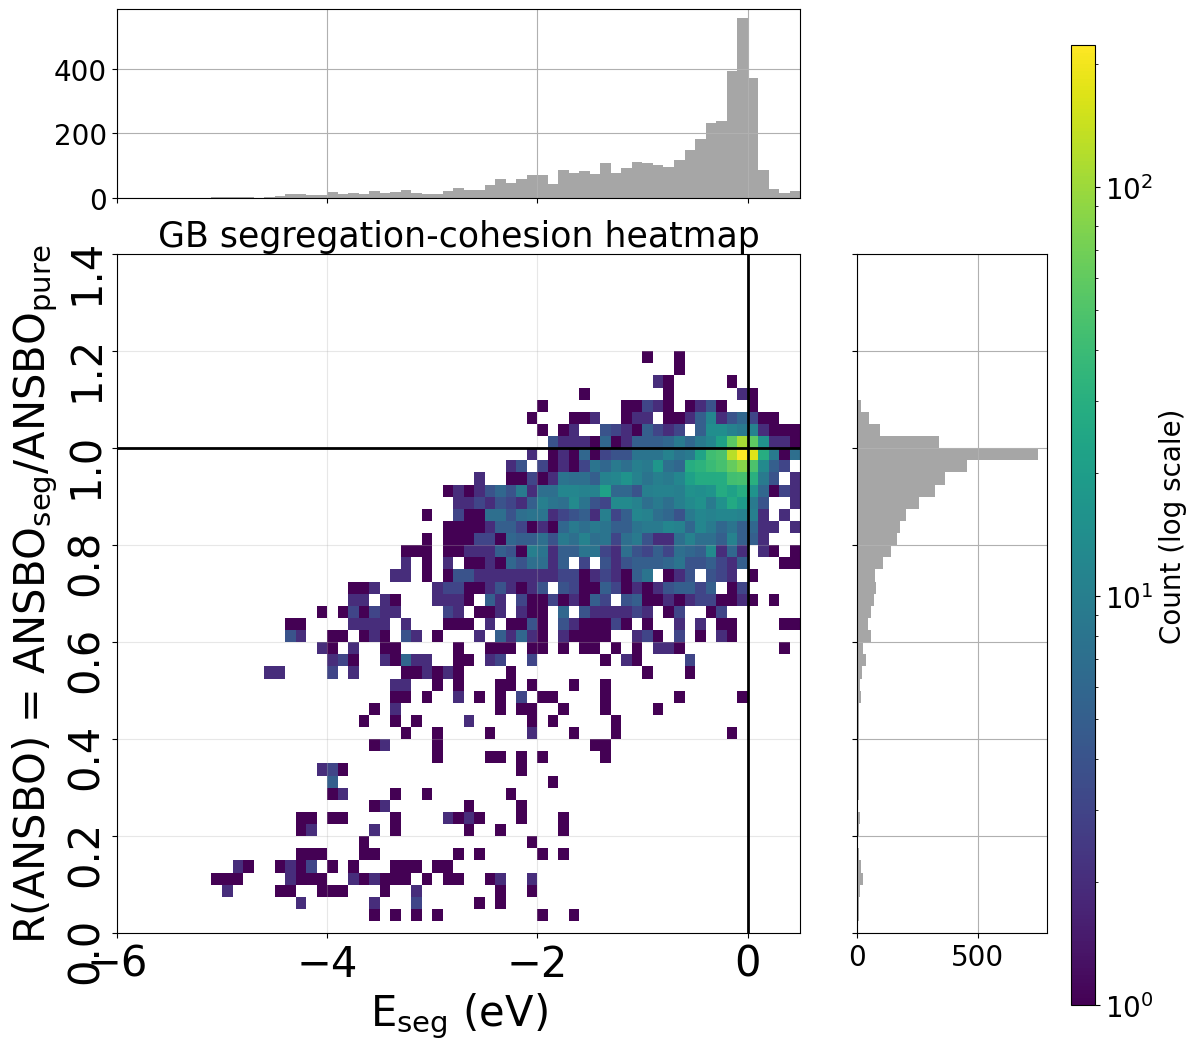

In [ ]:
plot_df = df[df["E_seg"] < 0.5]

fig, ax1 = plot_prop_vs_prop_with_2d_histograms(
    x_values=plot_df.E_seg.values,
    y_values=plot_df.R_DDEC6_ANSBO.values,
    figsize=(12, 12),
    x_label=r"E$_{\rm{seg}}$ (eV)",
    x_label_fontsize=30,
    xtick_fontsize=30,
    y_label=r"R(${\rm{ANSBO}}$) = ANSBO$_{\rm{seg}}$/ANSBO$_{\rm{pure}}$",
    y_label_fontsize=30,
    ytick_fontsize=30,
    hist_tick_fontsize=20,
    legend_posn=(-0.01, 0.62),
    colorbar_tick_fontsize=20,  # Added colorbar tick font size
    colorbar_size=[0.92, 0.05, 0.02, 0.8],  # Colorbar size [left, bottom, width, height]
    ylims=(0.00, 1.4),
    xlims=(-6, 0.5),
    x_bin_width=0.1,  # Bin width for the histograms
    y_bin_width=0.025)

# Add vertical and horizontal lines
ax1.axhline(1.00, linewidth=2, linestyle="-", c="k")
ax1.axvline(0, linewidth=2, linestyle="-", c="k")

# Set the title to indicate the current GB group
ax1.set_title(f"GB segregation-cohesion heatmap", fontsize=25)
write_path = f"{fig_savepath}/Figures/R_ANSBO_vs_Eseg_AllSites_Heatmap.png"
#fig.savefig(write_path, dpi=300, bbox_inches='tight', pad_inches=0.1)
fig.savefig(f"{fig_savepath}/Figure9b_feed.png", dpi=300, bbox_inches='tight', pad_inches=0.1)

## Figure 10

### Figure 10a

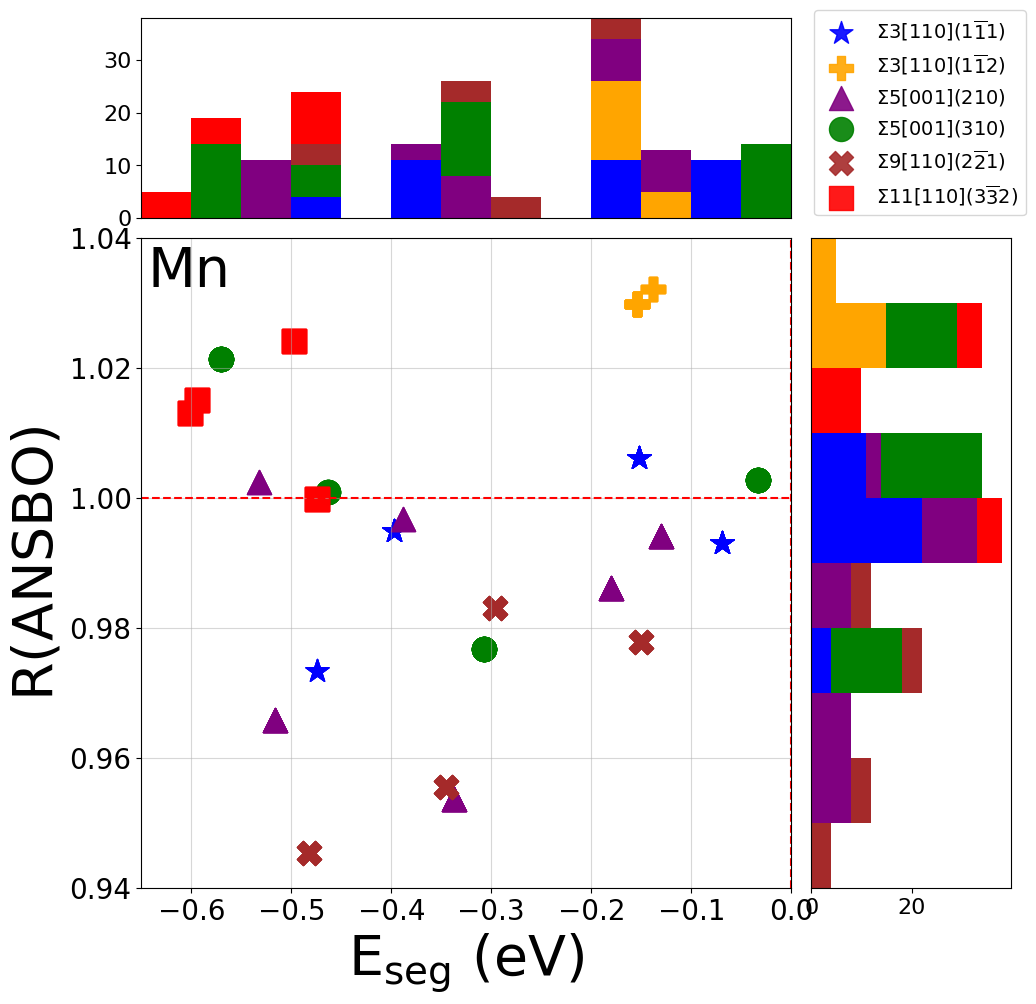

In [ ]:
from FeGB_PtableSeg.plotters import plot_x_y_whist_spectra
props = ["R_DDEC6_ANSBO", "R_wsep", "eta_min_ANSBO", "eta_min_wsep_RGS", "DDEC6_min_ANSBO", "Wsep_RGS_min"]
prop_labels = [
    #r"$\rm{R}_{\rm{ANSBO}}$", 
    r"R(${\rm{ANSBO}}$)",
    r"$\rm{R}_{\rm{W}_{\rm{sep}}}$", 
    r"$\eta_{\rm{ANSBO}}$ (ANSBO)", 
    r"$\eta_{\rm{W}_{\rm{sep}}}$ (J/m$^2$)", 
    "DDEC6 ANSBO", 
    r"W$_{\rm{sep}}$ (J/m$^2$)"
]
prop_label_dict = dict(zip(props, prop_labels))
x_prop = "E_seg"
y_prop = props[0]
element = "Mn"
fig, ax = plot_x_y_whist_spectra(df=df[(df["element"] == element) & (df["E_seg"] < 0) & (df["dist_GB"] < 3.5)].dropna(subset="R_DDEC6_ANSBO"),
                    x=x_prop,
                    y=y_prop,
                    close_fig=False,
                    xlabel=r"$\rm{E}_{\rm{seg}}$ (eV)",
                    ylabel=prop_label_dict[y_prop],
                    xlabel_fontsize=40,
                    ylabel_fontsize=40,
                    legend_fontsize=14,
                    bin_width_x=0.05,
                    bin_width_y=0.01,
                    hist_ticksize=16,
                    title=element,
                    title_fontsize=40,
                    mask_limits=None)
_ = ax.axhline(y=1.0, color="r", linestyle="--")
_ = ax.axvline(x=0, color="r", linestyle="--")

fig.savefig(f"{fig_savepath}/Figure10a_feed.png", dpi=300, bbox_inches='tight', pad_inches=0.1)

### Figure 10b

/root/github_dev/HTSegregation_PyironWorkflow_Demonstrator/FeGB_PtableSeg/plotters.py:1176: RuntimeWarning: divide by zero encountered in divide
  c_GB = np.divide(c_bulk * np.exp(-E_seg/(8.6173303e-05 * Temperature)),
/root/github_dev/HTSegregation_PyironWorkflow_Demonstrator/FeGB_PtableSeg/plotters.py:1177: RuntimeWarning: divide by zero encountered in divide
  (1 - c_bulk + c_bulk * np.exp(-E_seg/(8.6173303e-05 * Temperature))))
/root/github_dev/HTSegregation_PyironWorkflow_Demonstrator/FeGB_PtableSeg/plotters.py:1176: RuntimeWarning: invalid value encountered in divide
  c_GB = np.divide(c_bulk * np.exp(-E_seg/(8.6173303e-05 * Temperature)),


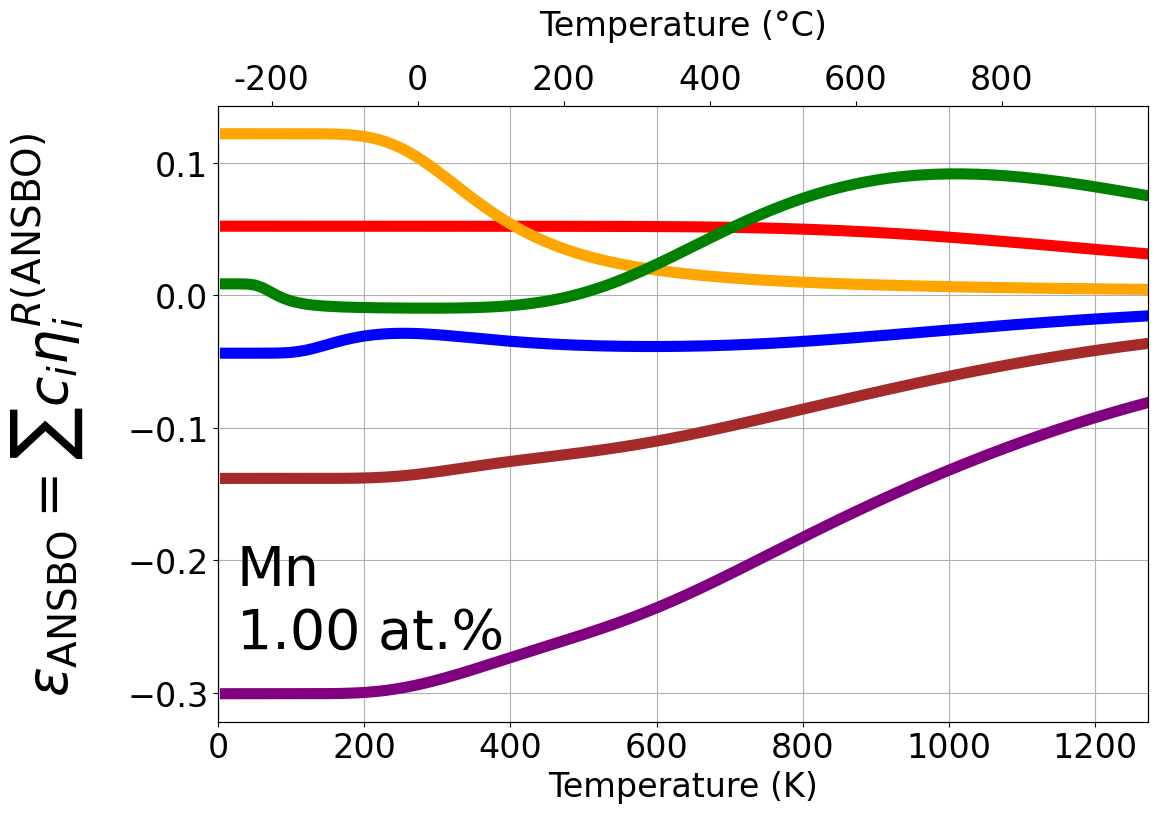

In [ ]:
from FeGB_PtableSeg.plotters import plot_cohesion_vs_temp

start_temperature = 0
end_temperature = 1273
step = 10
temperature_range = np.arange(start_temperature, end_temperature, step)
alloy_conc = 0.01 # 1 at.%

fig_ansbo, ax_ansbo = plot_cohesion_vs_temp(df_spectra,
                                            element_to_plot="Mn",
                                            alloy_conc = alloy_conc,
                                            temp_range = (start_temperature, end_temperature),
                                            temp_step = step,
                                            custom_colors=custom_colors,
                                            gb_latex_dict=gb_latex_dict,
                                            xlims=[start_temperature, end_temperature],
                                            cohesion_type="ANSBO",
                                            ylabel_text= r"$\epsilon_{\text{ANSBO}} = \sum c_i \eta_i^{R{(\text{ANSBO})}}$",
                                            ylabel_pad=30)

fig_ansbo.savefig(f"{fig_savepath}/Figure10b_feed.png", dpi=300, bbox_inches='tight', pad_inches=0.1)

/root/github_dev/HTSegregation_PyironWorkflow_Demonstrator/FeGB_PtableSeg/plotters.py:1176: RuntimeWarning: divide by zero encountered in divide
  c_GB = np.divide(c_bulk * np.exp(-E_seg/(8.6173303e-05 * Temperature)),
/root/github_dev/HTSegregation_PyironWorkflow_Demonstrator/FeGB_PtableSeg/plotters.py:1177: RuntimeWarning: divide by zero encountered in divide
  (1 - c_bulk + c_bulk * np.exp(-E_seg/(8.6173303e-05 * Temperature))))
/root/github_dev/HTSegregation_PyironWorkflow_Demonstrator/FeGB_PtableSeg/plotters.py:1176: RuntimeWarning: invalid value encountered in divide
  c_GB = np.divide(c_bulk * np.exp(-E_seg/(8.6173303e-05 * Temperature)),


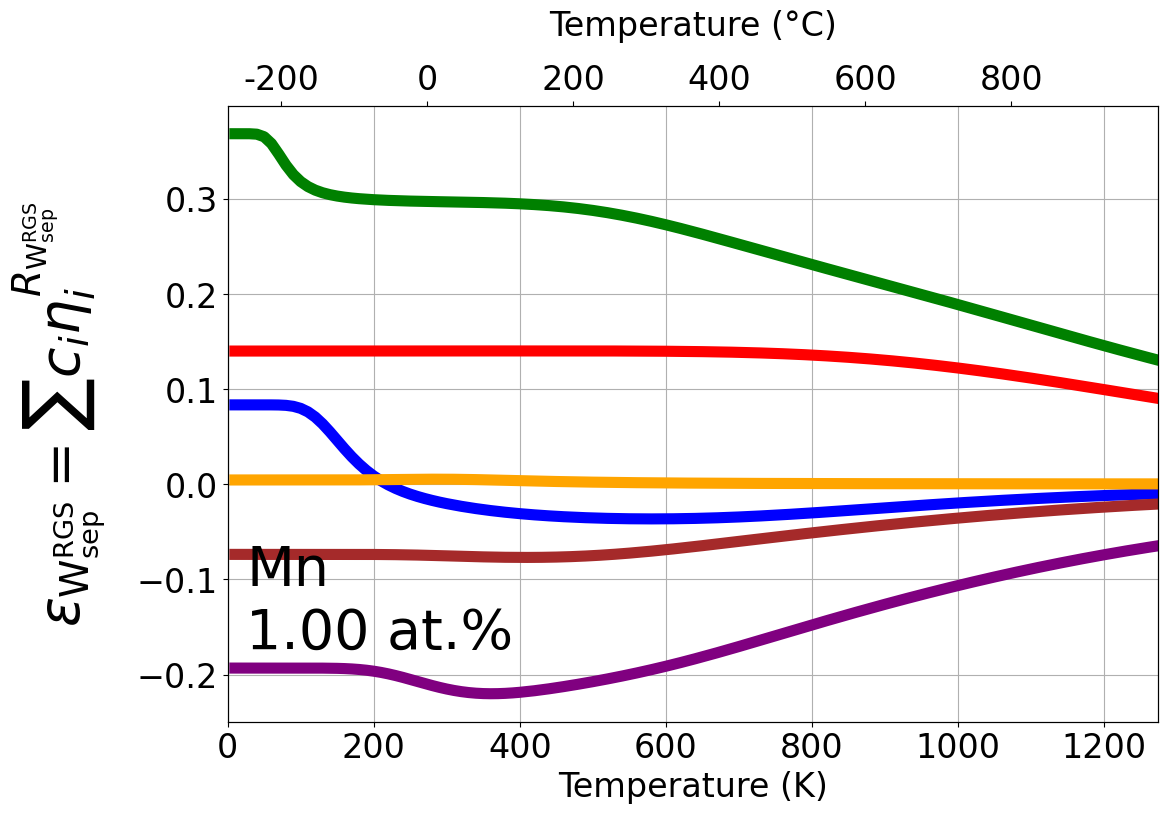

In [ ]:
fig_wsep, ax_wsep = plot_cohesion_vs_temp(df_spectra,
                                            element_to_plot="Mn",
                                            alloy_conc = alloy_conc,
                                            temp_range = (start_temperature, end_temperature),
                                            temp_step = 10,
                                            custom_colors=custom_colors,
                                            gb_latex_dict=gb_latex_dict,
                                            xlims=[start_temperature, end_temperature],
                                            cohesion_type="wsep",
                                            ylabel_text = r"$\epsilon_{\text{W}_{\text{sep}}^{\text{RGS}}} = \sum c_i \eta_i^{R_{\text{W}_{\text{sep}}^{\text{RGS}}}}$")


In [ ]:
from FeGB_PtableSeg.plotters import compute_cohesion_at_temps

temps_to_evaluate = [300, 500, 700]  # your chosen temperatures
df_cohesion = compute_cohesion_at_temps(
    df_spectra,
    alloy_conc=0.01,
    temps=temps_to_evaluate,
    cohesion_type="ANSBO"
)

df_cohesion

element               GB  temperature_K  effective_cohesion
0         Ac  S11_RA110_S3_32            300           -1.468989
1         Ac  S11_RA110_S3_32            500           -1.468989
2         Ac  S11_RA110_S3_32            700           -1.468989
3         Ac   S3_RA110_S1_11            300           -2.225091
4         Ac   S3_RA110_S1_11            500           -2.222981
...      ...              ...            ...                 ...
1615      Zr    S5_RA001_S310            500           -0.795561
1616      Zr    S5_RA001_S310            700           -0.803145
1617      Zr   S9_RA110_S2_21            300           -0.508540
1618      Zr   S9_RA110_S2_21            500           -0.508538
1619      Zr   S9_RA110_S2_21            700           -0.508323

[1620 rows x 4 columns]

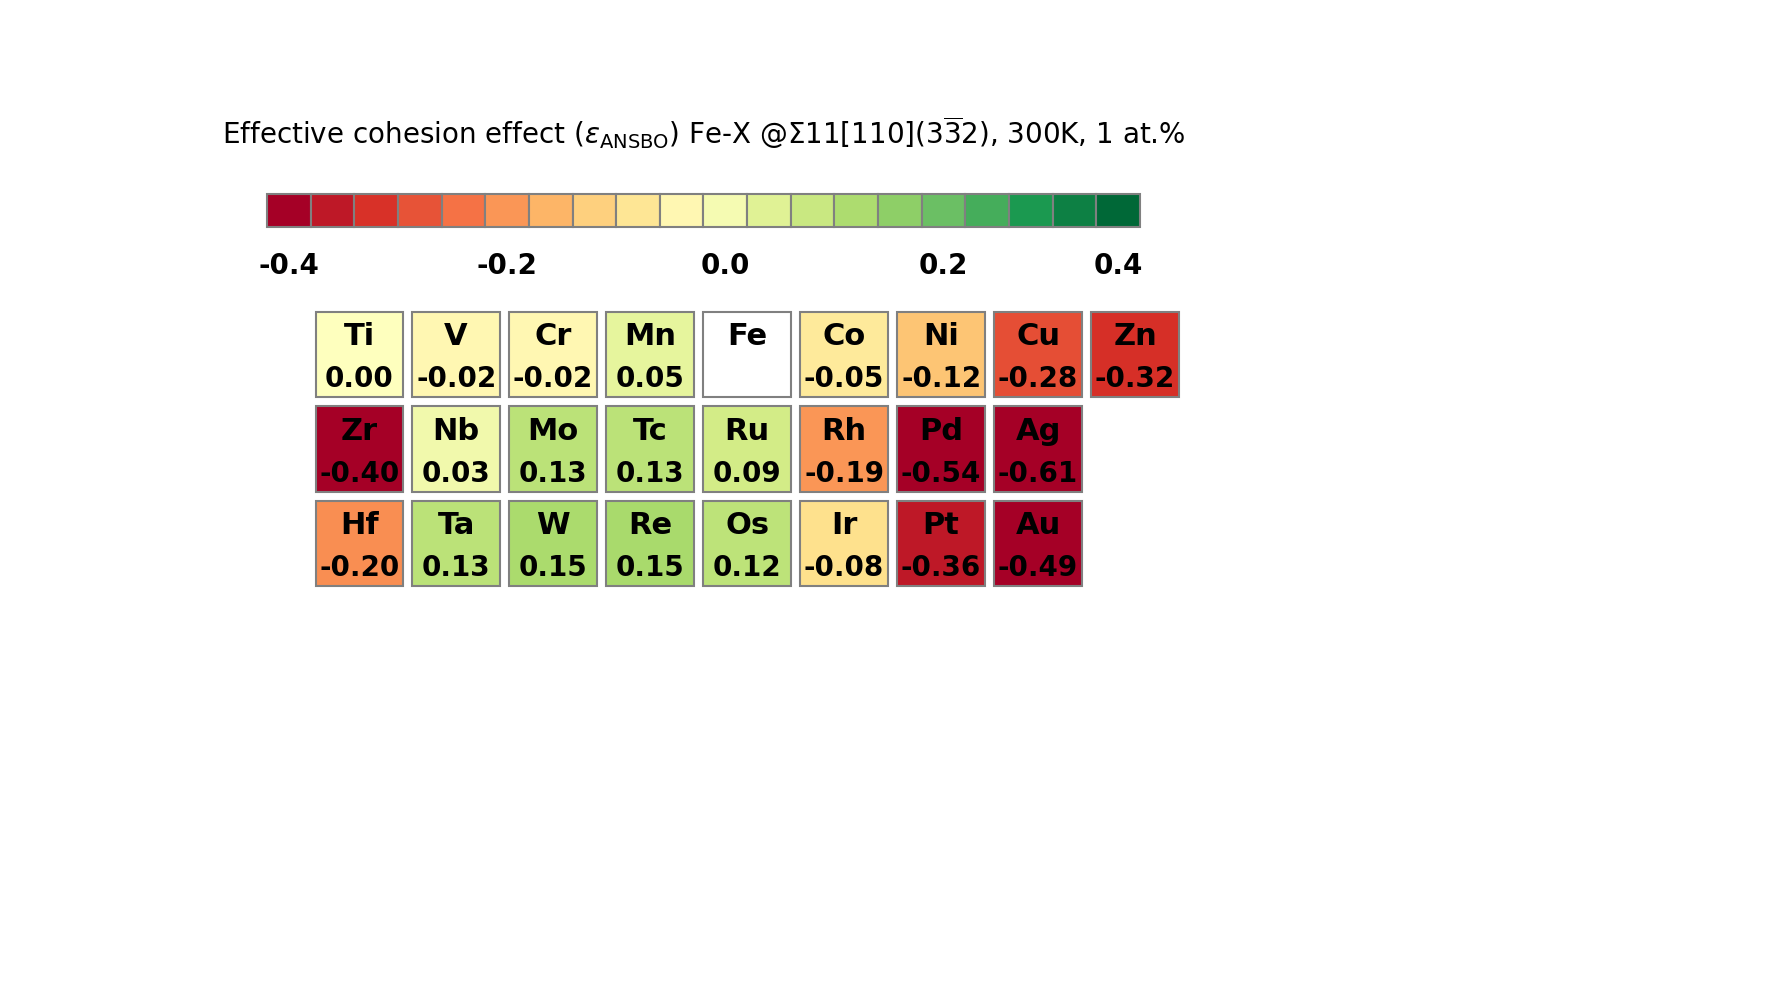

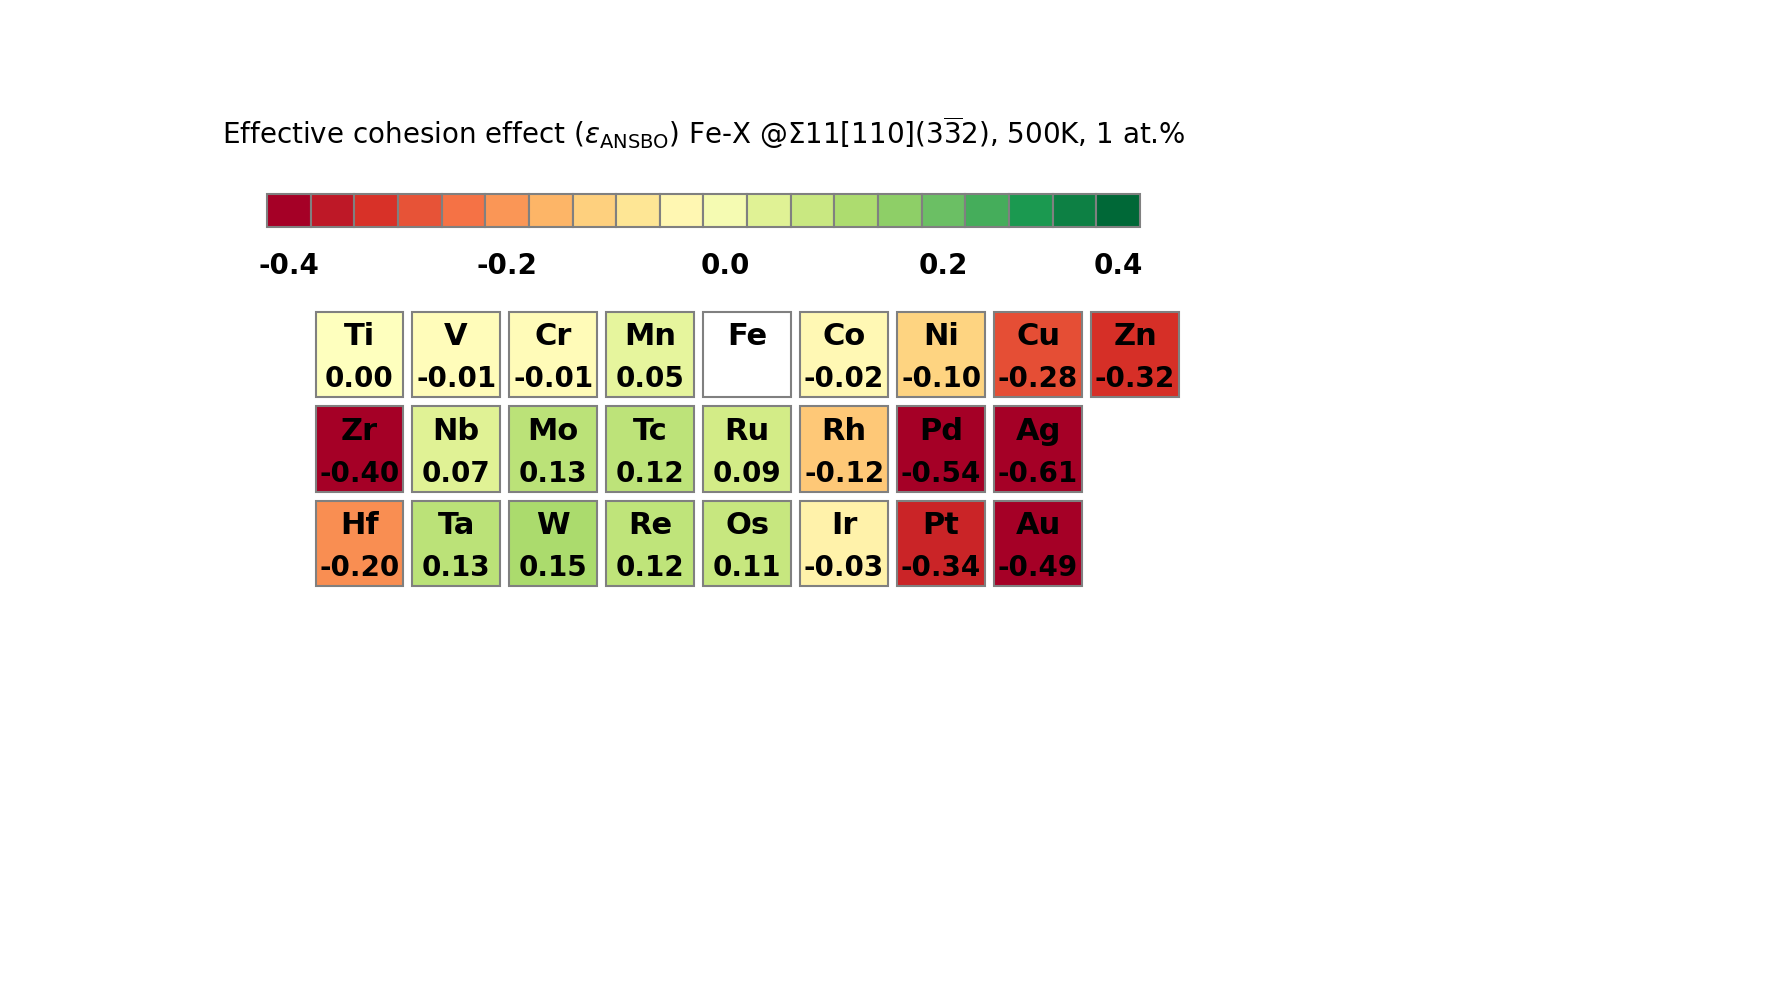

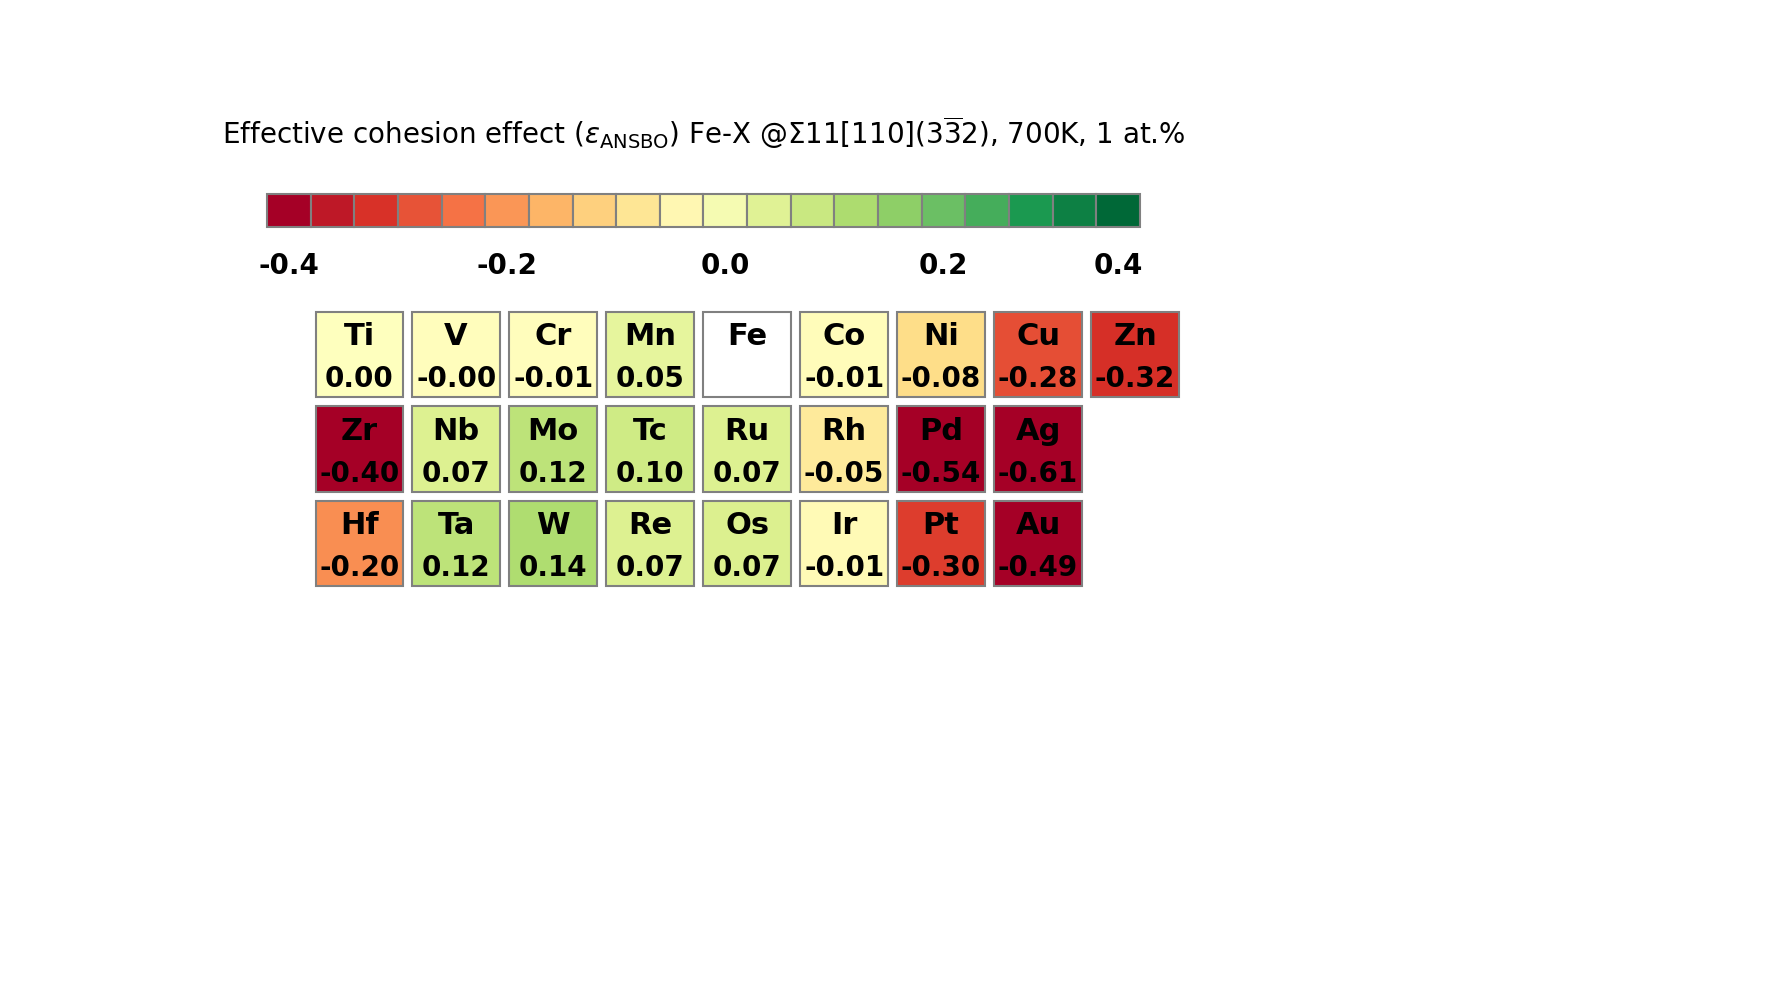

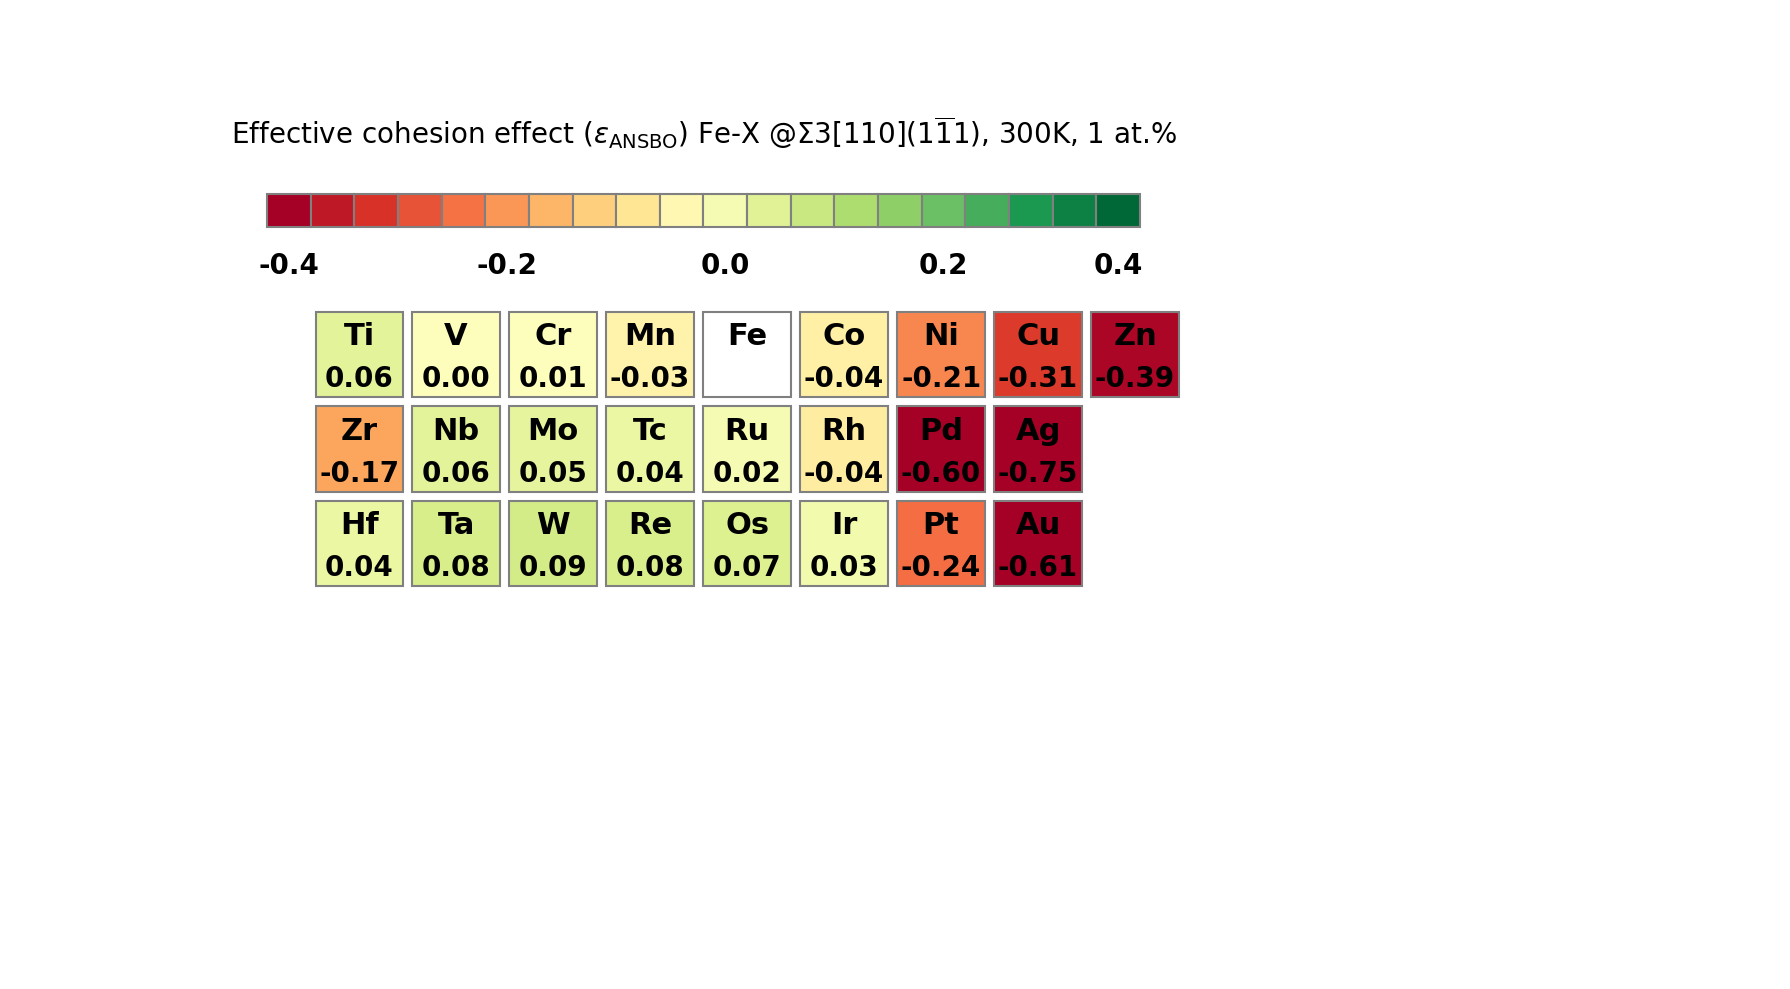

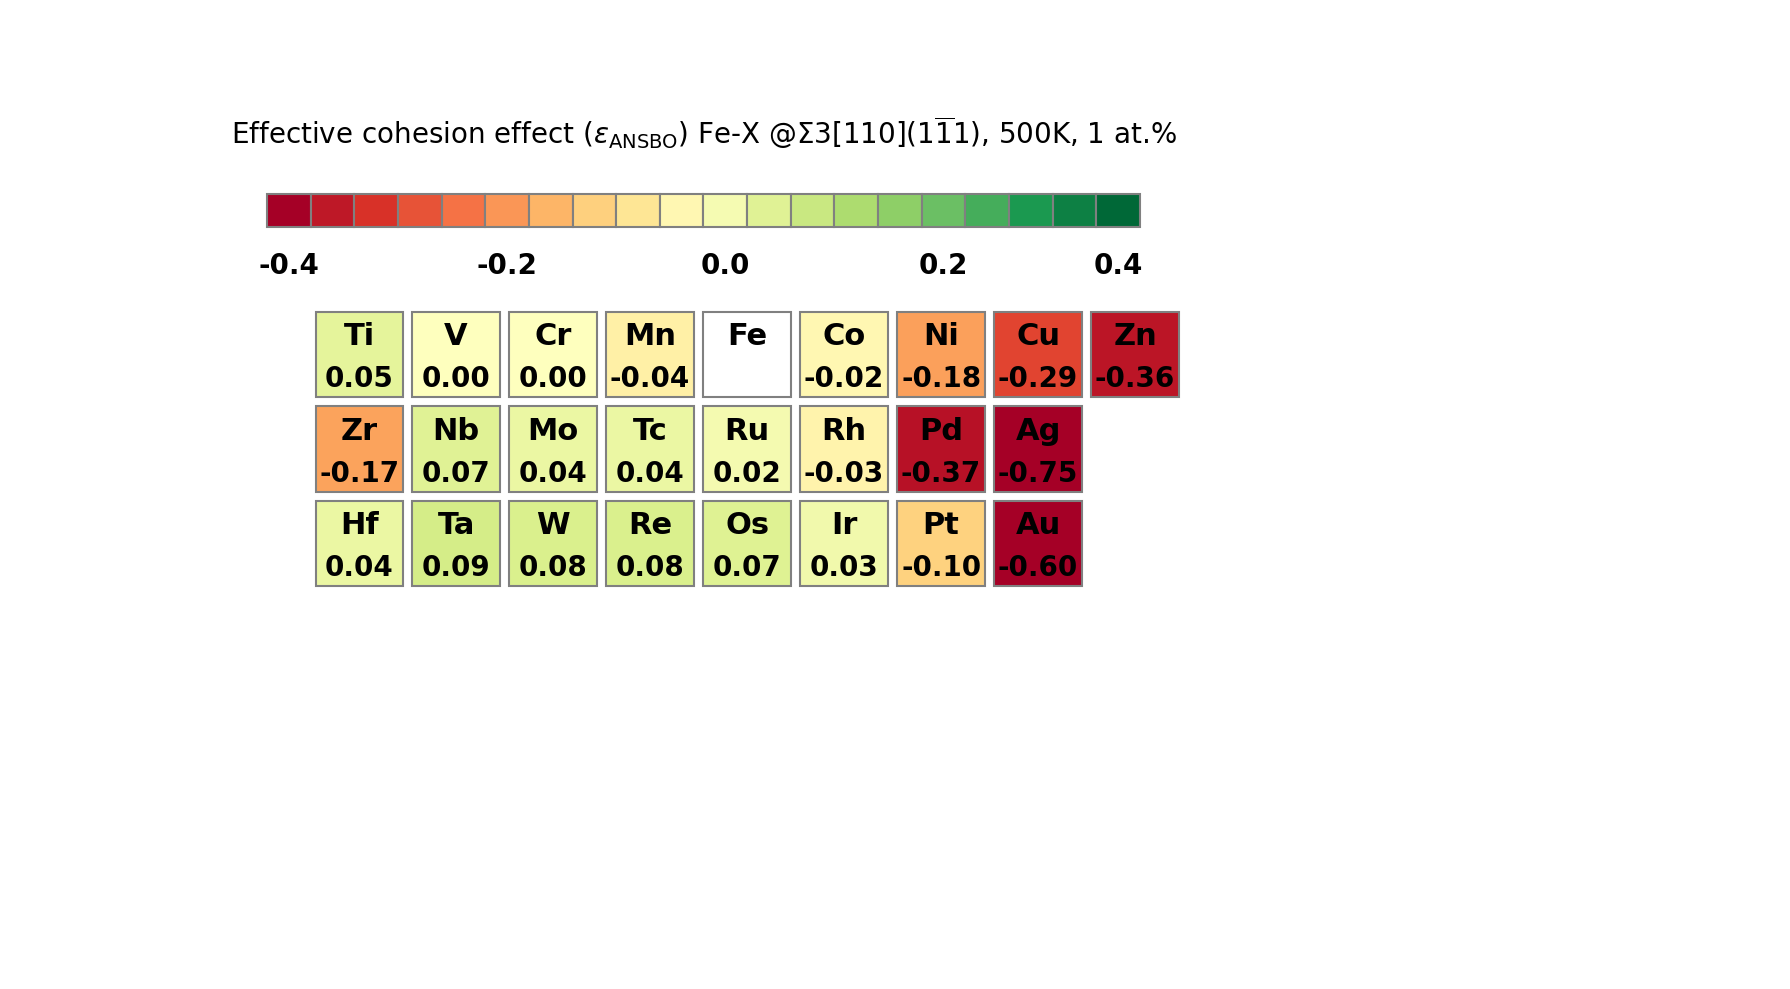

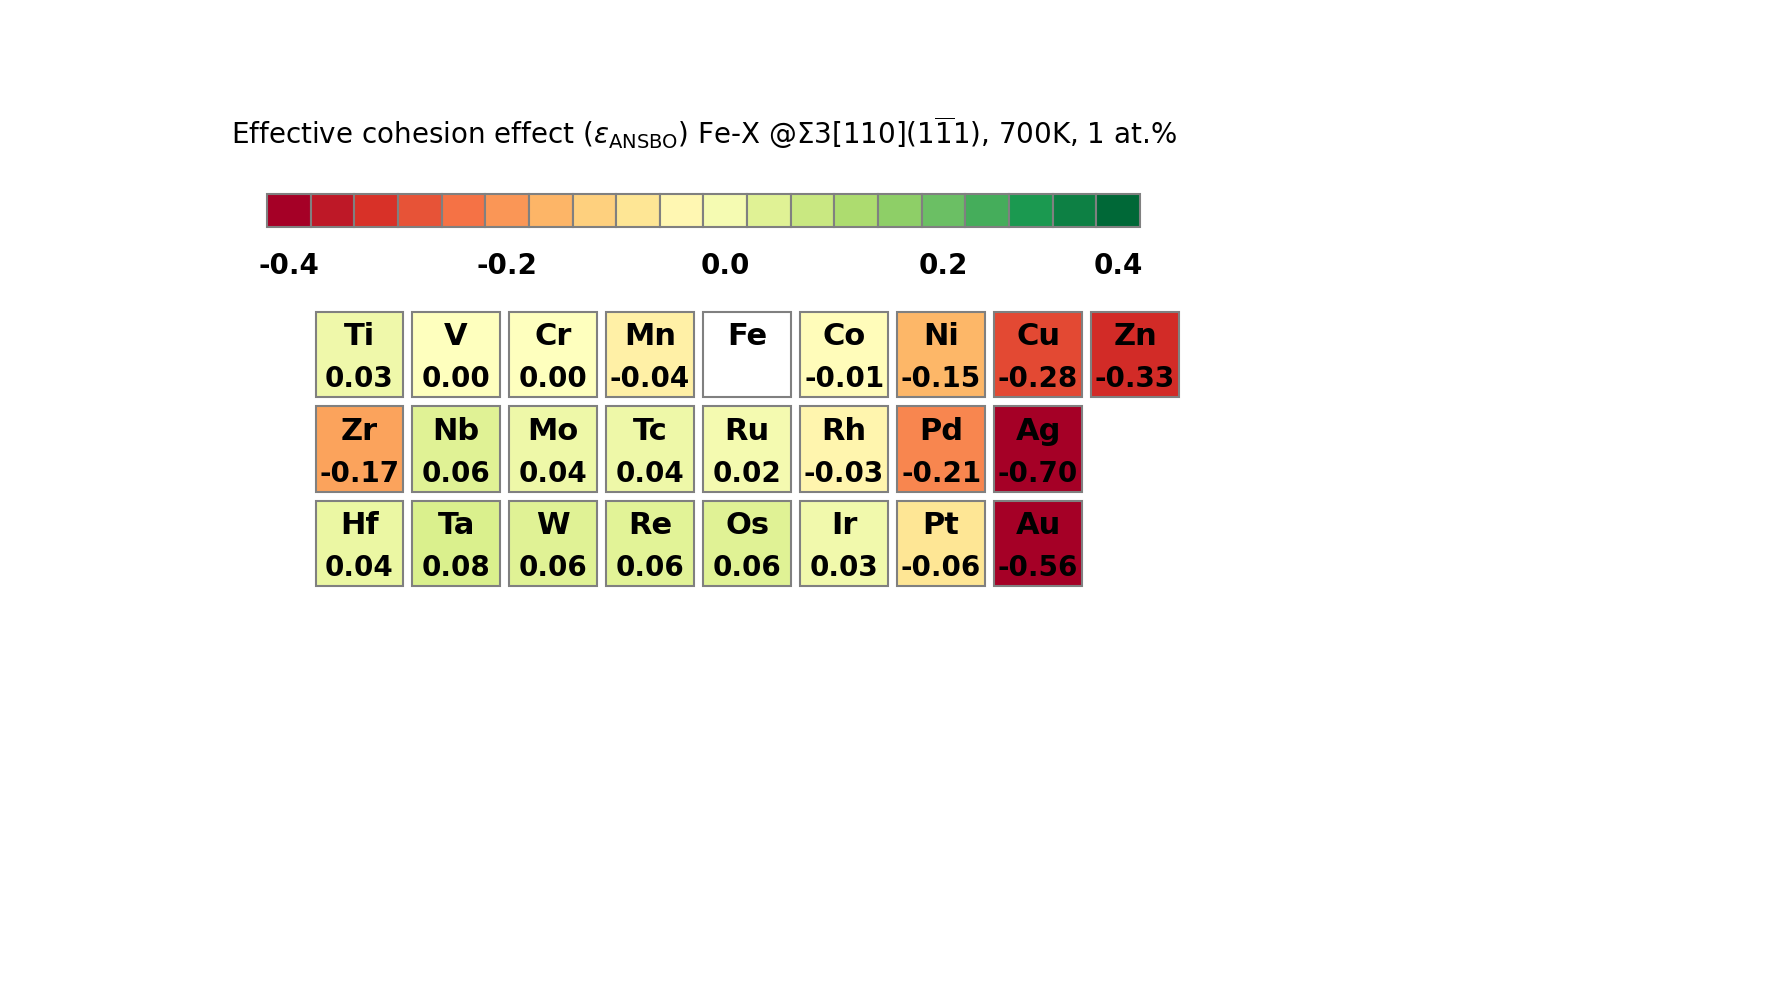

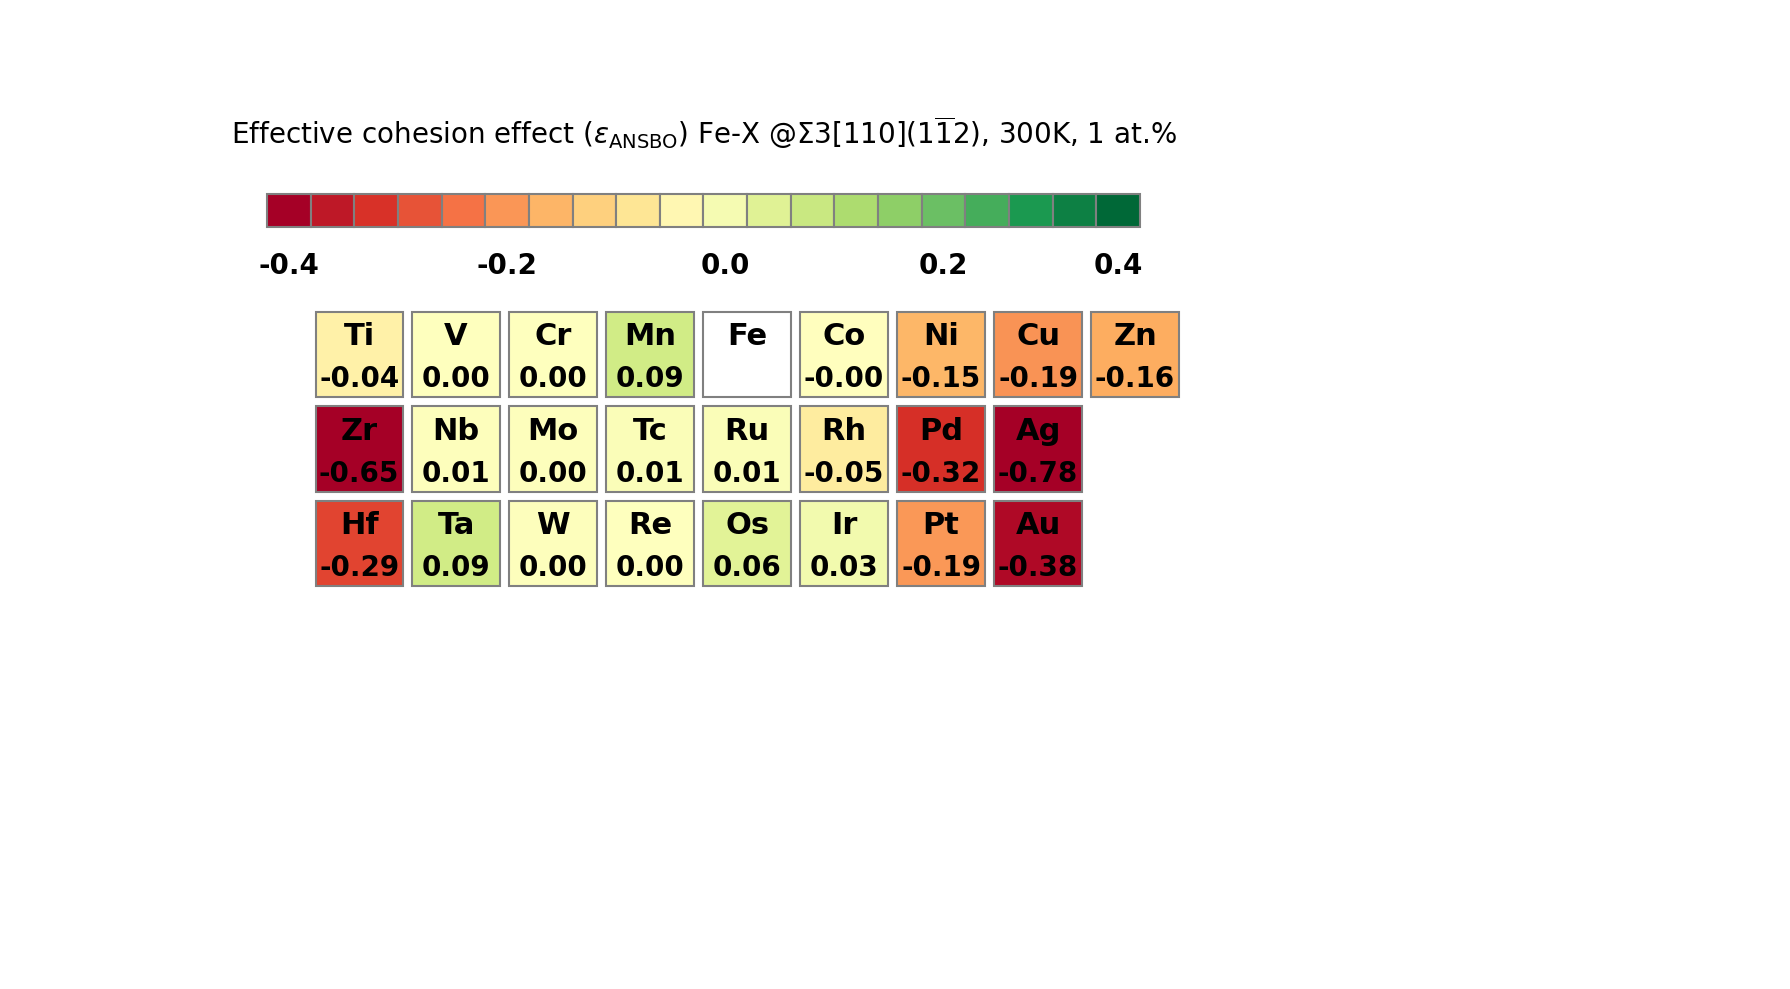

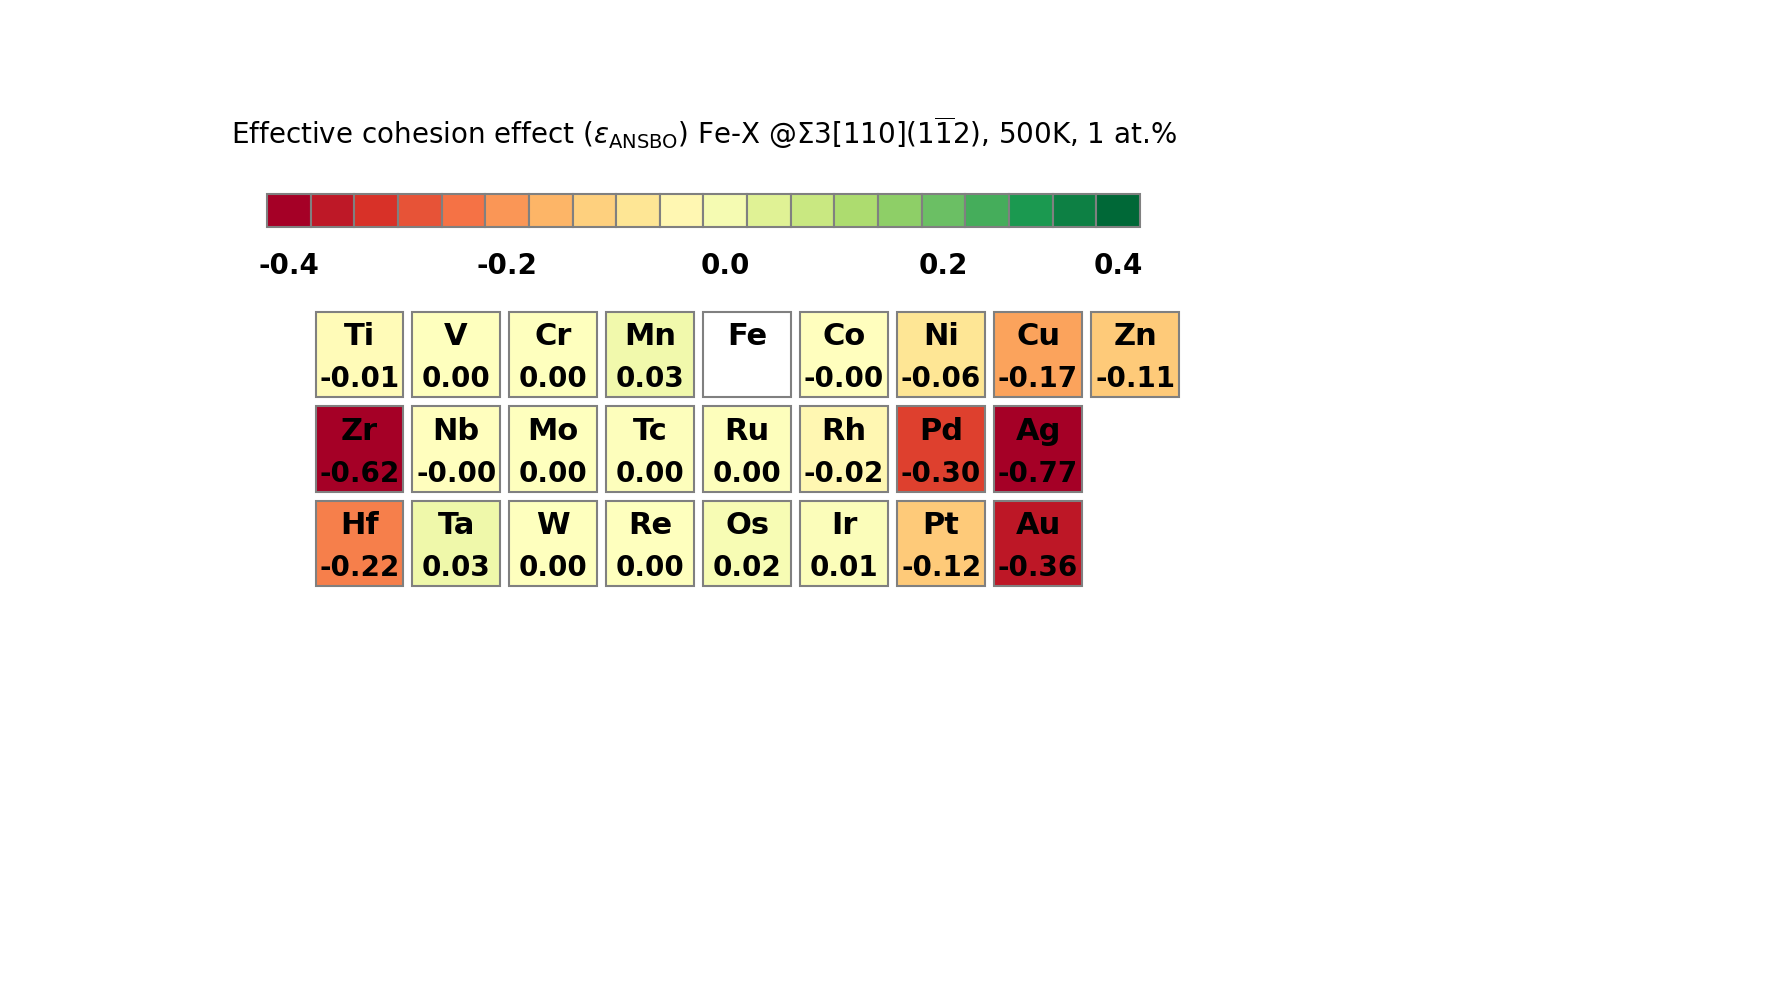

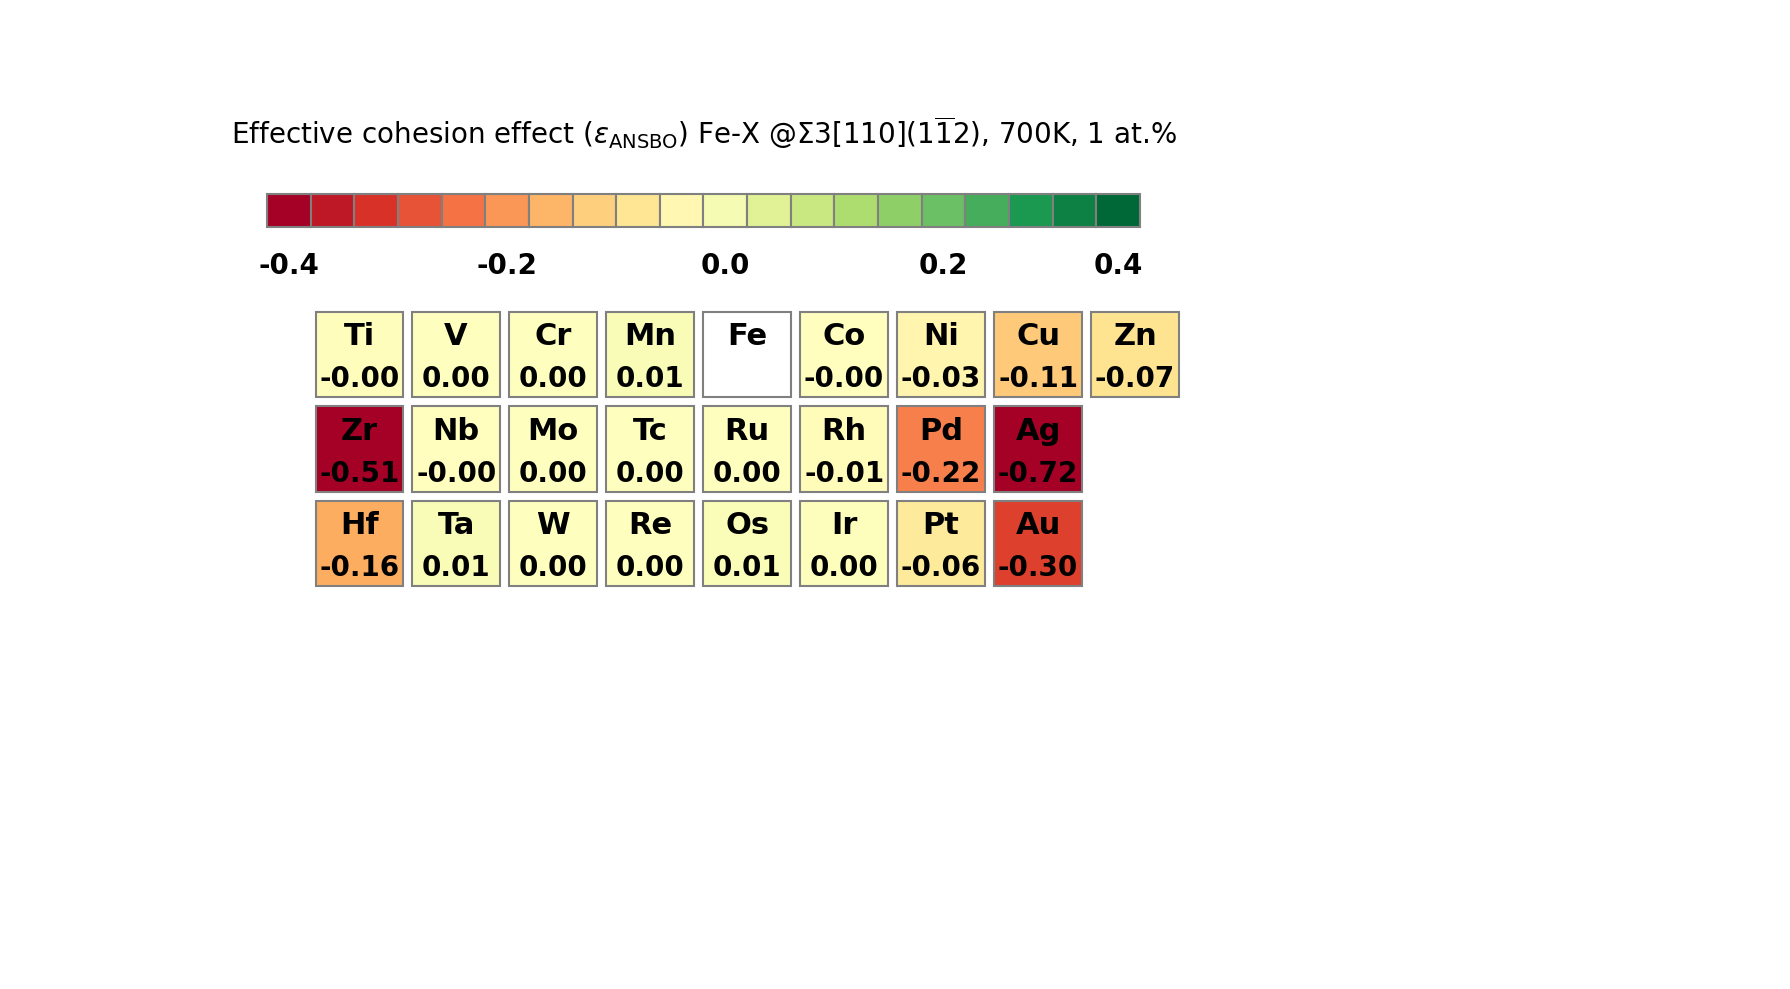

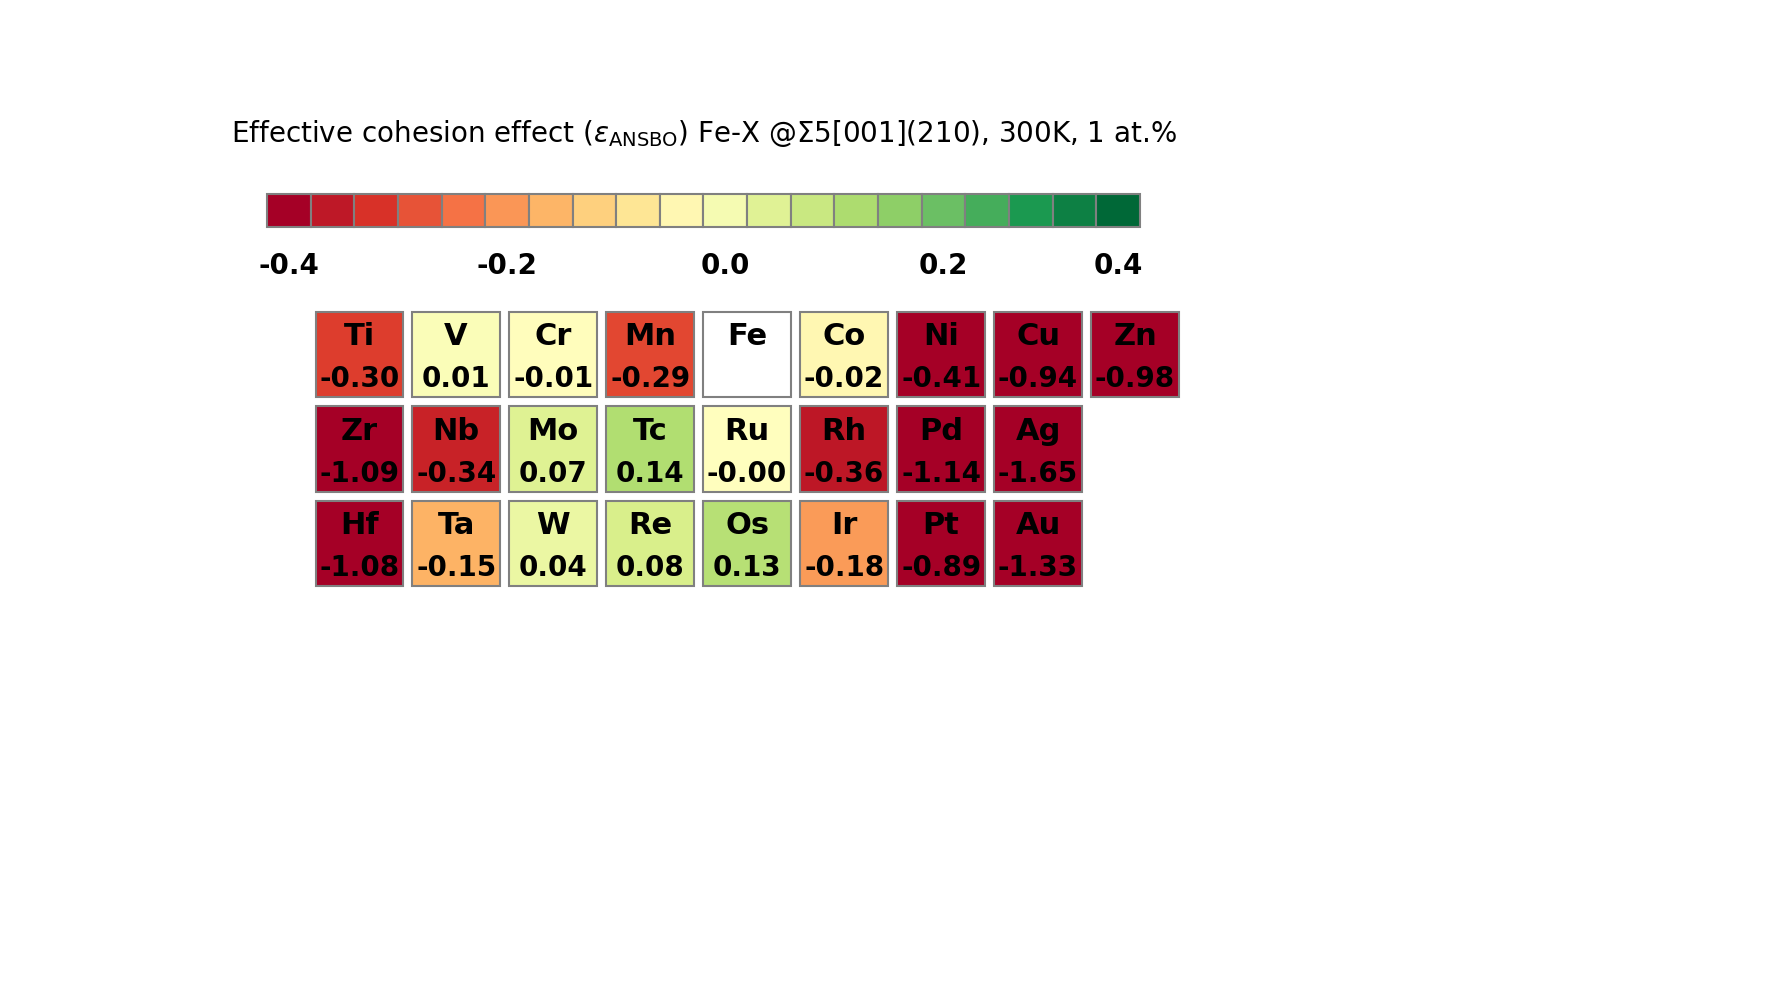

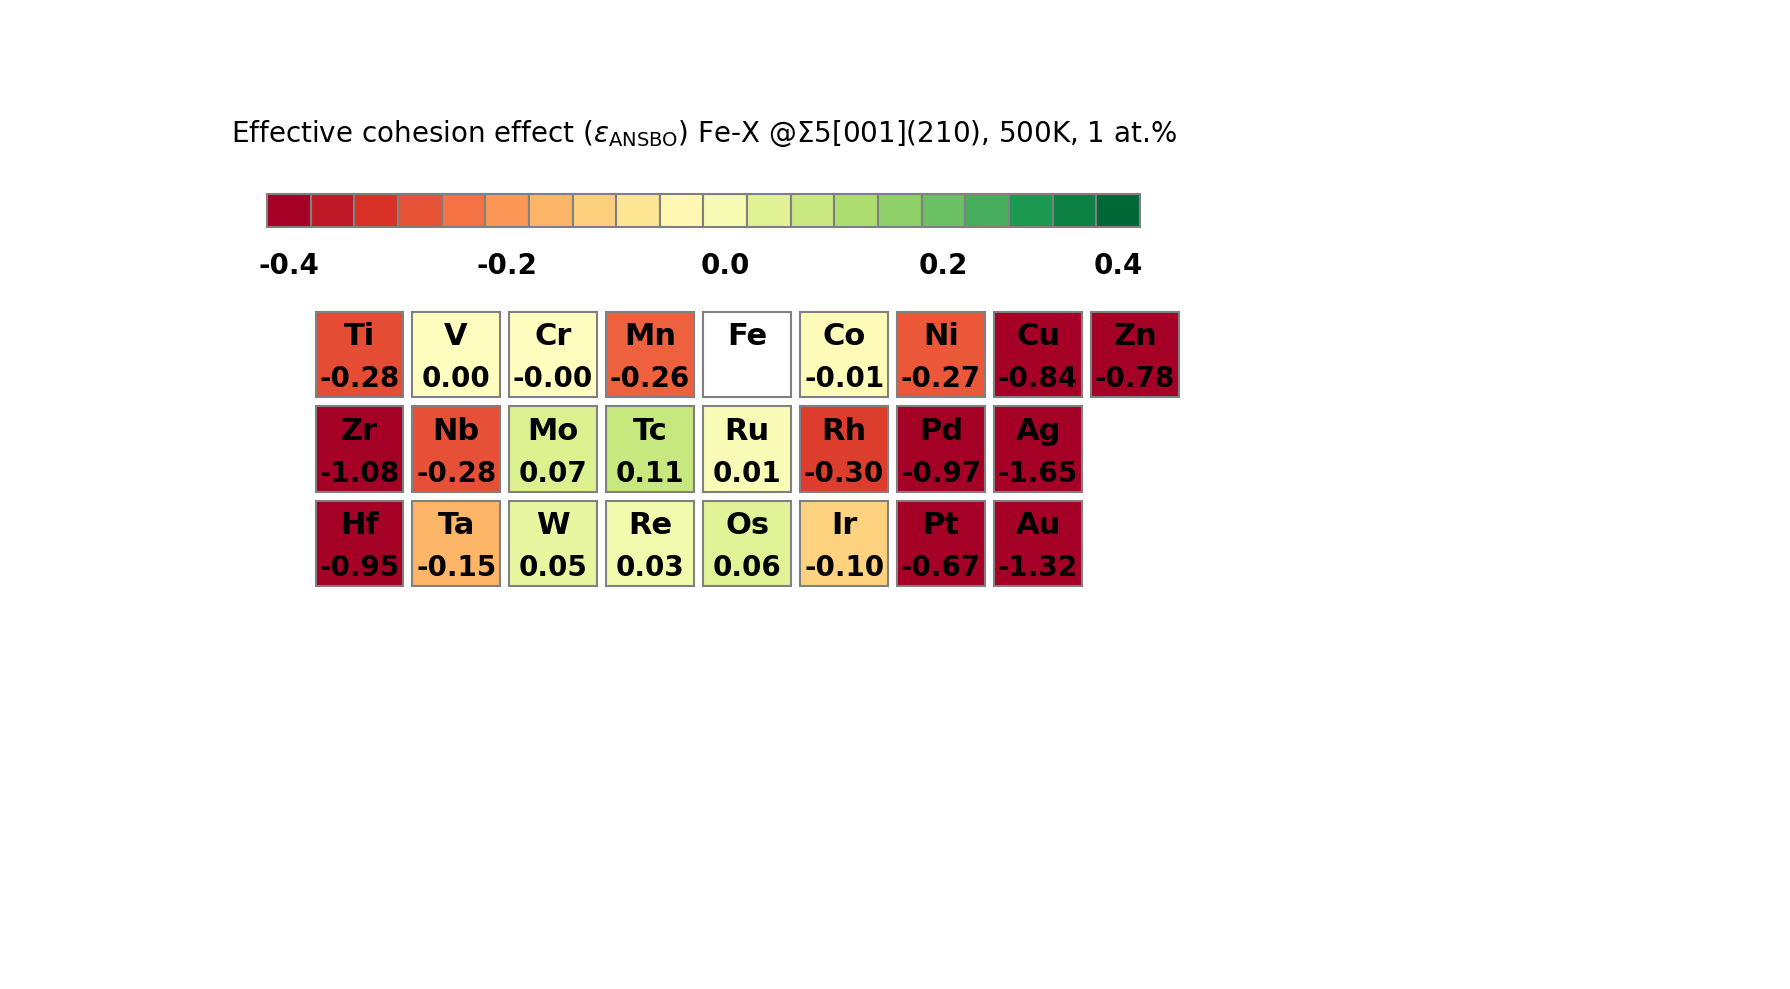

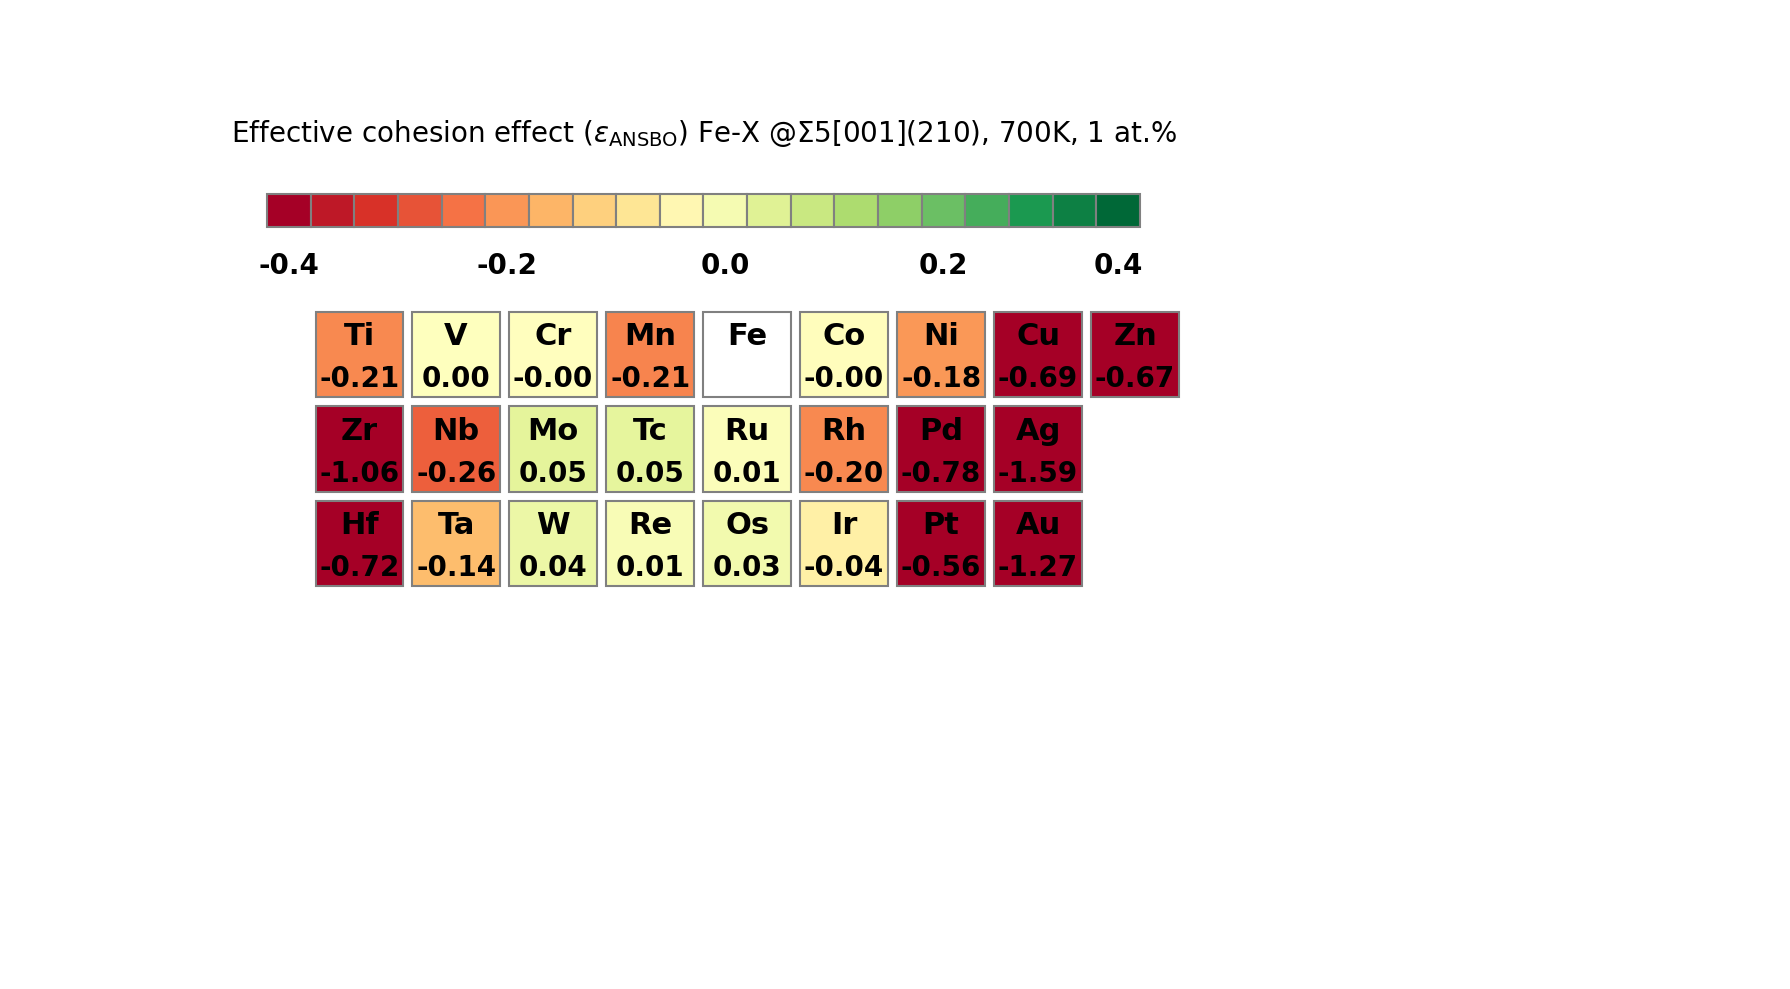

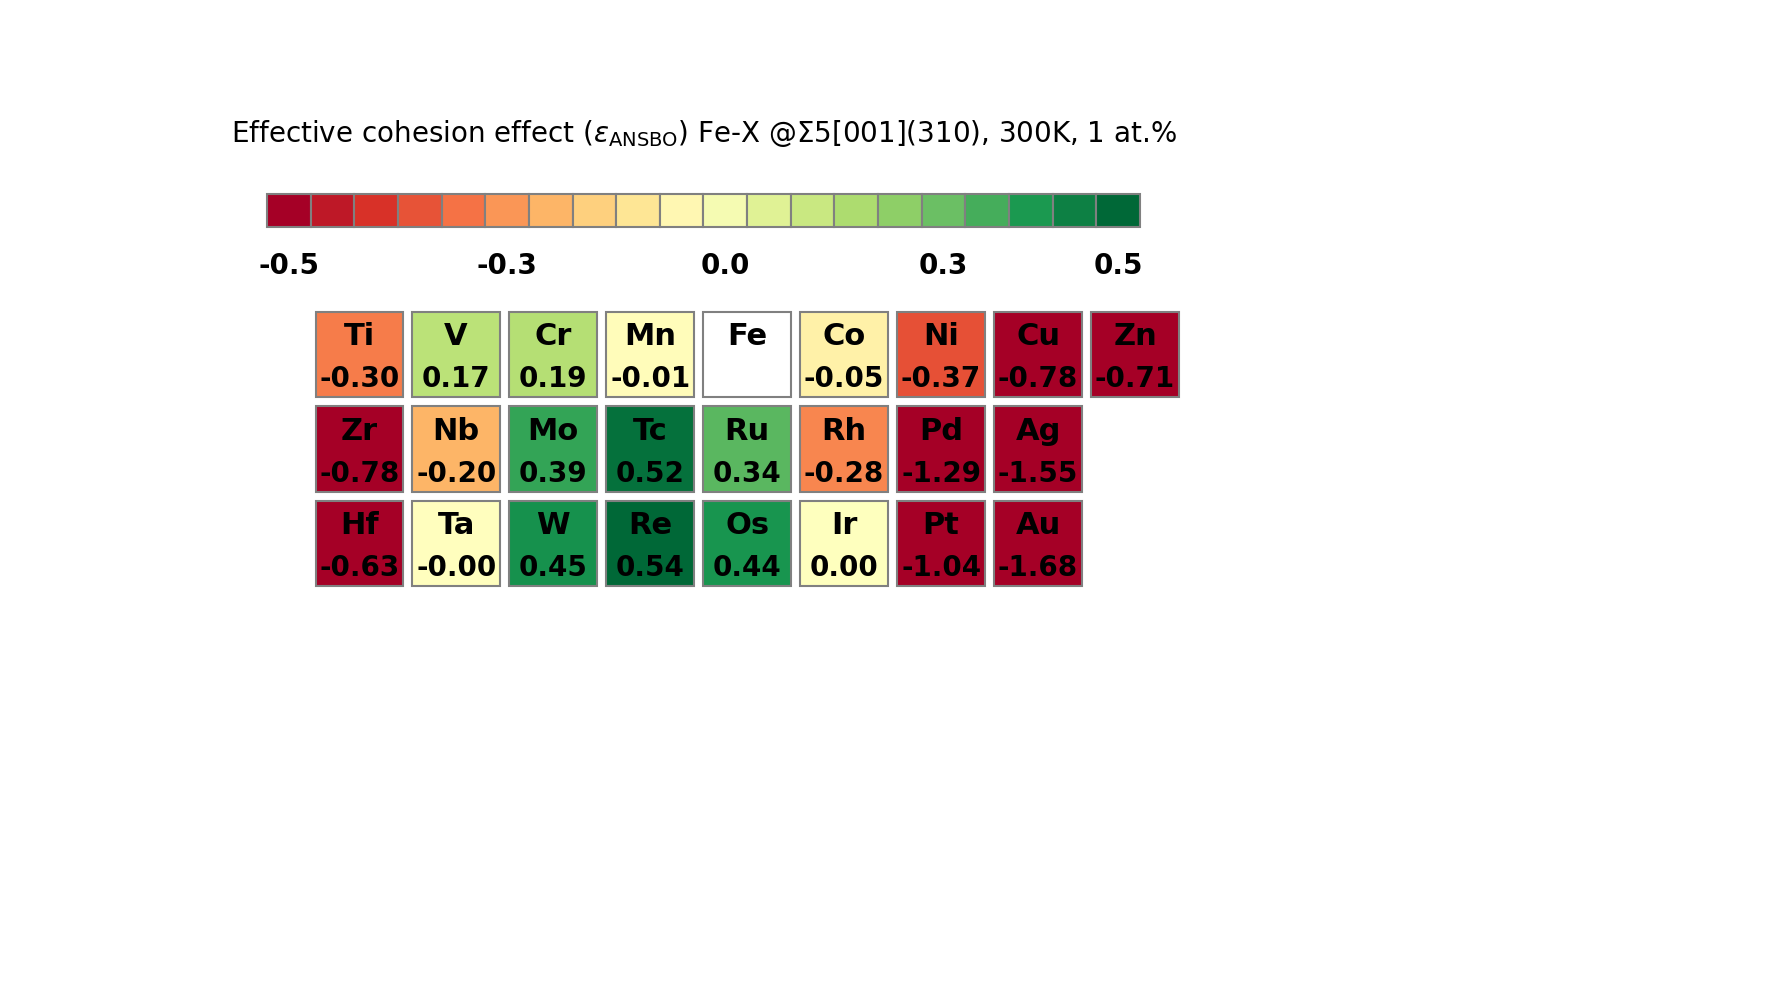

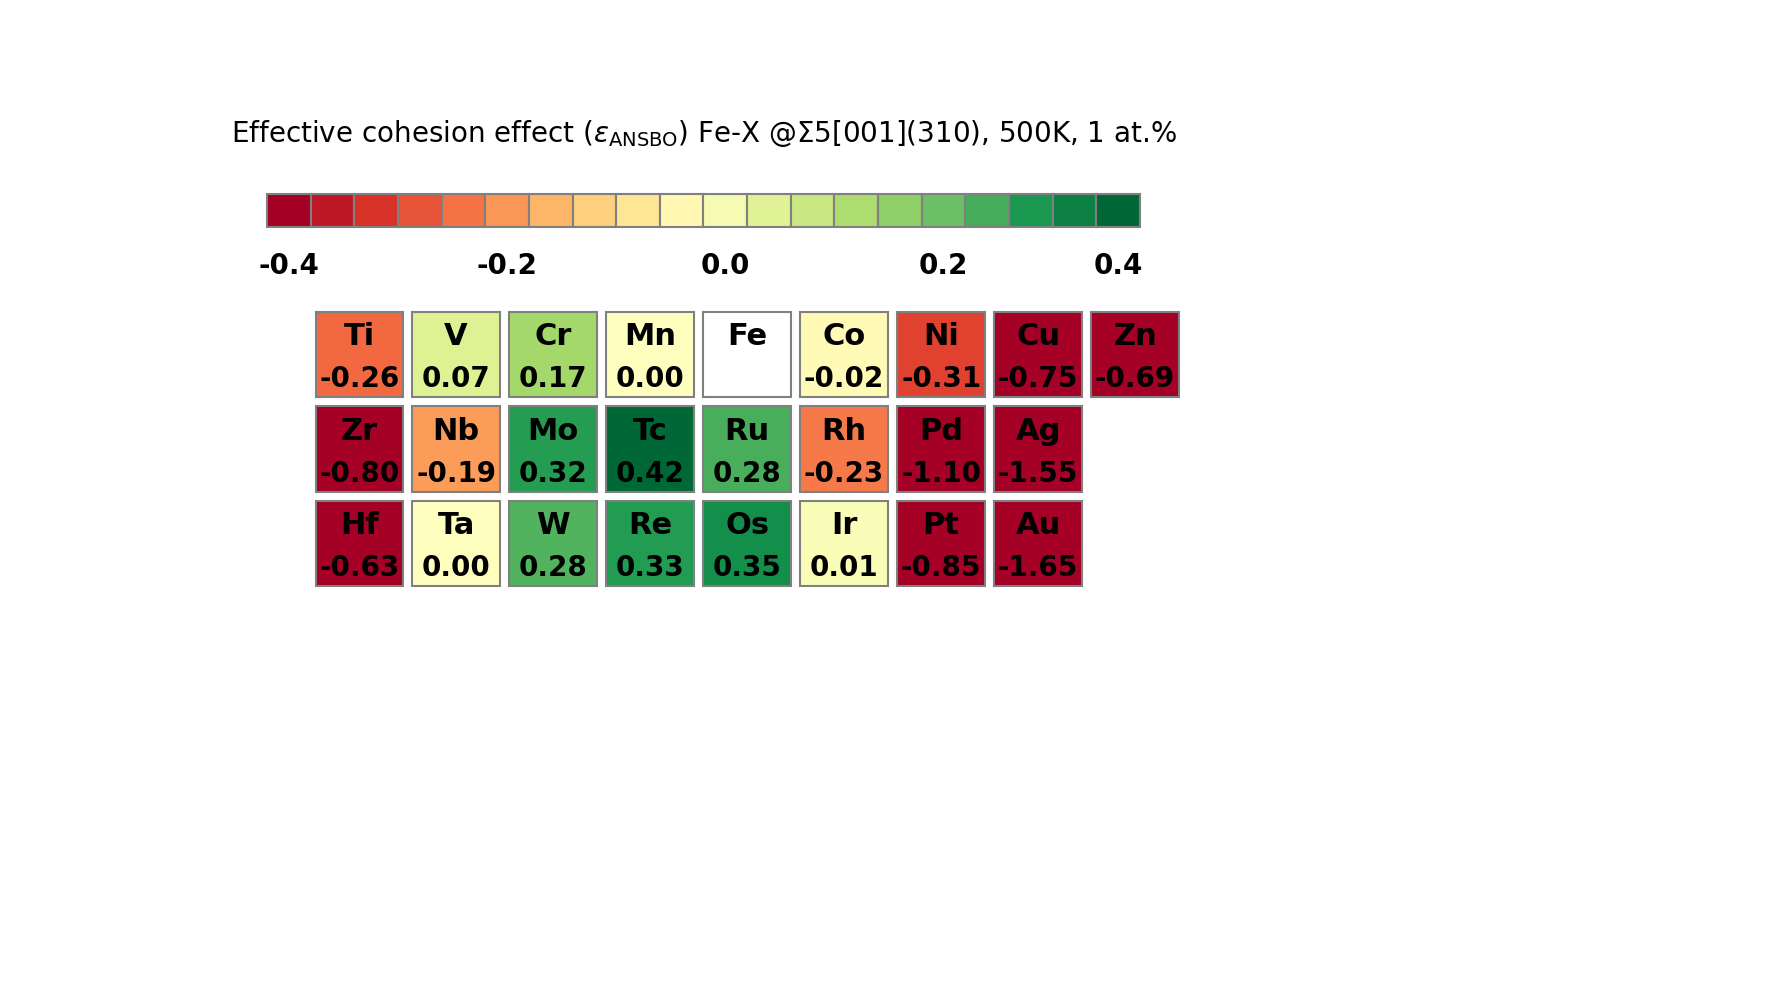

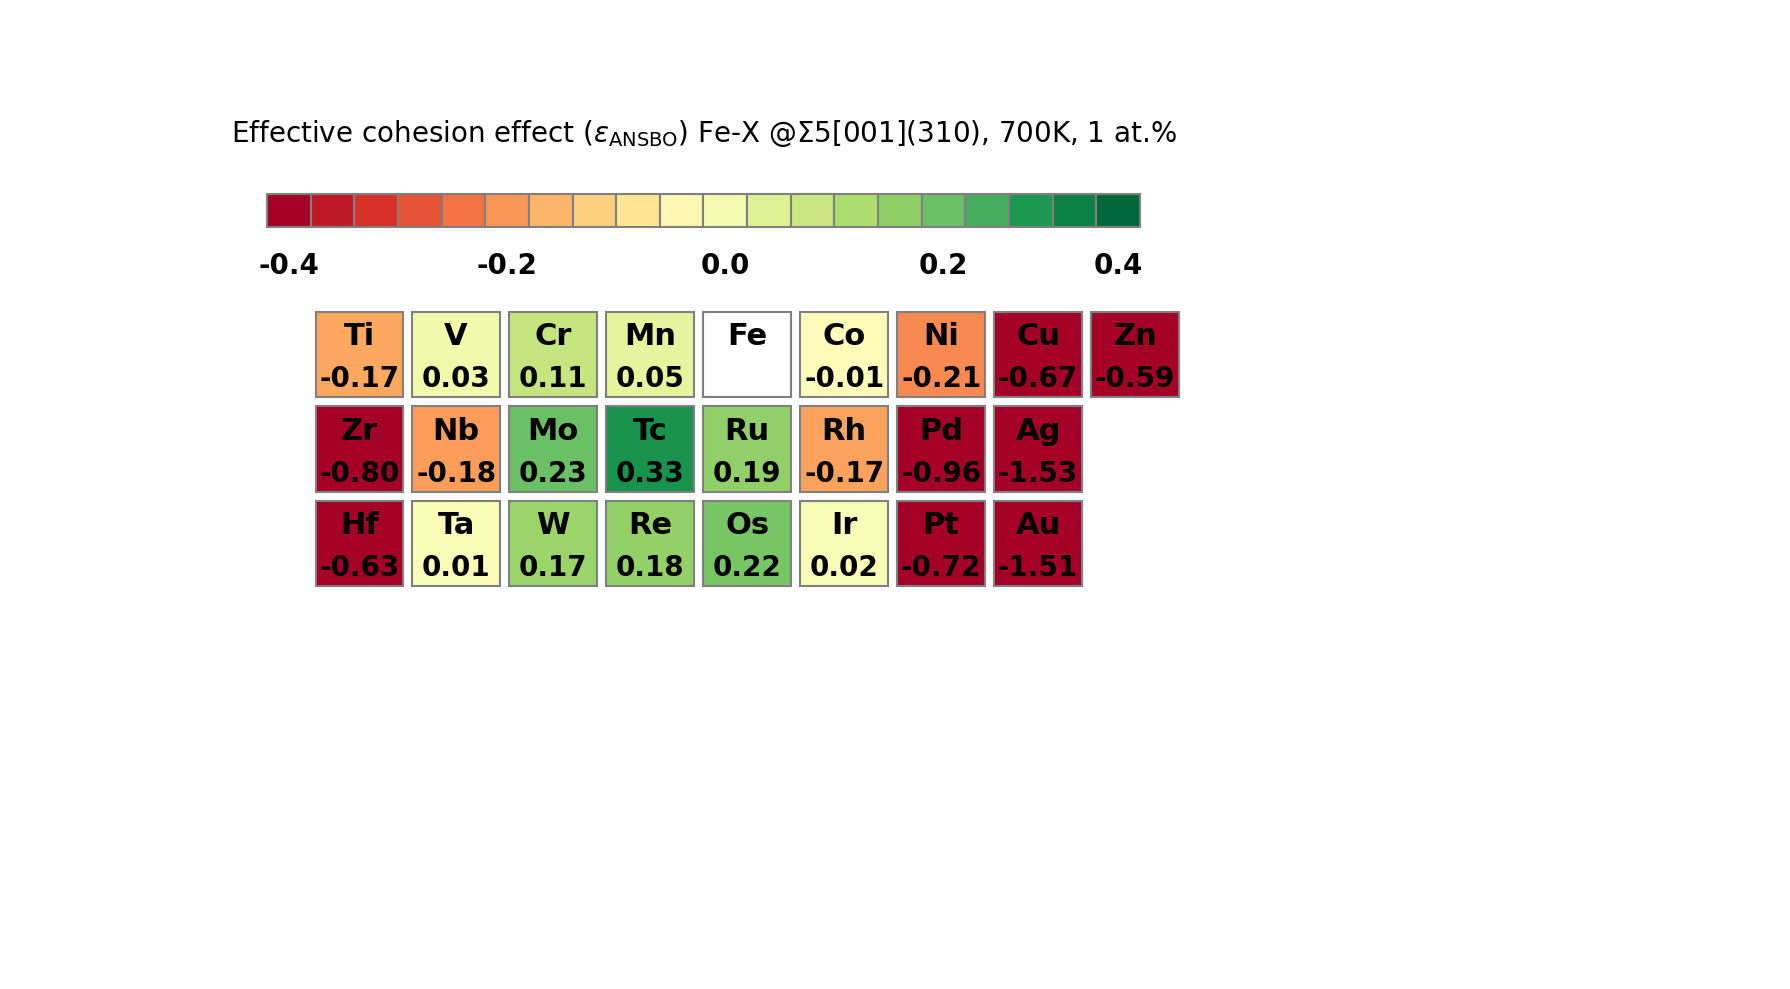

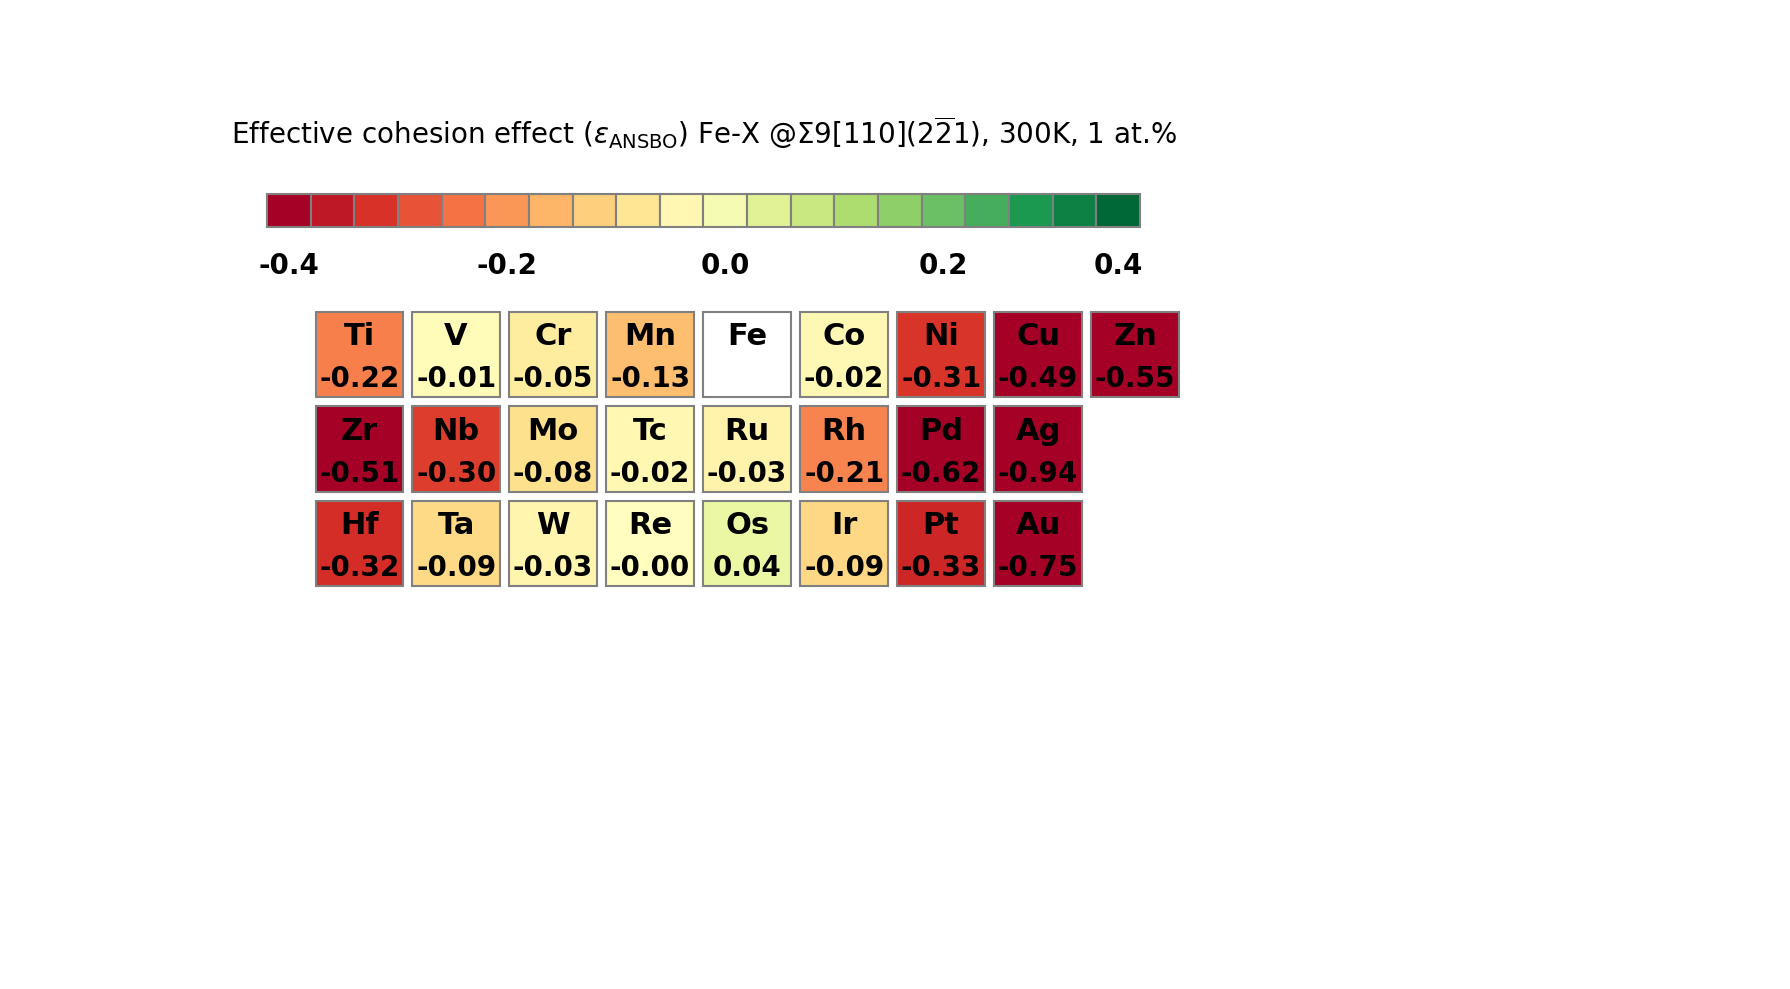

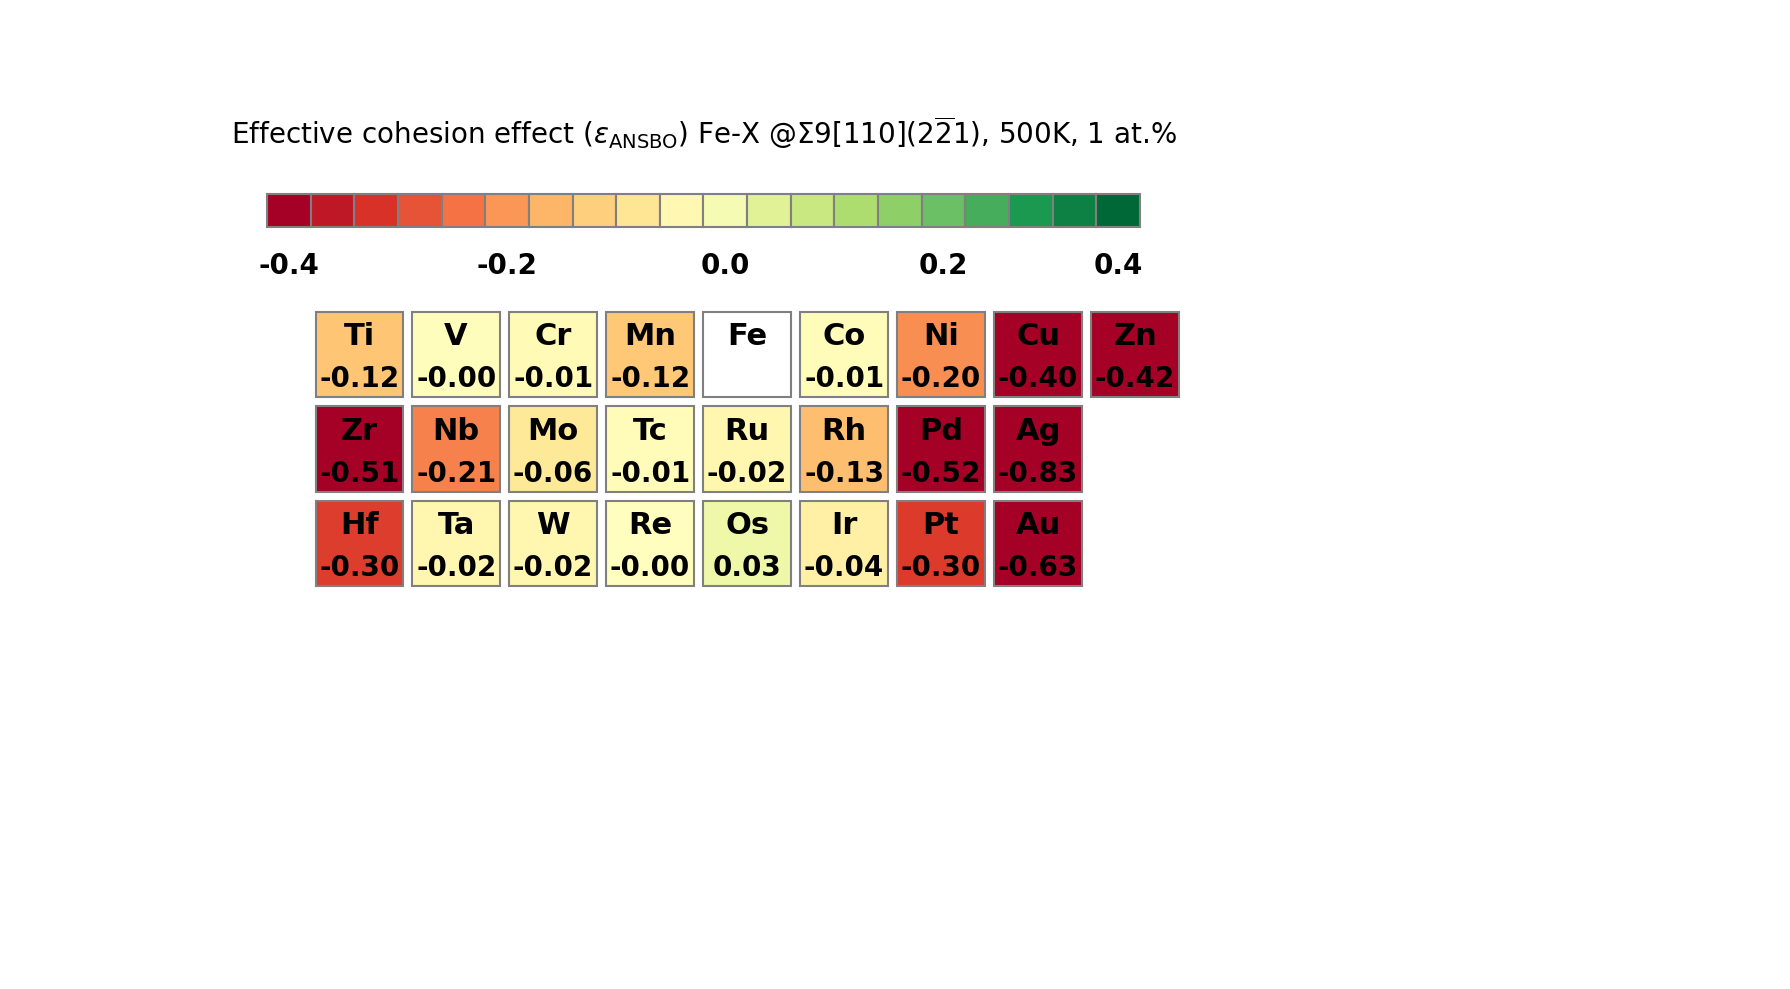

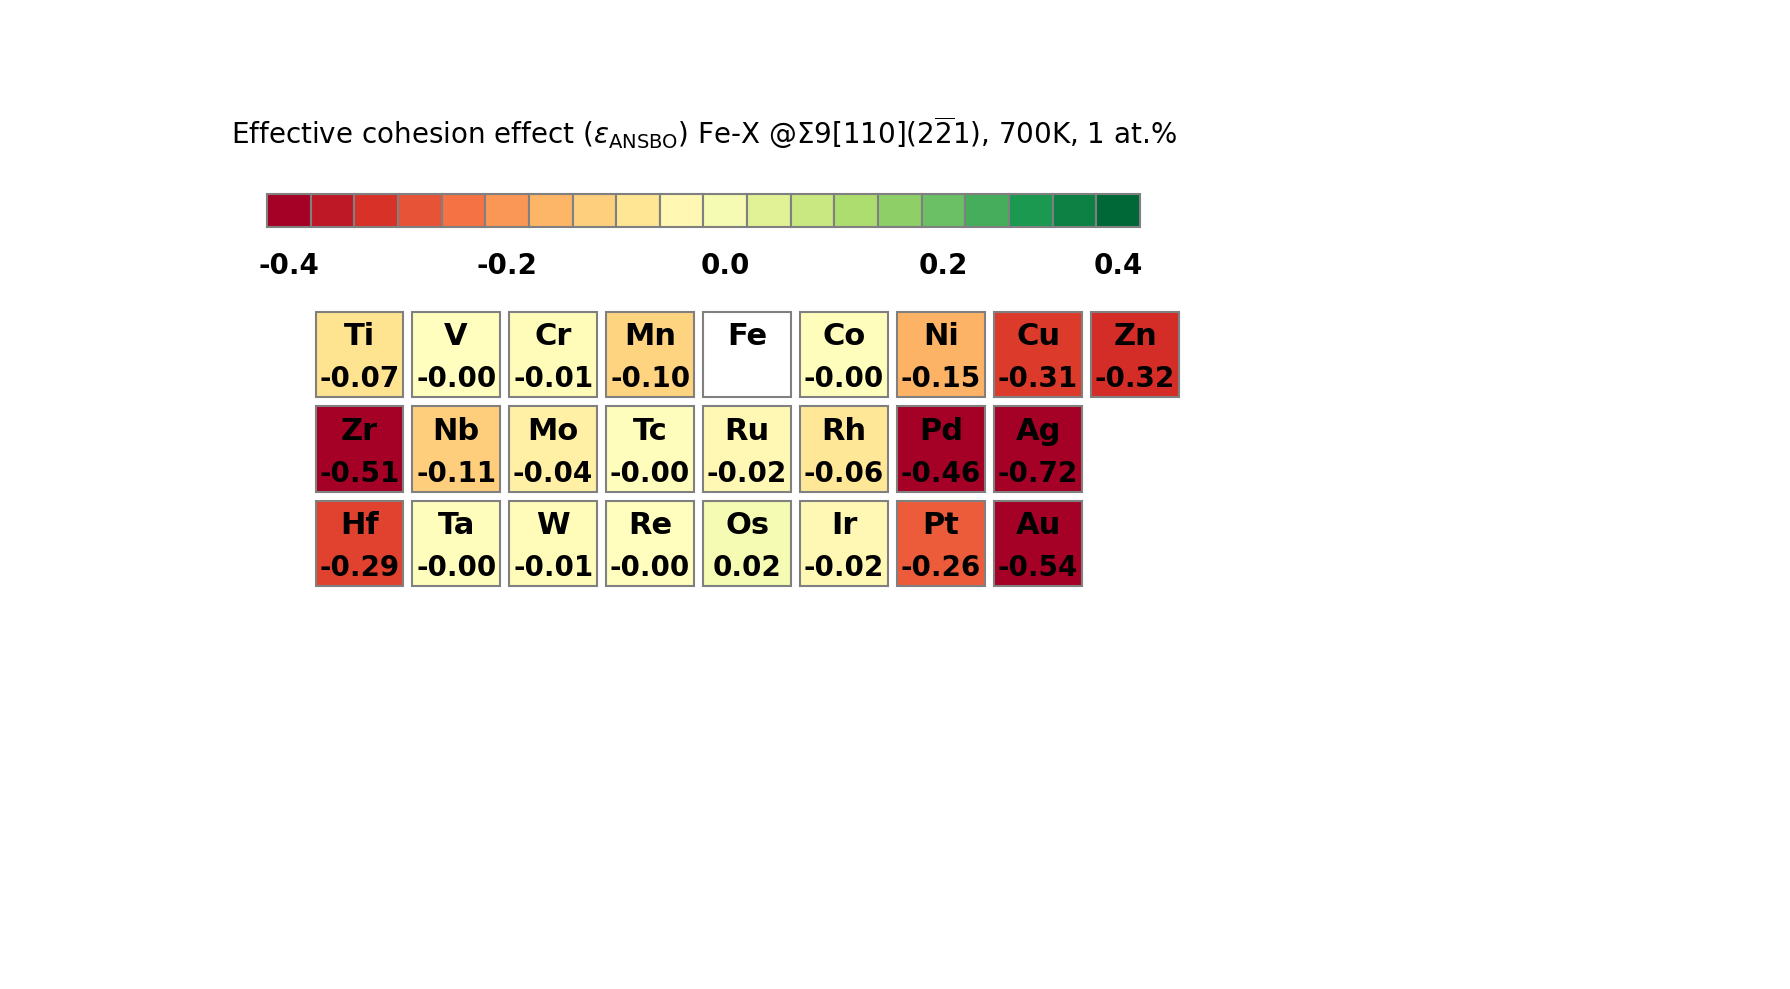

In [ ]:
import matplotlib.cm as cm
from FeGB_PtableSeg.plotters import periodic_table_plot_filtered, gb_latex_dict

# 1) Define the symbols (or Z‐numbers) you want to plot
wanted = ["Mg","Al","Ti","V","Cr","Mn","Co","Ni","Cu","Zn","Nb","Mo","Hf","W"]
transition_metals = [
    "Al",
    # 1st row (period 4)
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn",
    # 2nd row (period 5)
    "Y",  "Zr", "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd",
    # 3rd row (period 6)
    "Hf", "Ta", "W",  "Re", "Os", "Ir", "Pt", "Au", "Hg",
    # 4th row (period 7)
    "Rf", "Db", "Sg", "Bh", "Hs", "Mt", "Ds", "Rg", "Cn"
]
wanted = [
    # 1st row (period 4)
    "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn",
    # 2nd row (period 5)
    "Zr", "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag",
    # 3rd row (period 6)
    "Hf", "Ta", "W",  "Re", "Os", "Ir", "Pt", "Au",
    # 4th row (period 7)
    "Rf", "Db", "Sg", "Bh", "Hs", "Mt", "Ds", "Rg", "Cn"
]
for GB, df_GB in df_cohesion.groupby("GB"):
    for temp, df_temp in df_GB.groupby("temperature_K"):
        # if GB != "S3_RA110_S1_11":
        #     continue
        # 2) Subset your df_cohesion at 300 K and the GB of interest, *and* keep only those elements
        df_ele = df_temp[
            (df_temp["element"].isin(wanted))
        ]
        # 3) Call the periodic‐table plotter with a green‐positive/red‐negative map
        fig, ax = periodic_table_plot_filtered(
            df_ele,
            property="effective_cohesion",
            count_min=-0.4,
            center_cm_zero=True,
            cmap=cm.RdYlGn,                     # negative→red, positive→green
            property_name=f"Effective cohesion effect ("+r"$\epsilon_{\rm{ANSBO}}$" +") "+ "Fe-X @"+ f"{gb_latex_dict[GB]}, {temp}K, 1 at.%",
            element_font_color="black",
            highlight_Z_list=None,              # we're only passing the wanted elements
            hatch_linewidth=4,
            elements_to_plot = wanted
        )
        fig.savefig(fname=f"/mnt/c/Users/liger/Koofr/Fe-PtableTrends-Manuscript/2025_05_09_Revision/Fig10c_{GB}_{temp}.jpg")

## Figure 11a

In [ ]:
df["R_ordered_ANSBO_lst"] = [np.array(row.ANSBO_Wsep_RGS_corr_vals)/row.pure_DDEC6_min_ANSBO for _, row in df.iterrows()]
df["R_Wsep_RGS_lst_minidx"] = df.R_Wsep_RGS_lst.apply(lambda x: np.argmin(x))
df["R_DDEC6_ANSBO_minidx"] = df.R_ordered_ANSBO_lst.apply(lambda x: np.argmin(x))

R_Wsep_basedonmin_ANSBO = []
for _, row in df.iterrows():
    try:
        a = row.R_Wsep_RGS_lst[row.R_DDEC6_ANSBO_minidx]
    except Exception as e:
        a = np.nan
    R_Wsep_basedonmin_ANSBO.append(a)

df["R_Wsep_RGS_wrt_min_ANSBO"] = R_Wsep_basedonmin_ANSBO

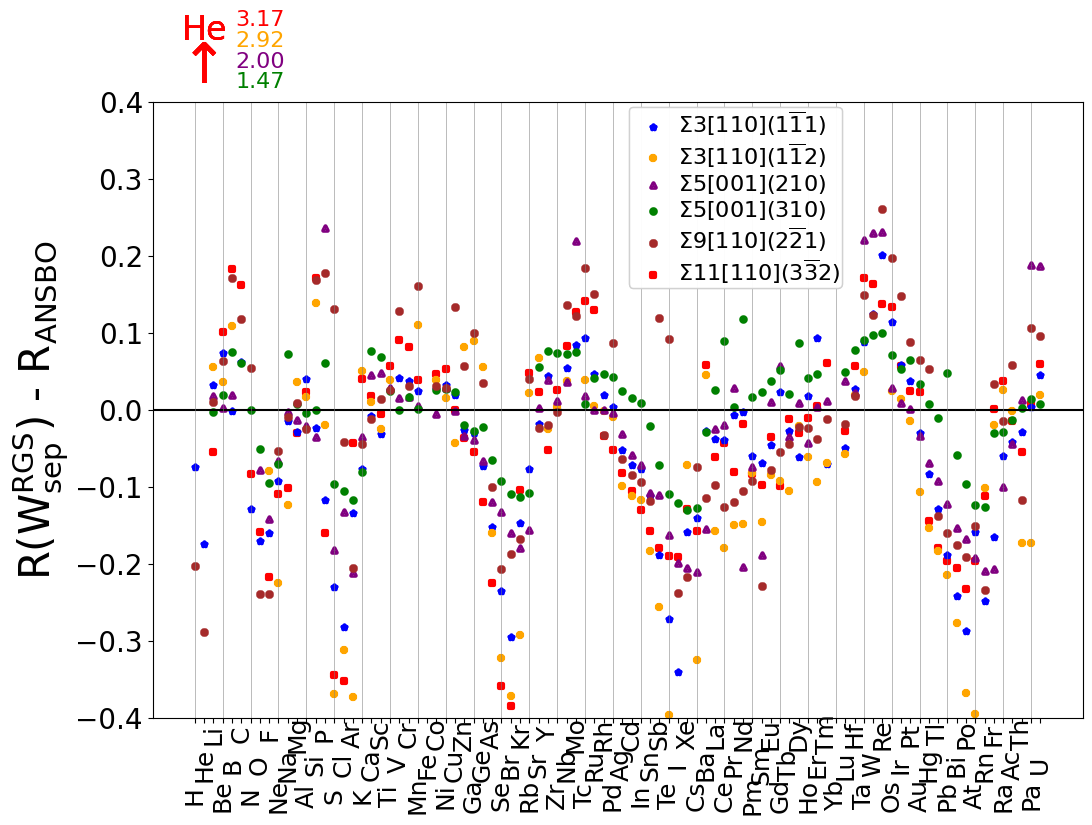

In [ ]:
figsize = (12, 8)
ylabel = r"R(W$_{\rm{sep}}^{\rm{RGS}}$) - R$_{\rm{ANSBO}}$"
ylabel_fontsize = 30
xtick_labels = bulk_df.element.values
xtick_posns = bulk_df.Z.values
xtick_fontsize = 18
ytick_fontsize = 20
shift_xticks = True
xtick_yshift = 0
legend_fontsize = 16


def annotate_outliers(x, y, user_text, threshold=0.4, data=None):
    arrow_text = '↑' if y > threshold else '↓'
    arrow_direction = 'bottom' if y > threshold else 'top'
    arrow_color = 'red' if y > threshold else 'green'
    arrow_xytext = (0, 5) if y > threshold else (0, -5)  # Offset for the arrow

    # Annotating the arrow
    ax.annotate(arrow_text, xy=(x, threshold if y > threshold else -threshold), 
                xytext=arrow_xytext, textcoords="offset points", ha='center', va=arrow_direction, 
                color=arrow_color, fontsize=40)

    # User text placement relative to the arrow
    user_text_xytext = (0, 40) if y > threshold else (0, -20)  # Adjust this offset as needed
    ax.annotate(user_text, xy=(x, threshold if y > threshold else -threshold), 
                xytext=user_text_xytext, textcoords="offset points", ha='center', 
                va='bottom' if y > threshold else 'top', color=arrow_color, fontsize=24)
    
min_Eseg_df = []
for gb, gb_df in filtered_df.dropna(subset="R_Wsep_RGS_lst").groupby("GB"):
    # First, find the row indices of the minimum "E_seg" within each "Element" group
    idx_min_E_seg_per_element = gb_df.groupby('element')['E_seg'].idxmin()
    # Use these indices to select the corresponding rows from the original DataFrame
    min_E_seg_GB_df = df.loc[idx_min_E_seg_per_element].reset_index(drop=True)
    min_Eseg_df.append(min_E_seg_GB_df)

min_Eseg_perGB_df = pd.concat(min_Eseg_df)


# Create a plot
fig, ax = plt.subplots(figsize=figsize)
gb_legends = []  # Initialize outside the loop to collect all legend entries
thresholds = [-0.4, 0.4]

# Looping over each unique "element"
for gb, gb_df in min_Eseg_perGB_df.groupby("GB"):
    x_values = gb_df['Z']
    # I am comparing the min ANSBO cleavage plane cohesion quant vs Wsep
    y_values = gb_df['R_Wsep_RGS_wrt_min_ANSBO'] - gb_df['R_DDEC6_ANSBO'] 
    line = ax.scatter(x_values, y_values, color=custom_colors[gb], marker=gb_marker_dict[gb], linewidth=3, s=10)
    for x, y in zip(x_values, y_values):
        if y > 0.7 or y < -0.7:
            annotate_outliers(x, y,user_text="He", data=y)
    gb_legends.append((line, gb_latex_dict[gb]))  # Append each legend entry
ax.axhline(0, color="k")  # Horizontal line at y=0
ax.set_ylim(thresholds[0], thresholds[1])  # Set y-axis limits to -0.7 to 0.7

# Set labels and axis properties
ax.set_ylabel(ylabel, fontsize=ylabel_fontsize)
if xtick_labels is not None and xtick_posns is not None:
    ax.set_xticks(xtick_posns)
    ax.set_xticklabels(xtick_labels, fontsize=xtick_fontsize, rotation=90, va='center')
ax.tick_params(axis='y', labelsize=ytick_fontsize)

# Adjust the position of x-tick labels if needed
if shift_xticks:
    shifts = [-0.11, -0.06, -0.01, 0.04, 0.09]  # Define y-shift values
    for i, label in enumerate(ax.get_xticklabels()):
        label.set_y(shifts[:3][i % 3] + xtick_yshift)
        
gridline_positions = np.arange(1, 93, 3)
for pos in gridline_positions:
    ax.axvline(x=pos, linestyle='-', linewidth='0.5', color='grey', alpha=0.75)

# Adjust the order of legend entries if needed and create legend
gb_legends.append(gb_legends.pop(0))
gb_legend = ax.legend(*zip(*gb_legends), bbox_to_anchor=(0.5, 0.68), loc="lower left", fontsize=legend_fontsize, handletextpad=0.1, borderpad=0.1, labelspacing=0.15)
ax.add_artist(gb_legend)

outliers = {}

# Loop to collect outliers
for gb, gb_df in min_Eseg_perGB_df.groupby("GB"):
    x_values = gb_df['Z']
    y_values = gb_df['R_Wsep_RGS_wrt_min_ANSBO'] - gb_df['R_DDEC6_ANSBO']
    color = custom_colors[gb]  # Ensure this matches your data structure

    for x, y in zip(x_values, y_values):
        if abs(y) > 0.7:
            data_text = f'{y:.2f}'
            if x not in outliers:
                outliers[x] = {'texts': [data_text], 'color': [color]}
            else:
                outliers[x]['texts'].append(data_text)
                outliers[x]["color"].append(color)
                
# Reverse the dictionary keys
reversed_keys = list(outliers.keys())[::-1]

# Annotating the collected outliers in reversed order
for x in reversed_keys:
    data = outliers[x]
    offset = 0  # Initialize an offset to stagger annotations to avoid overlap
    combined_texts = zip(data['texts'][::-1], data['color'][::-1])  # Ensure this uses 'colors' if each text has a unique color
    for text, color in combined_texts:
        ax.annotate(text, xy=(x + 6, 0.4), xytext=(0, 7 + 10 * offset), textcoords="offset points",
                    ha='center', va='bottom', fontsize=16, color=color)
        offset += 1.5  # Increment offset for the next annotation
        
fig.savefig(f"{fig_savepath}/Figure11a.jpg", dpi=300, bbox_inches='tight', pad_inches=0.1)

## Figure 11b

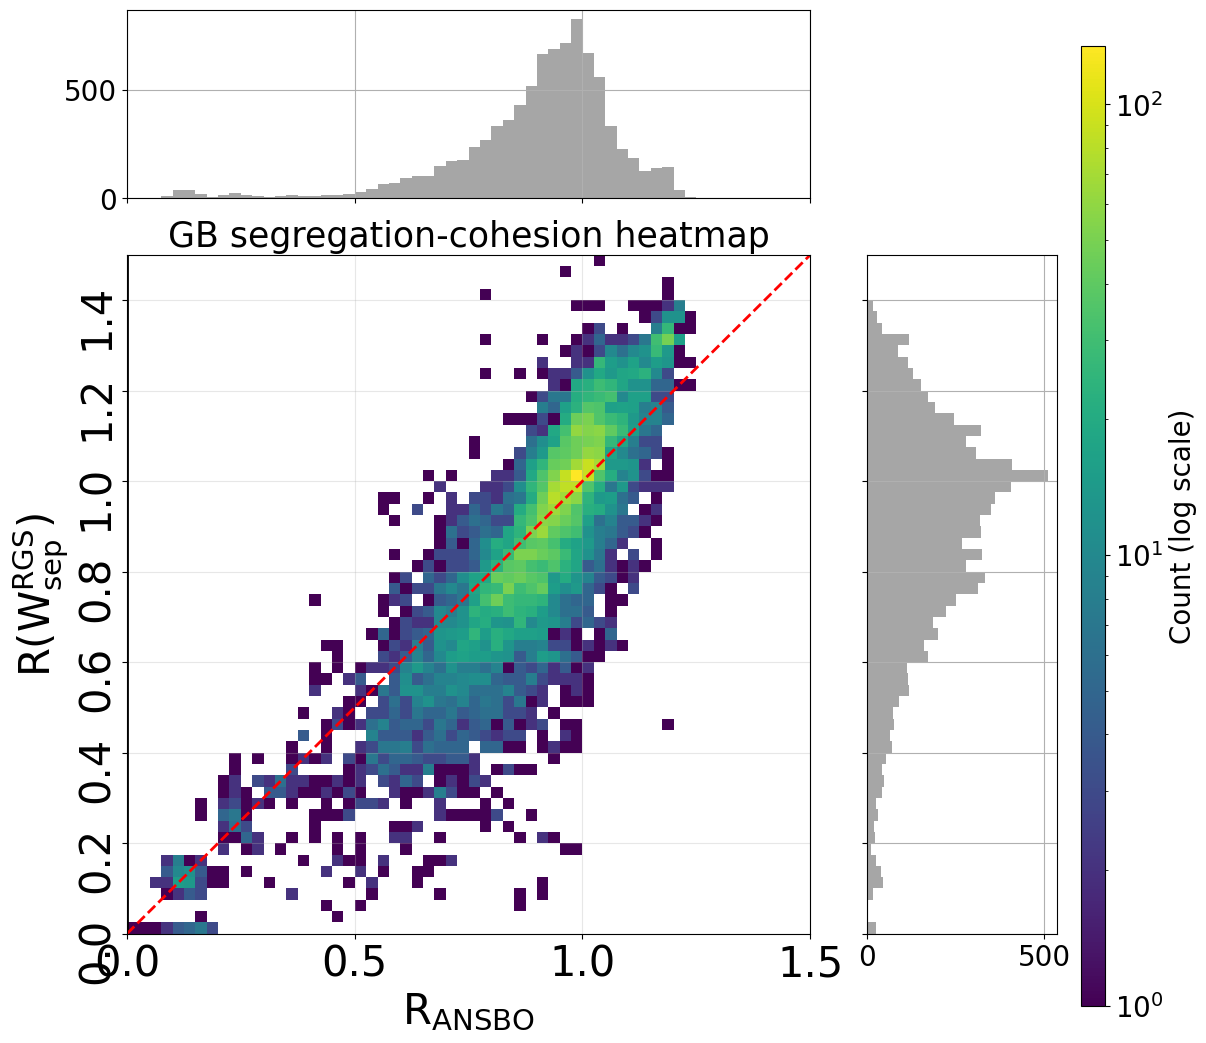

In [ ]:
import numpy as np

n = 3  # number of smallest cohesion values to keep per segregation case

x_filtered = []
y_filtered = []

for idx, row in plot_df[plot_df["E_seg"]<-0.1].iterrows():
    # Get the list-like values and the pure value for division
    ansbo_vals = row["ANSBO_Wsep_RGS_corr_vals"]
    r_wsep_vals = row["R_Wsep_RGS_lst"]
    pure_val = row["pure_DDEC6_min_ANSBO"]
    
    # Skip this row if:
    #  - Either ansbo_vals or r_wsep_vals is not list-like
    #  - pure_val is NaN or zero (to avoid division errors)
    #  - Their lengths don't match
    if not (isinstance(ansbo_vals, (list, np.ndarray)) and isinstance(r_wsep_vals, (list, np.ndarray))):
        continue
    if pd.isna(pure_val) or pure_val == 0:
        continue
    if len(ansbo_vals) != len(r_wsep_vals):
        continue

    # Adjust the ansbo values by dividing by pure_DDEC6_min_ANSBO
    adjusted_ansbo_vals = [v / pure_val for v in ansbo_vals]

    # Sort indices by the adjusted ansbo values (smallest first)
    sorted_indices = sorted(range(len(adjusted_ansbo_vals)), key=lambda i: adjusted_ansbo_vals[i])
    
    # Take the first n indices
    selected_indices = sorted_indices[:n]
    
    # For each selected index, extract the corresponding x and y values
    for i in selected_indices:
        x_val = r_wsep_vals[i]
        y_val = adjusted_ansbo_vals[i]
        # Only keep the values if both are within [0, 2]
        if 0 <= x_val <= 2 and 0 <= y_val <= 2:
            x_filtered.append(x_val)
            y_filtered.append(y_val)

# Now x_filtered and y_filtered are ready for plotting:
fig, ax1 = plot_prop_vs_prop_with_2d_histograms(
    x_values=y_filtered,
    y_values=x_filtered,
    figsize=(12, 12),
    x_label=r"R$_{\rm{ANSBO}}$",
    x_label_fontsize=30,
    xtick_fontsize=30,
    y_label=r"R(W$_{\rm{sep}}^{\rm{RGS}}$)",
    y_label_fontsize=30,
    ytick_fontsize=30,
    hist_tick_fontsize=20,
    legend_posn=(-0.01, 0.62),
    colorbar_tick_fontsize=20,
    colorbar_size=[0.92, 0.05, 0.02, 0.8],
    ylims=(0.00, 1.5),
    xlims=(0.00, 1.5),
    x_bin_width=0.025,
    y_bin_width=0.025
)

# Add vertical and horizontal lines
#ax1.axhline(1.00, linewidth=2, linestyle="-", c="k")
ax1.axvline(0, linewidth=2, linestyle="-", c="k")
limit = 1.5
ax1.plot([0, limit], [0, limit], color='red', linestyle='--', linewidth=2)

# Set the title
ax1.set_title("GB segregation-cohesion heatmap", fontsize=25)
write_path = f"{fig_savepath}/R_Wsep_vs_R_ANSBO_heatmap.png"
fig.savefig(write_path, dpi=300, bbox_inches='tight', pad_inches=0.1)
fig.savefig(f"{fig_savepath}/Figure11b.jpg", dpi=300, bbox_inches='tight', pad_inches=0.1)

## Figure 12 A comparison+commentary on segregation spectra and why it matters in experimental data
### Figure 12a
#### A plot showing the site availability spectra vs. the probability that it would be occupied for Nb in our GBs

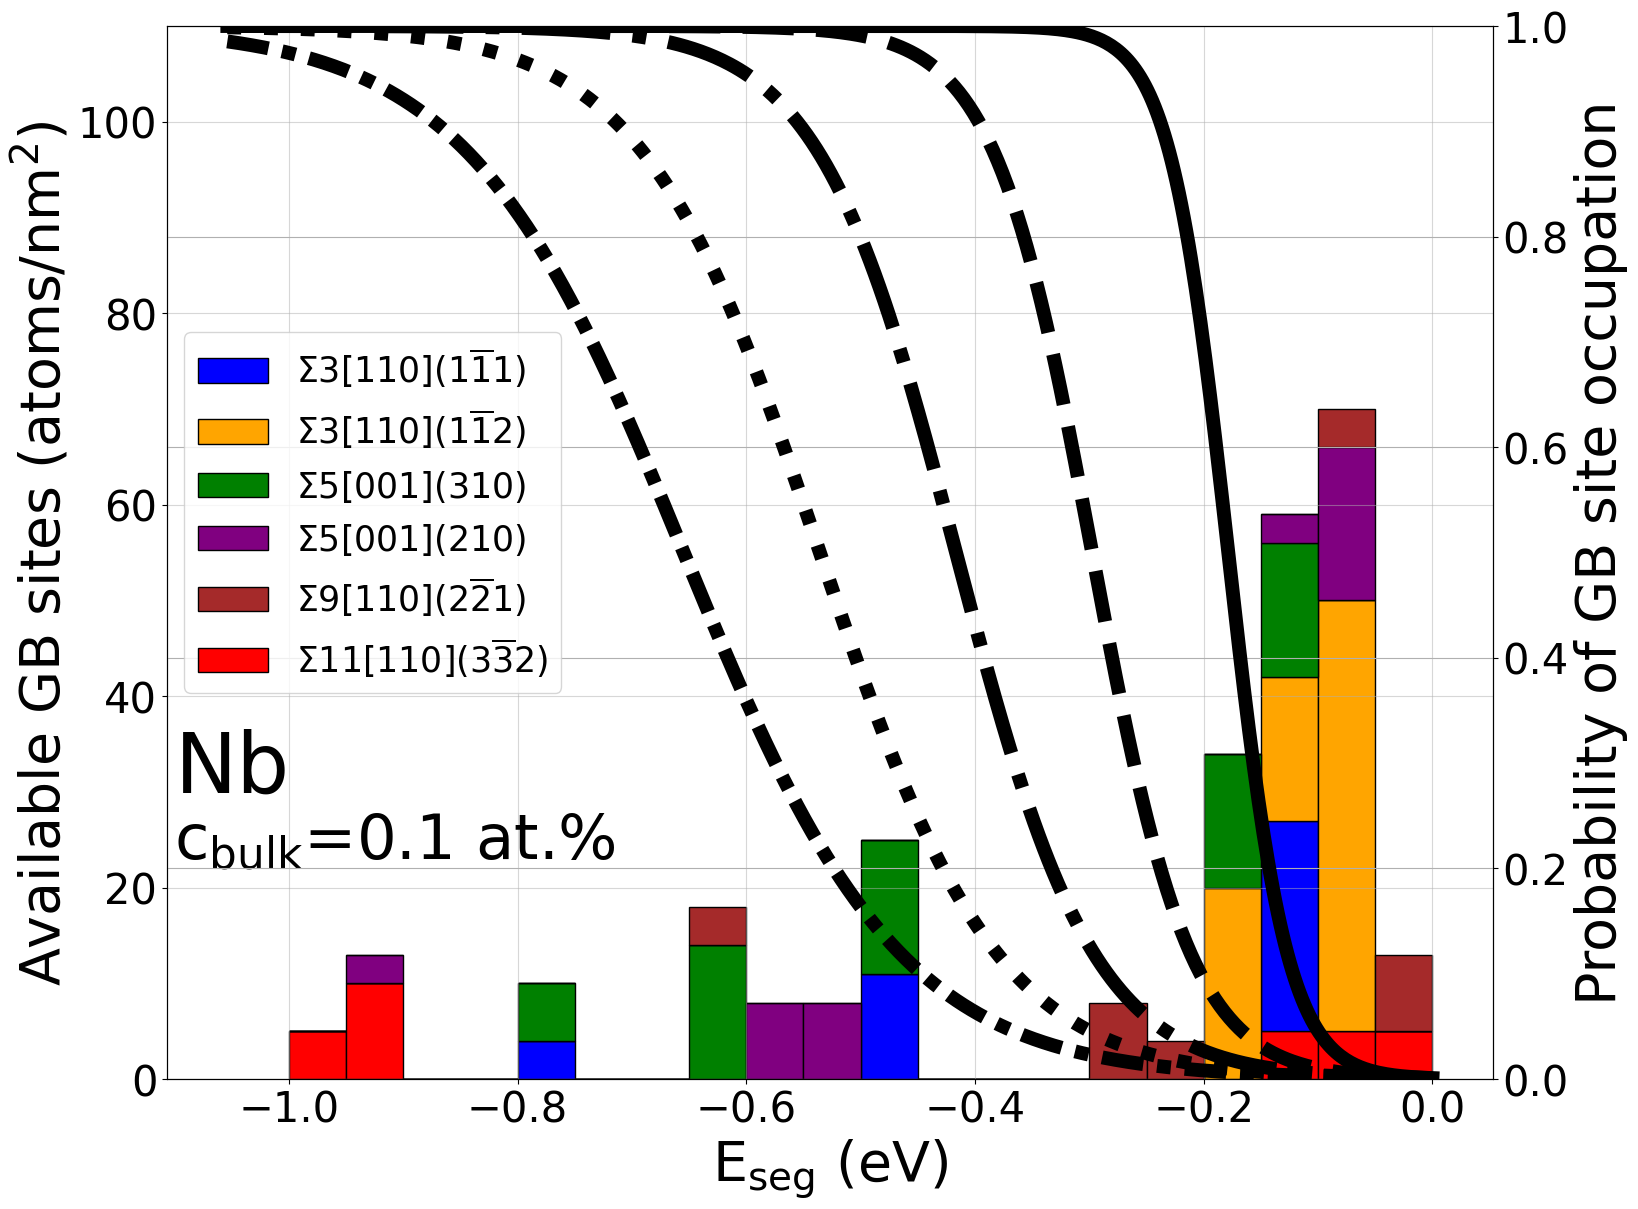

In [ ]:
from FeGB_PtableSeg.plotters import plot_gb_histogram_with_cGB

# Set element and plot parameters
element = 'Nb'
fig, ax, ax2 = plot_gb_histogram_with_cGB(
    df,
    element=element,
    c_bulk=0.001,
    temperatures=[300, 500, 700, 900, 1100],
    ylims_hist=(0, 110),
    ylims_cGB=(0, 1.0),
    ylabel=r"Available GB sites (atoms/nm$^2$)",
    ylabel_fontsize=40,
    ylabel2="Probability of GB site occupation",
    ylabel2_fontsize=40,
    legend_fontsize=25,
    legend_loc=(0.0, 0.35),
    xlabel_fontsize=40,
    custom_colors=custom_colors,
    gb_latex_dict=gb_latex_dict
)

# Add text at the bottom left of ax2
ax.text(s=r"Nb", x=-1.1, y=30, fontsize=60)
ax.text(s=r"c$_{\rm{bulk}}$=0.1 at.%", x=-1.1, y=23, fontsize=45)

# Set font size for axis ticks
ax.tick_params(axis='both', labelsize=30)
ax2.tick_params(axis='both', labelsize=30)

# Define save path and save the figure
write_path = f"{fig_savepath}/Figures/SiteEsegDOS_LangmuirDistribution_{element}.png"
#fig.savefig(write_path, dpi=300, bbox_inches='tight', pad_inches=0.1)
fig.savefig(f"{fig_savepath}/Figure12a_feed.png", dpi=300, bbox_inches='tight', pad_inches=0.1)

### Figure 12b 
#### Why only looking at the strongest binding sites predicted by DFT doesn't give an accurate picture of interfacial coverage in real alloys

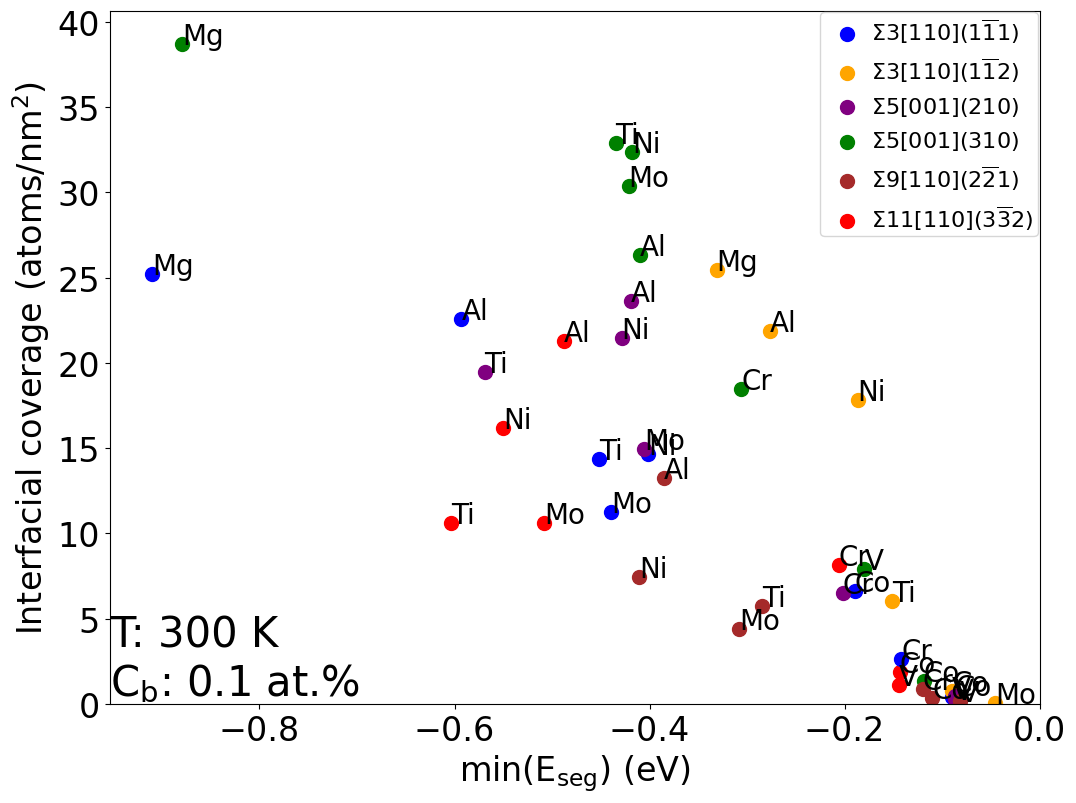

In [ ]:
from FeGB_PtableSeg.plotters import plot_interfacial_coverage_vs_minEseg
fig, ax = plot_interfacial_coverage_vs_minEseg(df,
                                    df_spectra,
                                    ["Ni", "Cr", "Co", "Mo", "Ti", "V", "Al", "Mg"],
                                    atomic_pct_conc=0.1, # 0.1 at. % 
                                    temp=300, # 300 K
                                    nan_segregation=nan_segregation, # Spectra with at least 1 non-converged value are not plottable
                                    gb_latex_dict=gb_latex_dict,
                                    custom_colors=custom_colors)


### Figure 12c
#### Why measuring segregation energies from interfacial excess in experiments and extrapolating this single segregation energy is a bad idea

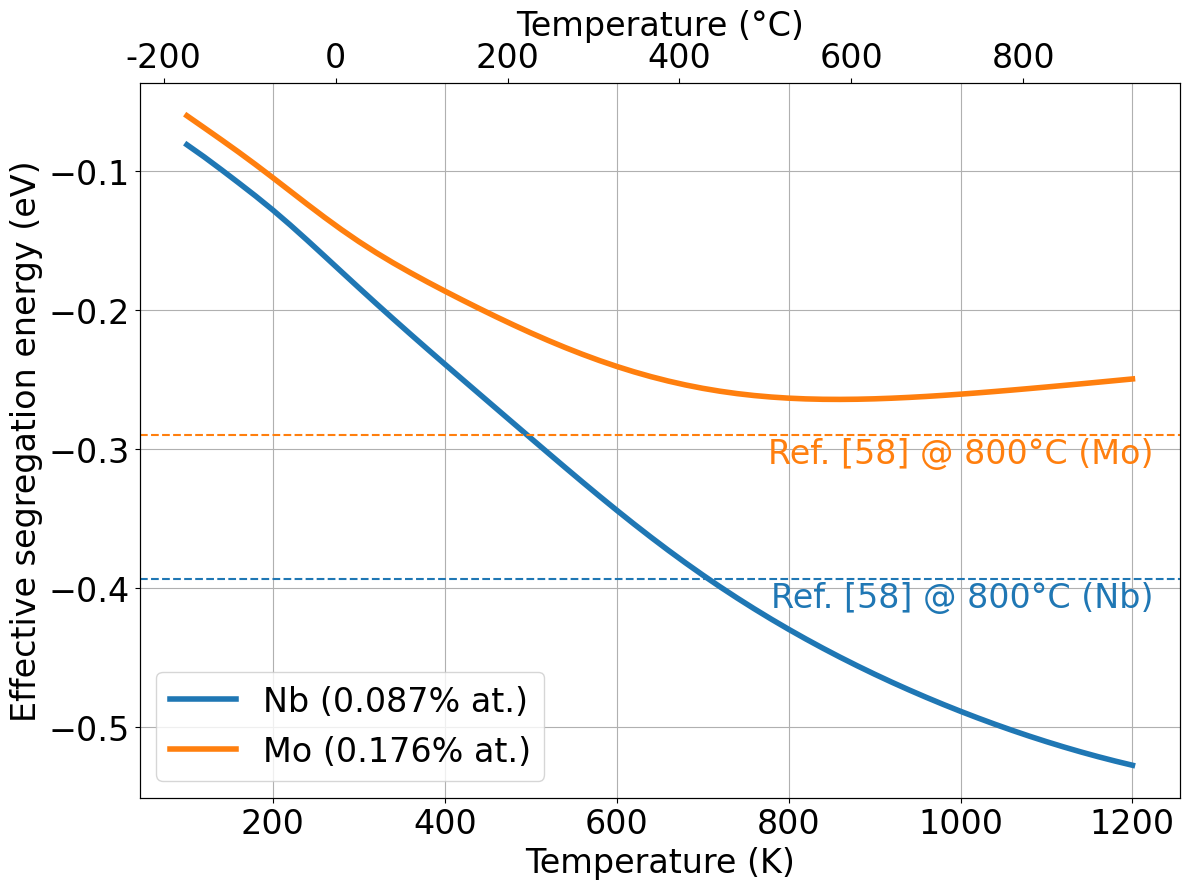

In [ ]:
from FeGB_PtableSeg.plotters import plot_multi_avg_Eseg_vs_temperature
# Example usage:
elements = ["Nb", "Mo"]
alloy_concs = [0.087*0.01, 0.176*0.01]
ref_values = [-38/96.485, -28/96.485]
ref_labels = ["Ref. [58] @ 800°C (Nb)", "Ref. [58] @ 800°C (Mo)"]

fig, ax = plot_multi_avg_Eseg_vs_temperature(
    df_spectra,
    elements,
    alloy_concs,
    ref_values,
    ref_labels,
    temp_range=(100, 1200),
    temp_step=20,
    exclude_GB="S3_RA110_S1_12",
    legend_loc='lower left'
)
# ax.axvline(x=800+273, linestyle="--", color="k")
fig.savefig(f"{fig_savepath}/Figure12c.jpg", dpi=300, bbox_inches='tight', pad_inches=0.1)

### Figure 12c/12d (former) Nb
#### Without collapsing it all into a single averaged segregation energy - per GB plots

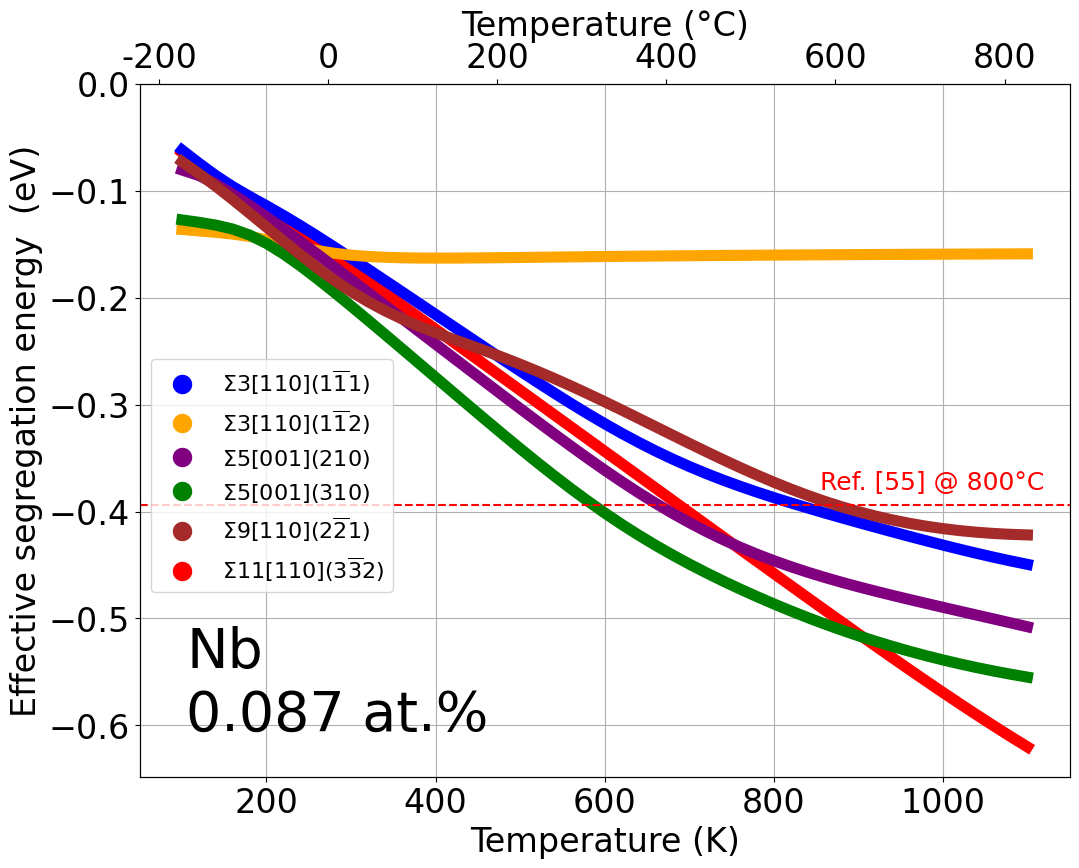

In [ ]:
from FeGB_PtableSeg.plotters import plot_Eseg_vs_temperature
element = "Nb"
fig, ax1 = plot_Eseg_vs_temperature(df_spectra,
                                    element,
                                    gb_latex_dict,
                                    custom_colors,
                                    alloy_conc=0.01 * 0.087,
                                    temp_range=(100, 1100),
                                    temp_step=20,
                                    legend_loc='lower left',
                                    legend_bbox_to_anchor=(0.00, 0.25))

# Add the reference line
reference_value = -38 / 96.485
_ = ax1.axhline(reference_value, c="r", linestyle="--")

# Add text above the reference line
ax1.text(1120, reference_value+0.01,  "Ref. [55] @ 800°C", color="r", fontsize=18, verticalalignment='bottom', horizontalalignment='right')

# Adjust the y-axis limit
_ = ax1.set_ylim([None, 0])
write_path = f"{fig_savepath}/Figures/EffectiveSegregationEnergy/EffectiveSegregationEnergy_vs_temp_{element}.png"

#fig.savefig(write_path, dpi=300, bbox_inches='tight', pad_inches=0.1)

# fig.savefig(f"{fig_savepath}/Figure12c.jpg", dpi=300, bbox_inches='tight', pad_inches=0.1)

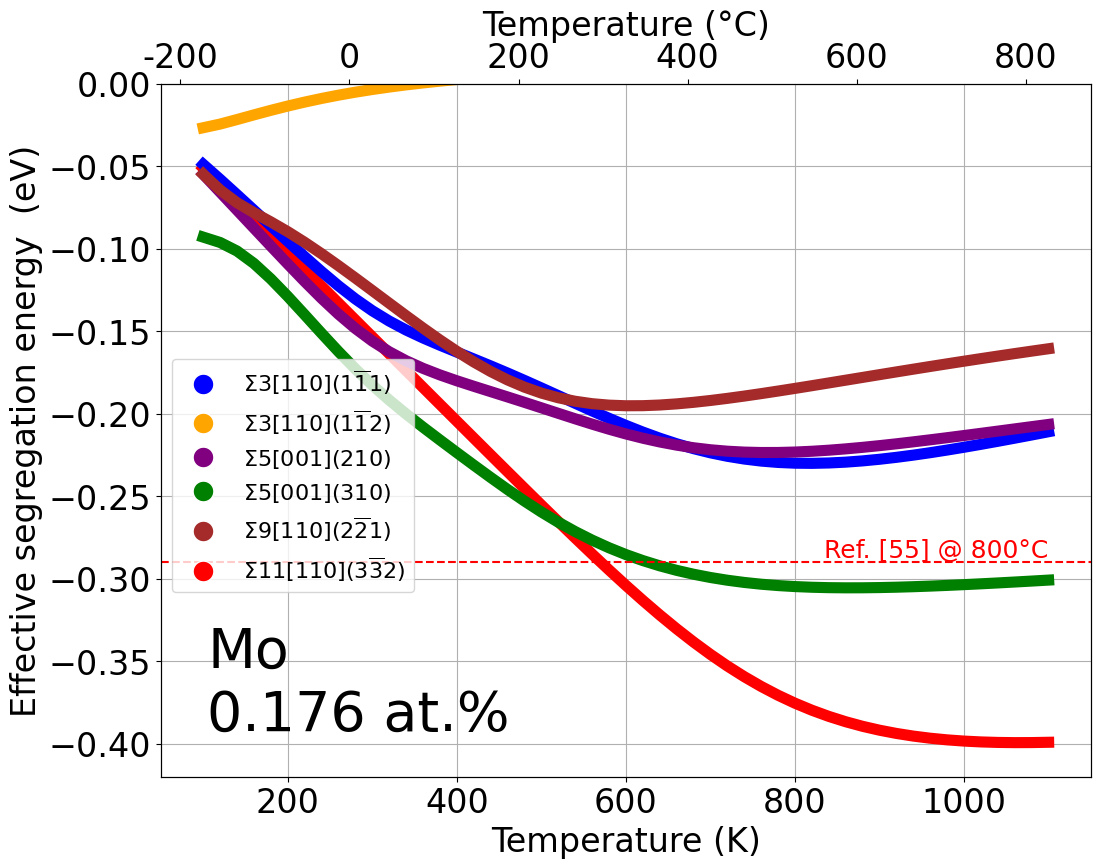

In [ ]:
### Figure 12c Nb
#### Why measuring segregation energies from interfacial excess in experiments and extrapolating this single segregation energy is a bad idea 
element = "Mo"
fig, ax1 = plot_Eseg_vs_temperature(df_spectra,
                                    element,
                                    gb_latex_dict,
                                    custom_colors,
                                    alloy_conc=0.01 * 0.176,
                                    temp_range=(100, 1100),
                                    temp_step=20,
                                    legend_loc='lower left',
                                    legend_bbox_to_anchor=(0.00, 0.25))

# Add the reference line
reference_value = -28 / 96.485
_ = ax1.axhline(reference_value, c="r", linestyle="--")

# Add text above the reference line
ax1.text(1100, reference_value,  "Ref. [55] @ 800°C", color="r", fontsize=18, verticalalignment='bottom', horizontalalignment='right')

# Adjust the y-axis limit
_ = ax1.set_ylim([None, 0])
write_path = f"{fig_savepath}/Figures/EffectiveSegregationEnergy/EffectiveSegregationEnergy_vs_temp_{element}.png"
#fig.savefig(write_path, dpi=300, bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"{fig_savepath}/Figure12d.jpg", dpi=300, bbox_inches='tight', pad_inches=0.1)

# Supplementary Information plots available in SupplementaryFigures notebook - SupplementaryFigures.ipynb

In [11]:
#cleanup
!rm -r Data/S11-RA110-S3-32-He-19 Figures

rm: cannot remove 'Data/S11-RA110-S3-32-He-19': No such file or directory
